In [ ]:
# origin
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
max_length = 1000000
InteractiveShell.instance().display_formatter.formatters['text/plain'].max_seq_length = int(max_length)
import warnings
from sklearn.exceptions import UndefinedMetricWarning

warnings.filterwarnings("ignore", category=UndefinedMetricWarning)

from collections import deque
import os
import sys
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
import numpy as np
import torch

import pandas as pd
import timm
from torch.amp import autocast
import torch.nn as nn
import torch.nn.functional as F


import sys
sys.path.append(project_root)
from AppleCider.preprocess.data_loader import *
from AppleCider.preprocess.utils import *
from AppleCider.models.SpectraNet import build_spec_model

os.environ["CUDA_LAUNCH_BLOCKING"] = "1"
import datetime


def main(trial=None, config=None, mode='train'):


    # set seed
    torch.cuda.synchronize()
    set_seed(config.get('seed', 42))

    # print config
    print_config(config, trial)
    device = get_device()



    # create data loaders
    train_loader, val_loader, test_loader, class_names = create_data_loaders(config)

    # build model
    model = build_spec_model(config).to(device)
    ema = EMA(model, decay=config['ema_decay'])
    ema.register()
    optimizer = build_optimizer(model, config)
    scheduler = build_scheduler(optimizer, config)

    # get cb weights
    train_pt_path = os.path.join(config['train_dir'])
    pt_data = torch.load(train_pt_path)
    train_labels = pt_data['labels']

    if isinstance(train_labels[0], str):
        class_to_idx = {cls_name: i for i, cls_name in enumerate(class_names)}
        train_labels = [class_to_idx[label] for label in train_labels]

    # construct DataFrame for get_cb_weights
    train_data_df = pd.DataFrame({'label': train_labels})
    alpha = get_cb_weights(train_data_df, class_names, beta=0.9999).to(device)

    # define criterion
    criterion = FocalLoss(alpha=alpha, gamma=config['focal_loss_gamma'])
    scaler = torch.amp.GradScaler()

    # define best val metrics
    best_val_f1 = 0.0
    best_val_metrics = None
    no_improve_epochs = 0
    save_dir = config.get("model_save_dir", "../checkpoints")
    per_class_auc_dict = {}
    for epoch in range(config['epochs']):
        print(f"\n[Epoch {epoch+1}/{config['epochs']}]")
        train_loader, _, _, class_names = create_data_loaders(config)
        train_loss, train_acc = train_one_epoch(
            model, train_loader, criterion, optimizer, device, scaler,
            max_grad_norm=1.0, ema=ema, use_redshift=False
        )

        ema.apply_shadow()
        val_loss, val_acc, val_f1, val_top3_acc, class_top3_acc, composite_score ,auc_roc,per_class_auc_dict = validate(
            model, val_loader, criterion, device, class_names, epoch, project_root, use_redshift=False,epoch_type="val"
        )
        ema.restore()
        print(f"[Val @ Epoch {epoch+1}] Top-1 Acc: {val_acc:.2f}%, Top-3 Acc: {val_top3_acc:.2f}%, F1: {val_f1:.4f}")

        scheduler.step()

        if val_f1 > best_val_f1 + 1e-6:
            best_val_f1 = val_f1
            no_improve_epochs = 0

            best_val_metrics = {
                "val_loss": val_loss,
                "val_acc": val_acc,
                "val_f1": val_f1,
                "val_top3_acc": val_top3_acc,
                "composite_score": composite_score,
            }

            ema.apply_shadow()
            os.makedirs(save_dir, exist_ok=True)
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
            ema.restore()

            print(f">>> New Best Accuracy: {best_val_f1:.4f}")
        else:
            no_improve_epochs += 1
            print(f">>> No F1 improvement for {no_improve_epochs} epoch(s)")

        if early_stopping(no_improve_epochs, config['patience']):
            print(">>> Early stopping triggered based on composite score.")
            break



        clean_memory()

    print(f"Best F1 on Validate dataset: {best_val_f1:.4f}")

    if mode == 'train':
        print("\n>>> Final Testing on Test Set...")

        # reload best model weight (with EMA)
        best_model_path = os.path.join(save_dir, "best_model.pth")
        model.load_state_dict(torch.load(best_model_path))
        model.eval()

        # no need to use ema.apply_shadow() again
        test_loss, test_acc, test_f1, test_top3_acc, class_top3_acc, test_composite_score,macro_auc, per_class_auc_dict = validate(
            model, test_loader, criterion, device, class_names, epoch='Final_Test', project_root=project_root, use_redshift=False,epoch_type="test"
        )

        print(f">>> Test Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%, F1: {test_f1:.4f}, Top-3 Acc: {test_top3_acc:.2f}%, Composite: {test_composite_score:.4f}")

        return test_composite_score, {
            "f1": test_f1,
            "acc": test_acc,
            "test_top3_acc": test_top3_acc,
            "composite_score": test_composite_score,
            "class_top3_acc": class_top3_acc,
            "per_class_auc_dict": per_class_auc_dict
        }

def run_multi_seed(config, seed_list):
    test_scores = []
    test_metrics_list = []
    macro_auc_list = []
    per_class_auc_lists = {}

    for i, seed in enumerate(seed_list):
        print(f"\n=== Running seed {seed} ({i+1}/{len(seed_list)}) ===")
        config['seed'] = seed
        test_score, test_metrics = main(trial=None, config=config)

        test_scores.append(test_score)
        test_metrics_list.append(test_metrics)

        # Collect Macro AUC and Per-Class AUCs
        per_class_auc_dict = test_metrics.get("per_class_auc_dict", {})
        macro_auc = np.mean(list(per_class_auc_dict.values()))
        macro_auc_list.append(macro_auc)

        for cls_name, auc_val in per_class_auc_dict.items():
            if cls_name not in per_class_auc_lists:
                per_class_auc_lists[cls_name] = []
            per_class_auc_lists[cls_name].append(auc_val)

    # Aggregate metrics
    mean_score = np.mean(test_scores)
    std_score = np.std(test_scores)

    acc_list = [m["acc"] for m in test_metrics_list]
    top3_acc_list = [m["test_top3_acc"] for m in test_metrics_list]
    f1_list = [m["f1"] for m in test_metrics_list]

    mean_acc = np.mean(acc_list)
    std_acc = np.std(acc_list)

    mean_top3_acc = np.mean(top3_acc_list)
    std_top3_acc = np.std(top3_acc_list)

    mean_f1 = np.mean(f1_list)
    std_f1 = np.std(f1_list)

    mean_macro_auc = np.mean(macro_auc_list)
    std_macro_auc = np.std(macro_auc_list)

    # Pack results
    result_summary = {
        "seed_list": seed_list,
        "test_scores": test_scores,
        "test_metrics_list": test_metrics_list,
        "acc_list": acc_list,
        "top3_acc_list": top3_acc_list,
        "f1_list": f1_list,
        "macro_auc_list": macro_auc_list,
        "per_class_auc_lists": per_class_auc_lists,
        "mean_score": mean_score,
        "std_score": std_score,
        "mean_acc": mean_acc,
        "std_acc": std_acc,
        "mean_top3_acc": mean_top3_acc,
        "std_top3_acc": std_top3_acc,
        "mean_f1": mean_f1,
        "std_f1": std_f1,
        "mean_macro_auc": mean_macro_auc,
        "std_macro_auc": std_macro_auc,
    }

    # Optionally print summary (optional: you may comment this in a notebook)
    print("\n=== Multi-Seed Test Results ===")
    for i, seed in enumerate(seed_list):
        print(f"Seed {seed}: Composite Score = {test_scores[i]:.4f}, "
              f"Acc = {acc_list[i]:.2f}%, Top-3 Acc = {top3_acc_list[i]:.2f}%, "
              f"F1 = {f1_list[i]:.4f}, Macro AUC = {macro_auc_list[i]:.4f}")

    print("\n=== Multi-Seed Mean / Std ===")
    print(f"Composite Score: Mean = {mean_score:.4f}, Std = {std_score:.4f}")
    print(f"Accuracy:        Mean = {mean_acc:.2f}%, Std = {std_acc:.2f}%")
    print(f"Top-3 Accuracy:  Mean = {mean_top3_acc:.2f}%, Std = {std_top3_acc:.2f}%")
    print(f"Macro F1:        Mean = {mean_f1:.4f}, Std = {std_f1:.4f}")
    print(f"Macro AUC:       Mean = {mean_macro_auc:.4f}, Std = {std_macro_auc:.4f}")

    print("\n=== Per-Class AUC (Mean ± Std) ===")
    for cls_name, aucs in per_class_auc_lists.items():
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        print(f"{cls_name:20s}: Mean = {mean_auc:.4f}, Std = {std_auc:.4f}")

    return result_summary

def print_multi_seed_summary(summary):
    seed_list = summary["seed_list"]
    test_scores = summary["test_scores"]
    acc_list = summary["acc_list"]
    top3_acc_list = summary["top3_acc_list"]
    f1_list = summary["f1_list"]
    macro_auc_list = summary["macro_auc_list"]
    per_class_auc_lists = summary["per_class_auc_lists"]

    # Print per-seed results
    print("\n=== Multi-Seed Test Results ===")
    for i, seed in enumerate(seed_list):
        print(f"Seed {seed}: Composite Score = {test_scores[i]:.4f}, "
              f"Acc = {acc_list[i]:.2f}%, Top-3 Acc = {top3_acc_list[i]:.2f}%, "
              f"F1 = {f1_list[i]:.4f}, Macro AUC = {macro_auc_list[i]:.4f}")

    # Print mean/std
    print("\n=== Multi-Seed Mean / Std ===")
    print(f"Composite Score: Mean = {summary['mean_score']:.4f}, Std = {summary['std_score']:.4f}")
    print(f"Accuracy:        Mean = {summary['mean_acc']:.2f}%, Std = {summary['std_acc']:.2f}%")
    print(f"Top-3 Accuracy:  Mean = {summary['mean_top3_acc']:.2f}%, Std = {summary['std_top3_acc']:.2f}%")
    print(f"Macro F1:        Mean = {summary['mean_f1']:.4f}, Std = {summary['std_f1']:.4f}")
    print(f"Macro AUC:       Mean = {summary['mean_macro_auc']:.4f}, Std = {summary['std_macro_auc']:.4f}")

    # Print per-class AUC
    print("\n=== Per-Class AUC (Mean ± Std) ===")
    for cls_name, aucs in per_class_auc_lists.items():
        mean_auc = np.mean(aucs)
        std_auc = np.std(aucs)
        print(f"{cls_name:20s}: Mean = {mean_auc:.4f}, Std = {std_auc:.4f}")




=== Running seed 42 (1/3) ===

[Epoch 1/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 13.31it/s, acc=58.4, loss=0.159]


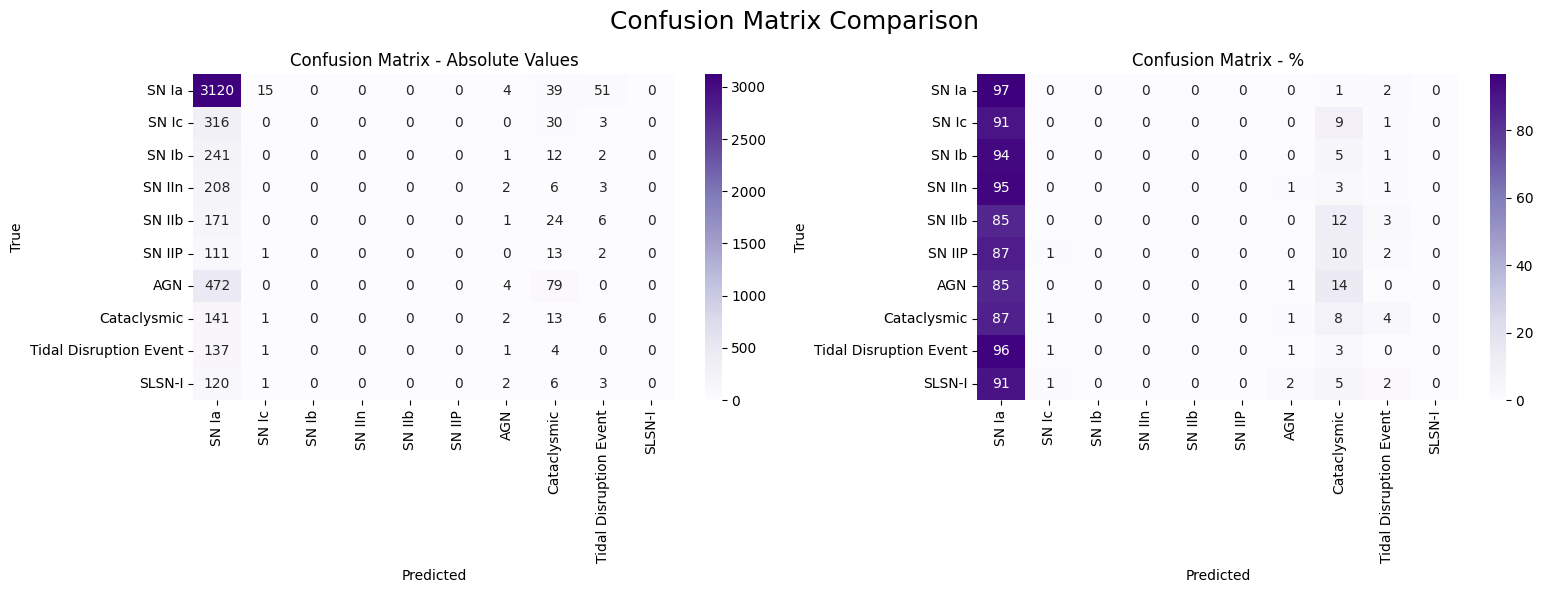

📊 [Val @ Epoch 1] Top-1 Acc: 58.36%, Top-3 Acc: 68.24%, F1: 0.0836
>>> 🚀🚀🚀 New Best Accuracy: 0.0836

[Epoch 2/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.12it/s, acc=65.1, loss=0.0919]


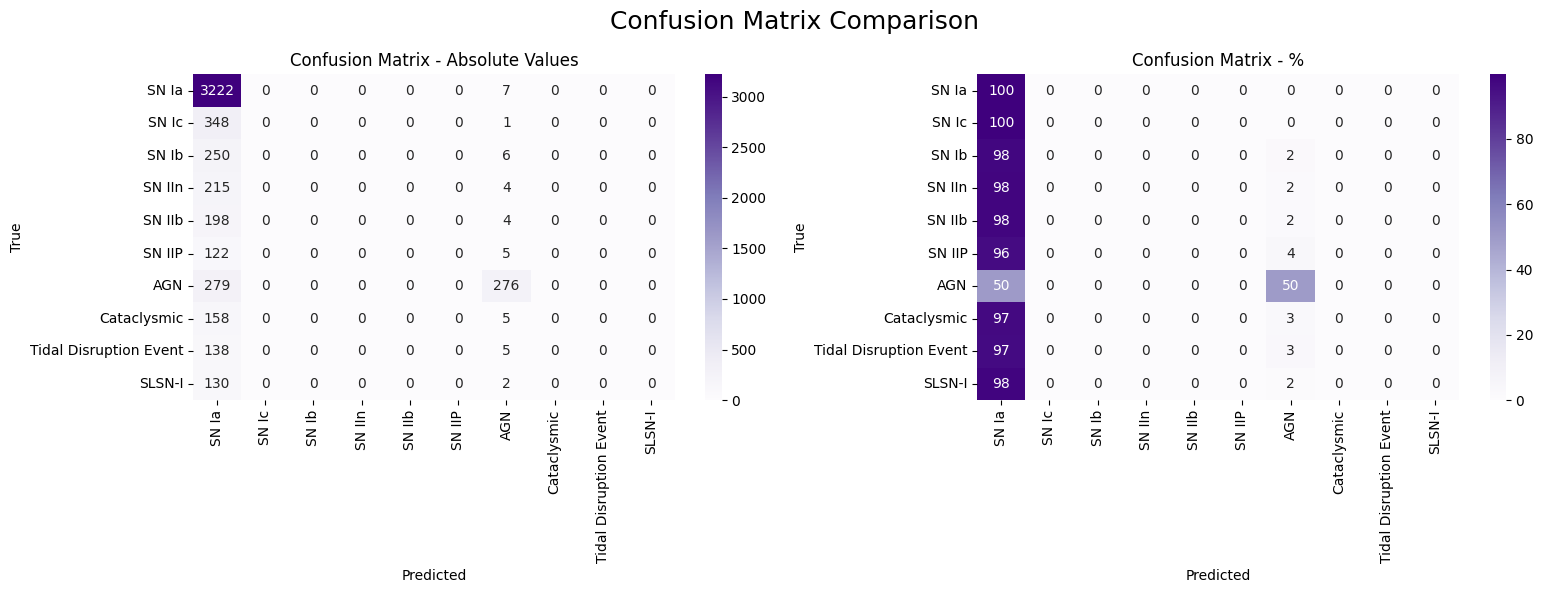

📊 [Val @ Epoch 2] Top-1 Acc: 65.08%, Top-3 Acc: 81.12%, F1: 0.1412
>>> 🚀🚀🚀 New Best Accuracy: 0.1412

[Epoch 3/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.40it/s, acc=69.7, loss=0.0638]


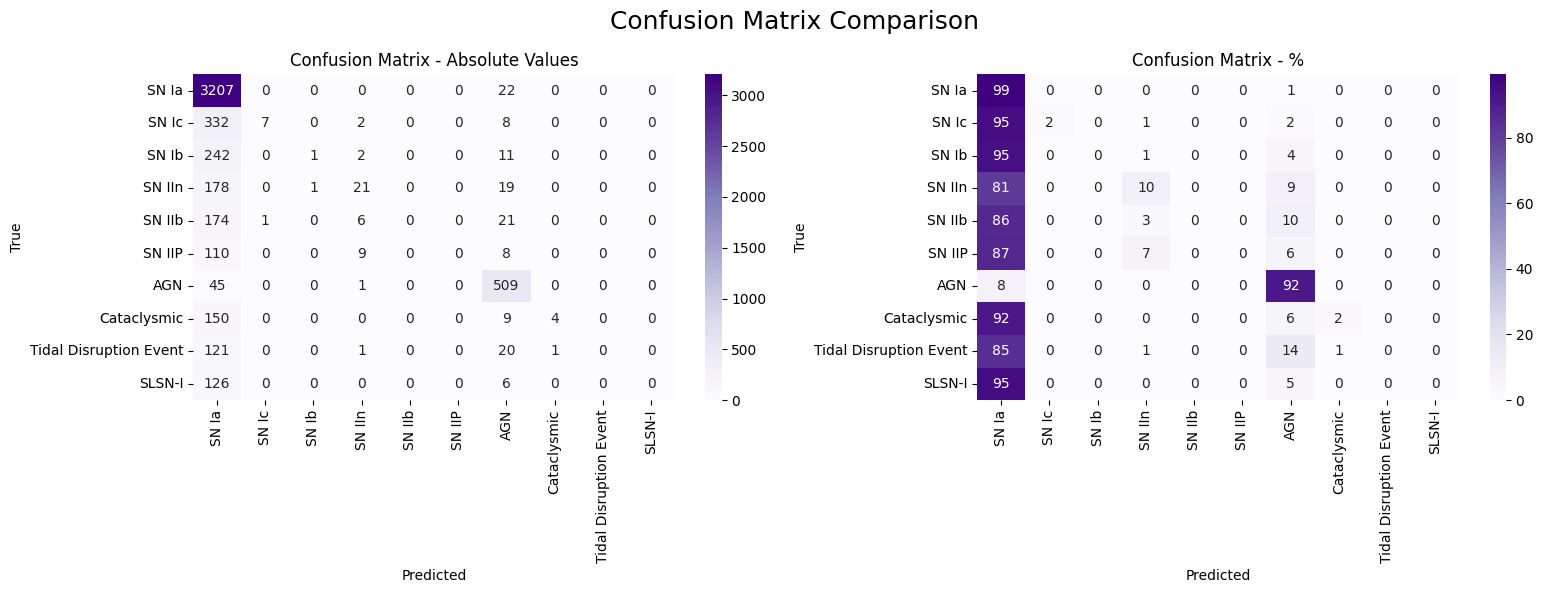

📊 [Val @ Epoch 3] Top-1 Acc: 69.75%, Top-3 Acc: 86.12%, F1: 0.1923
>>> 🚀🚀🚀 New Best Accuracy: 0.1923

[Epoch 4/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.38it/s, acc=79, loss=0.0425]  


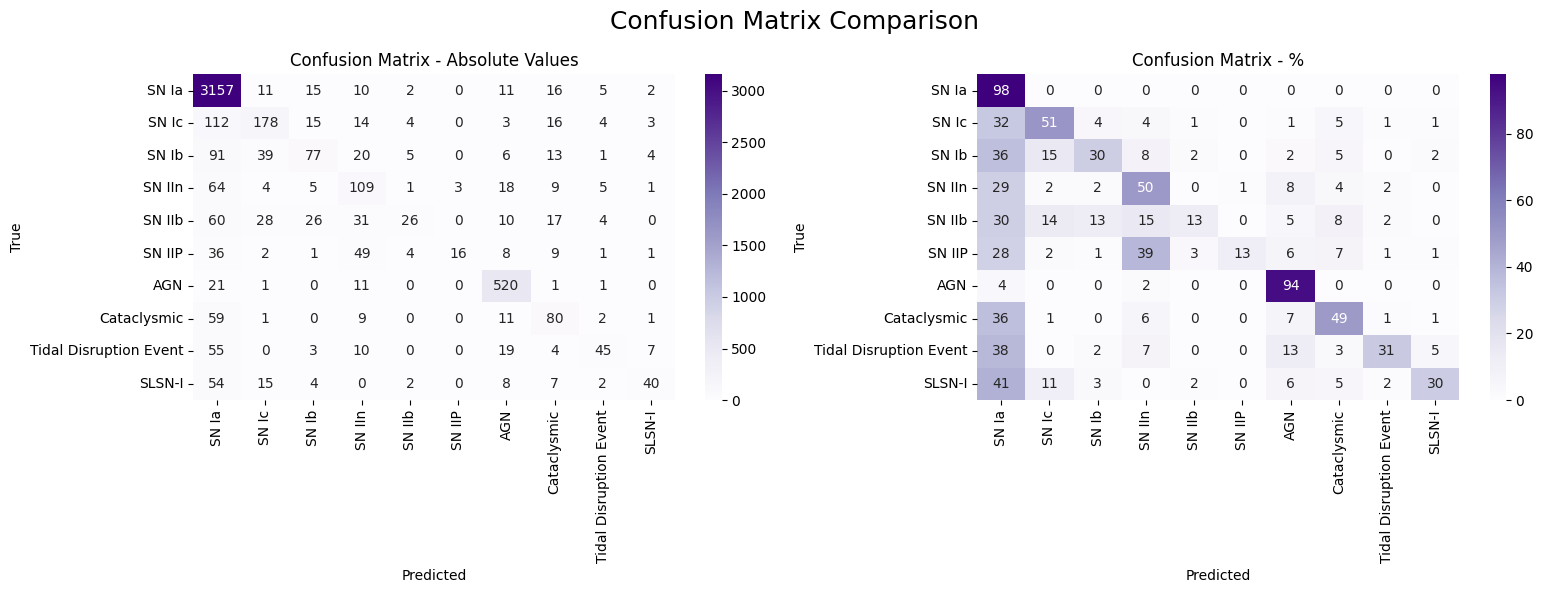

📊 [Val @ Epoch 4] Top-1 Acc: 79.03%, Top-3 Acc: 91.91%, F1: 0.4952
>>> 🚀🚀🚀 New Best Accuracy: 0.4952

[Epoch 5/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.13it/s, acc=83.8, loss=0.0317]


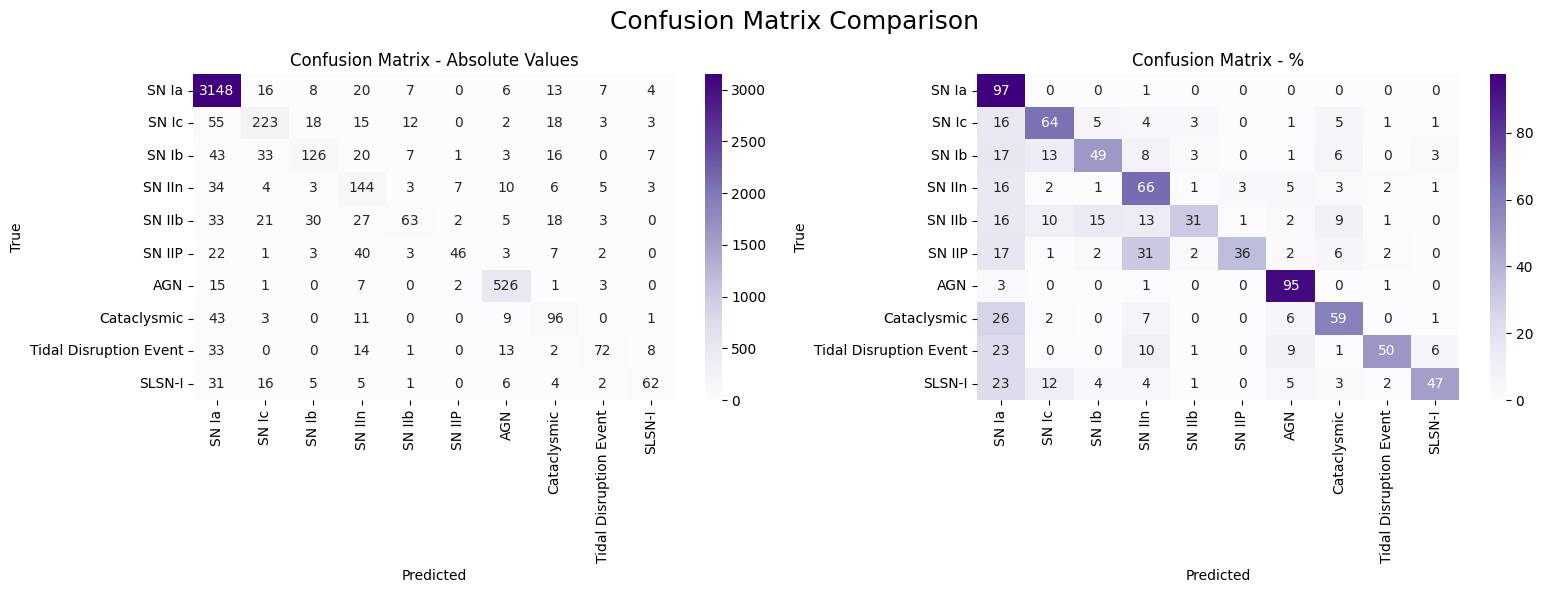

📊 [Val @ Epoch 5] Top-1 Acc: 83.83%, Top-3 Acc: 94.34%, F1: 0.6288
>>> 🚀🚀🚀 New Best Accuracy: 0.6288

[Epoch 6/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.14it/s, acc=86.5, loss=0.0254]


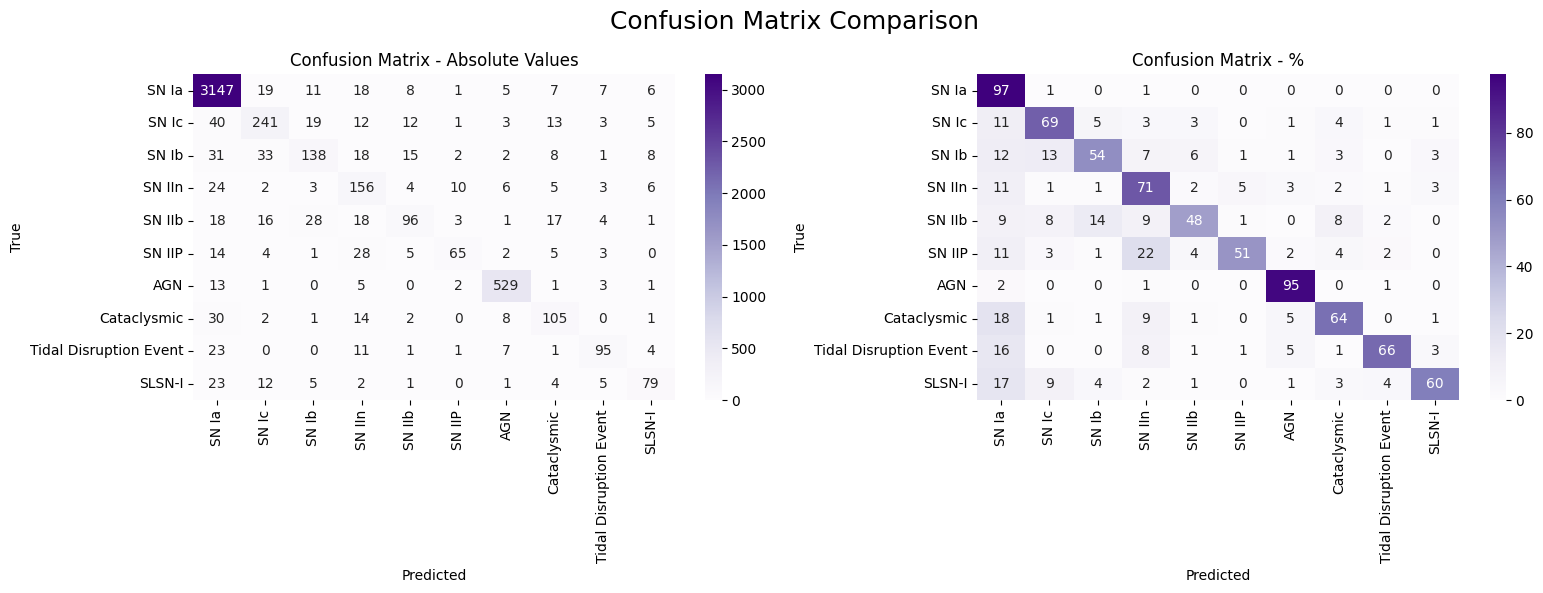

📊 [Val @ Epoch 6] Top-1 Acc: 86.53%, Top-3 Acc: 95.98%, F1: 0.6999
>>> 🚀🚀🚀 New Best Accuracy: 0.6999

[Epoch 7/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.40it/s, acc=88.4, loss=0.0217]


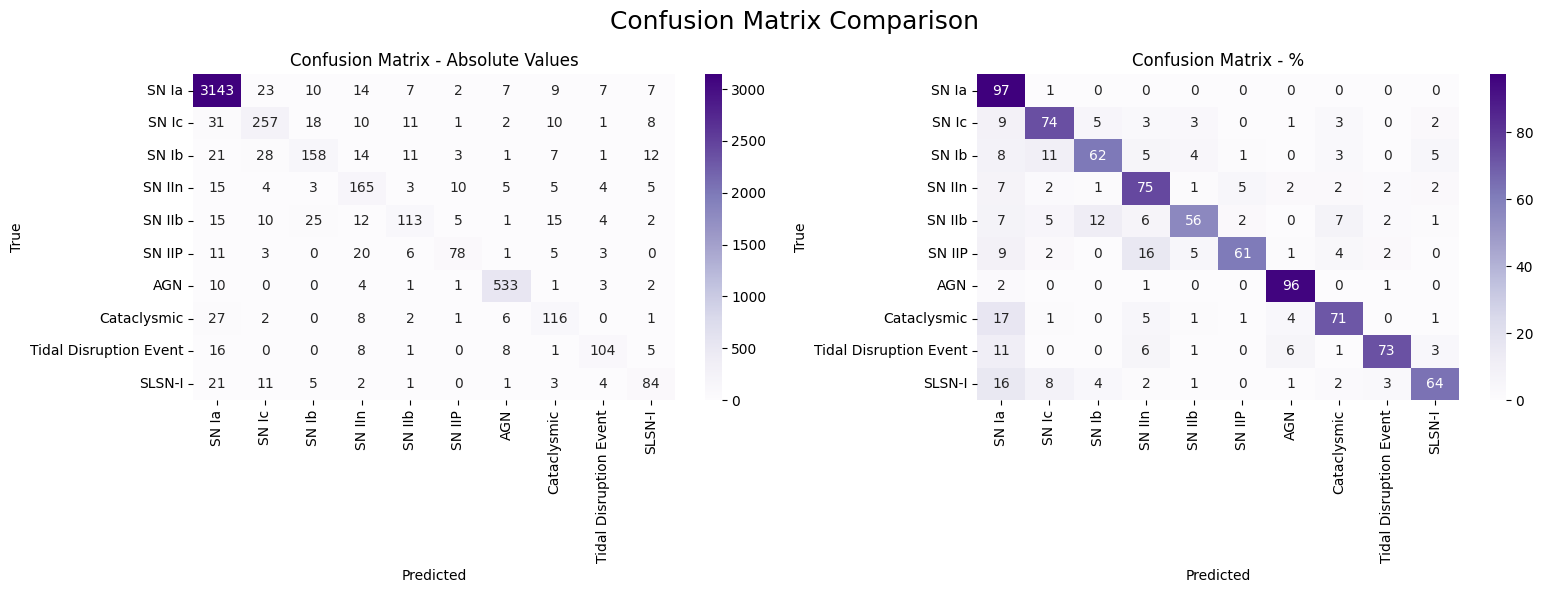

📊 [Val @ Epoch 7] Top-1 Acc: 88.39%, Top-3 Acc: 96.93%, F1: 0.7438
>>> 🚀🚀🚀 New Best Accuracy: 0.7438

[Epoch 8/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.24it/s, acc=90.1, loss=0.0187]


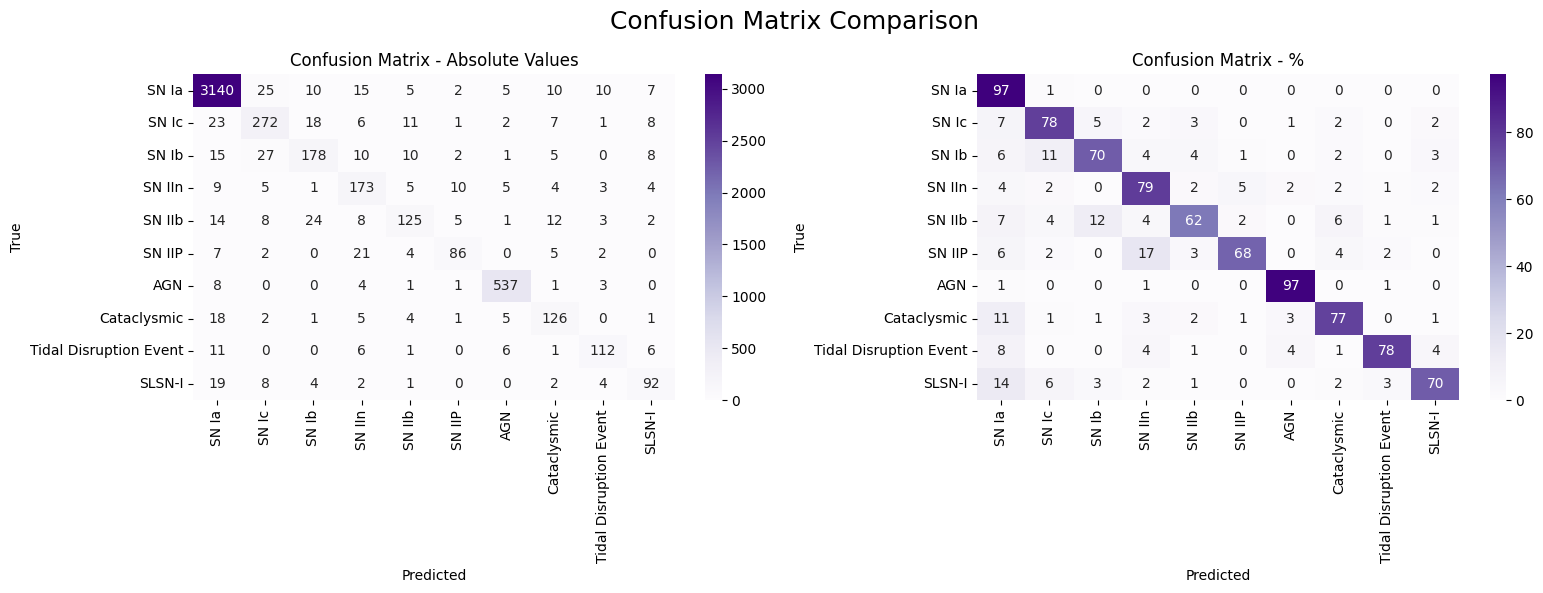

📊 [Val @ Epoch 8] Top-1 Acc: 90.07%, Top-3 Acc: 97.64%, F1: 0.7834
>>> 🚀🚀🚀 New Best Accuracy: 0.7834

[Epoch 9/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.18it/s, acc=91.6, loss=0.0168] 


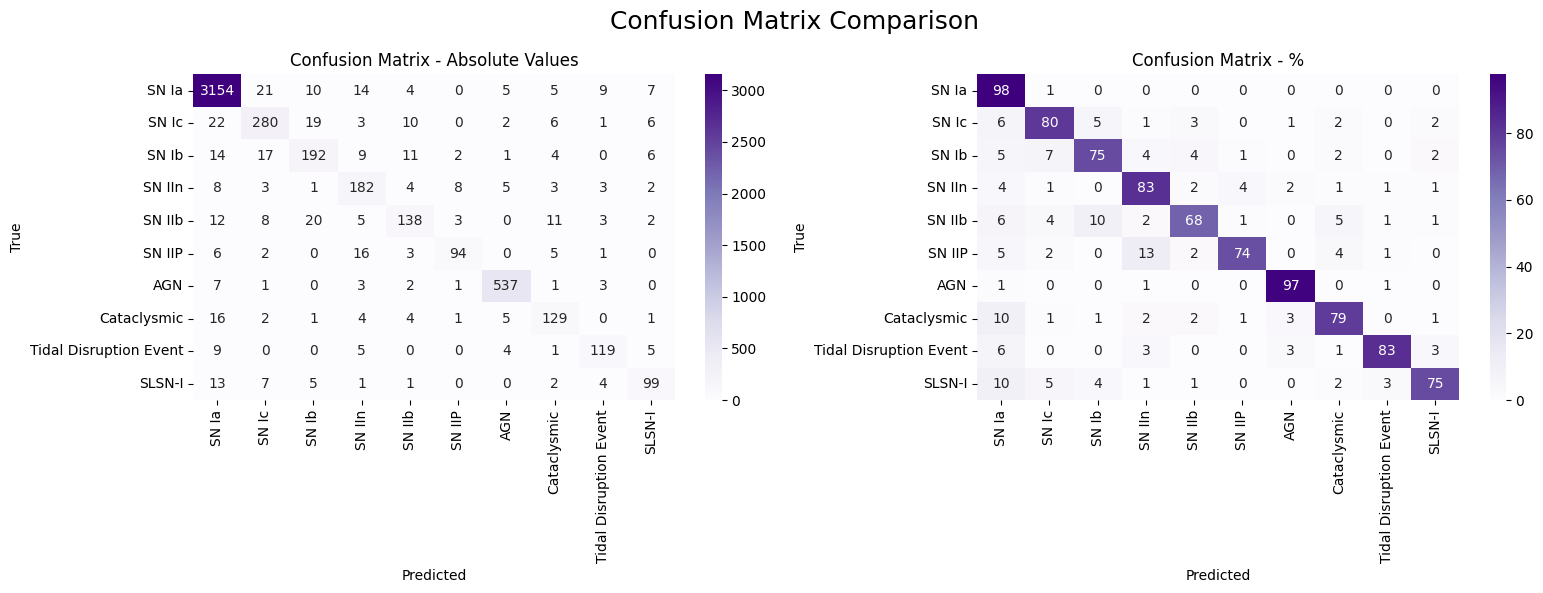

📊 [Val @ Epoch 9] Top-1 Acc: 91.61%, Top-3 Acc: 98.10%, F1: 0.8200
>>> 🚀🚀🚀 New Best Accuracy: 0.8200

[Epoch 10/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.35it/s, acc=92.8, loss=0.0147] 


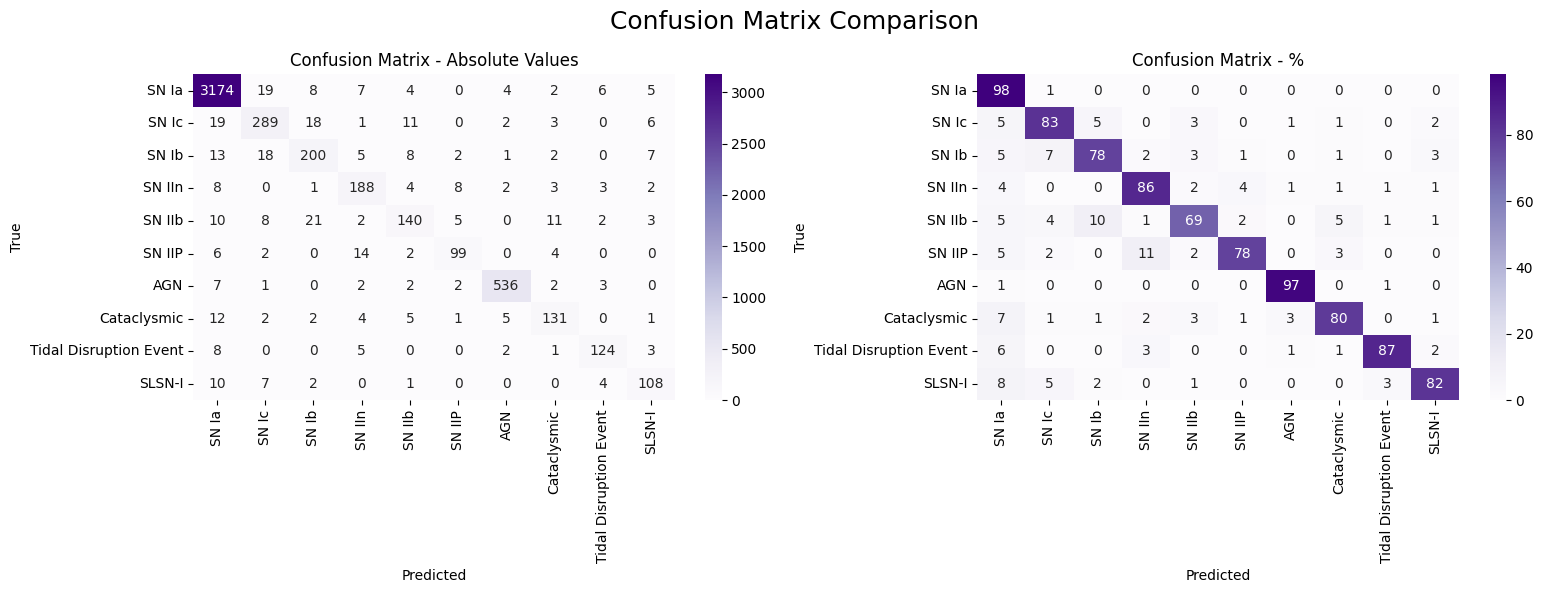

📊 [Val @ Epoch 10] Top-1 Acc: 92.82%, Top-3 Acc: 98.40%, F1: 0.8449
>>> 🚀🚀🚀 New Best Accuracy: 0.8449

[Epoch 11/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.85it/s, acc=93.6, loss=0.0132] 


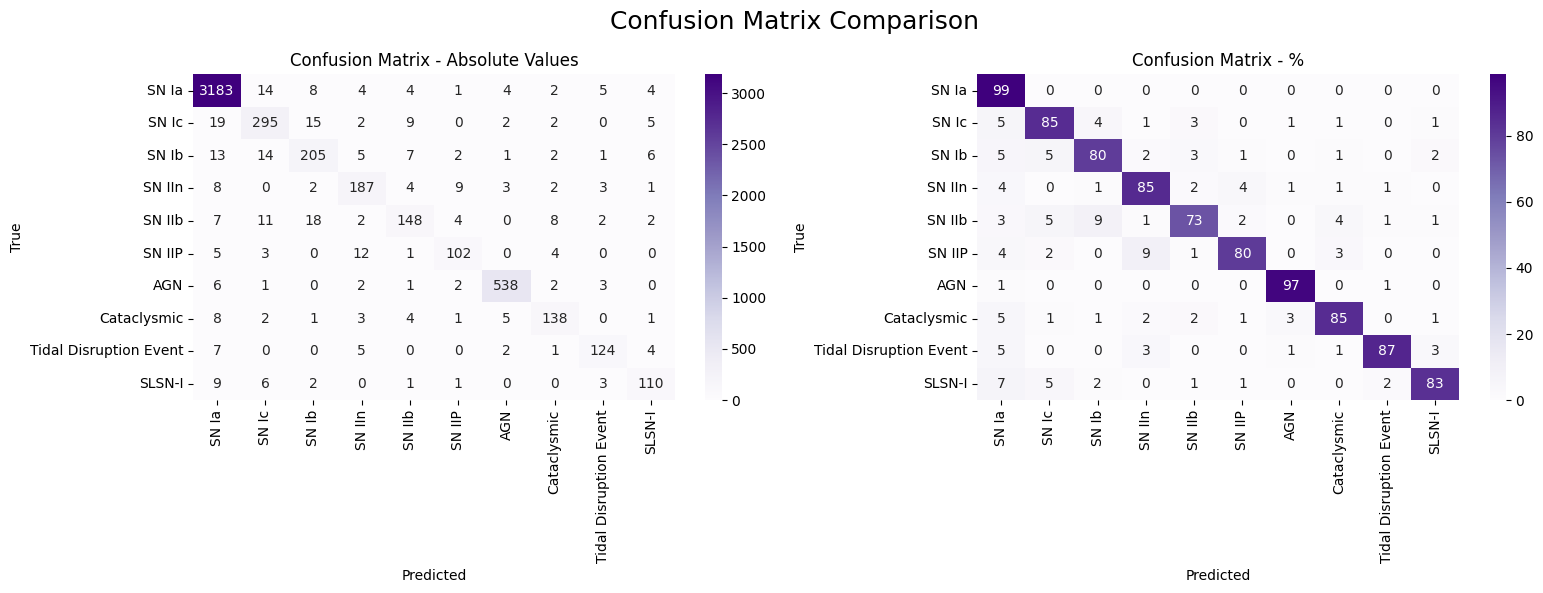

📊 [Val @ Epoch 11] Top-1 Acc: 93.58%, Top-3 Acc: 98.42%, F1: 0.8607
>>> 🚀🚀🚀 New Best Accuracy: 0.8607

[Epoch 12/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.96it/s, acc=94.1, loss=0.013]  


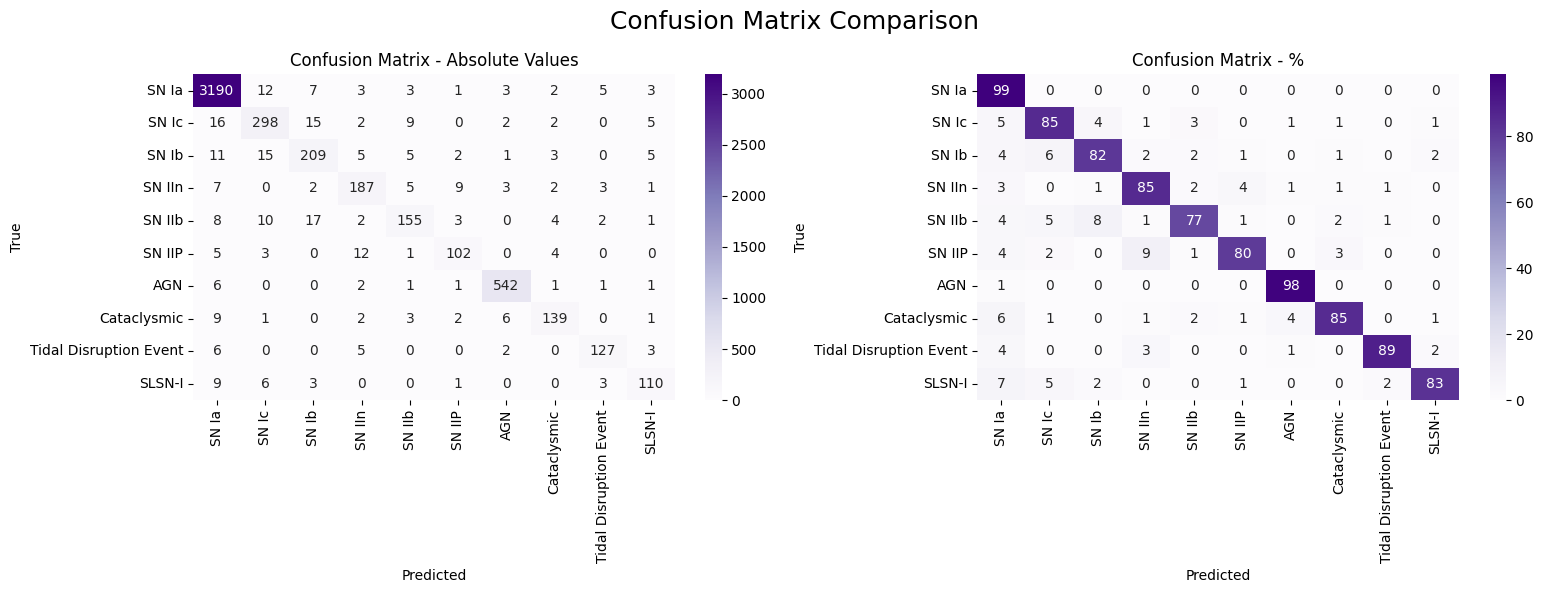

📊 [Val @ Epoch 12] Top-1 Acc: 94.12%, Top-3 Acc: 98.53%, F1: 0.8720
>>> 🚀🚀🚀 New Best Accuracy: 0.8720

[Epoch 13/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 19.00it/s, acc=94.4, loss=0.0124] 


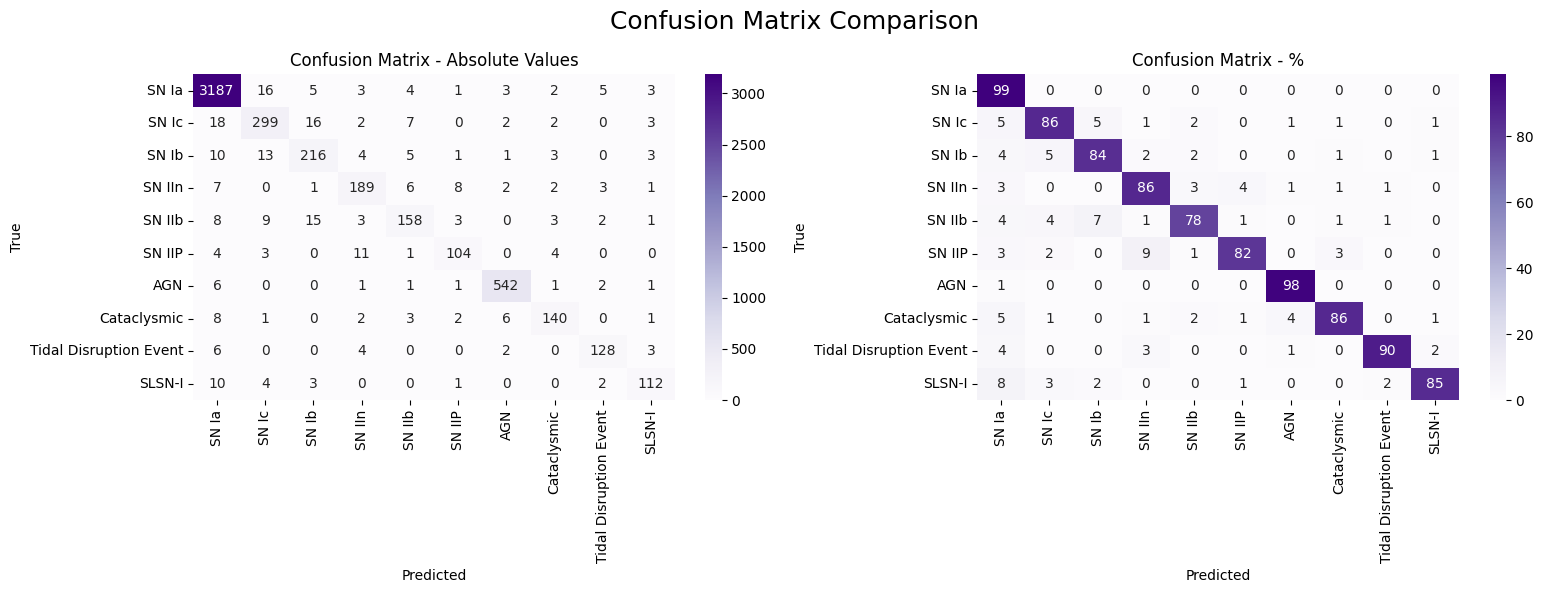

📊 [Val @ Epoch 13] Top-1 Acc: 94.42%, Top-3 Acc: 98.62%, F1: 0.8814
>>> 🚀🚀🚀 New Best Accuracy: 0.8814

[Epoch 14/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.94it/s, acc=94.7, loss=0.0124] 


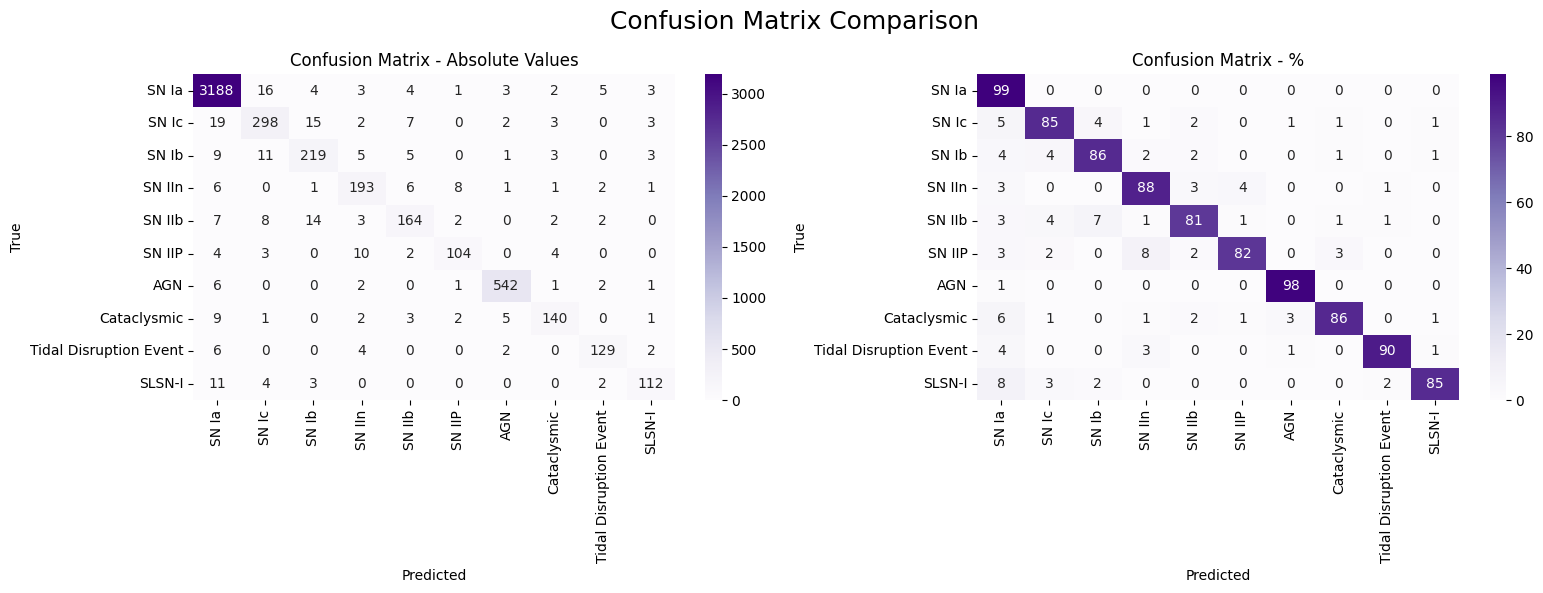

📊 [Val @ Epoch 14] Top-1 Acc: 94.68%, Top-3 Acc: 98.64%, F1: 0.8883
>>> 🚀🚀🚀 New Best Accuracy: 0.8883

[Epoch 15/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.29it/s, acc=94.7, loss=0.0126] 


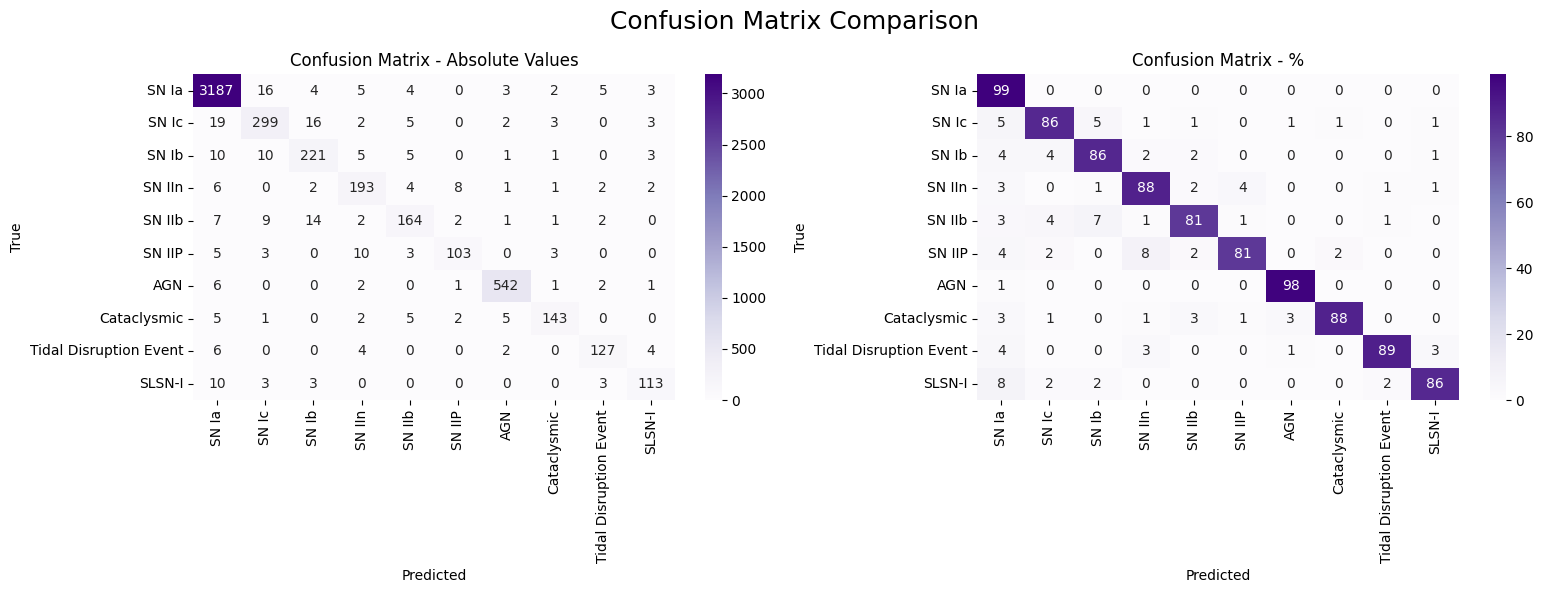

📊 [Val @ Epoch 15] Top-1 Acc: 94.73%, Top-3 Acc: 98.62%, F1: 0.8894
>>> 🚀🚀🚀 New Best Accuracy: 0.8894

[Epoch 16/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.23it/s, acc=94.9, loss=0.0131] 


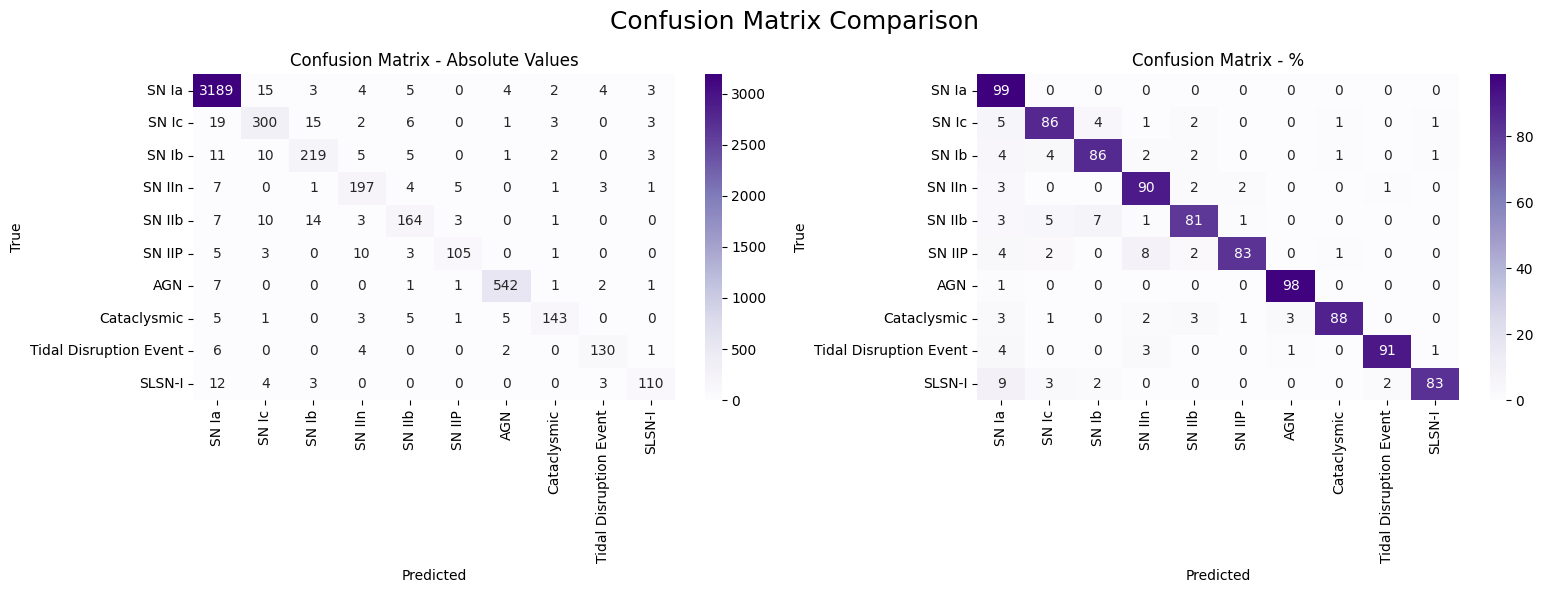

📊 [Val @ Epoch 16] Top-1 Acc: 94.87%, Top-3 Acc: 98.66%, F1: 0.8943
>>> 🚀🚀🚀 New Best Accuracy: 0.8943

[Epoch 17/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.46it/s, acc=94.9, loss=0.0136] 


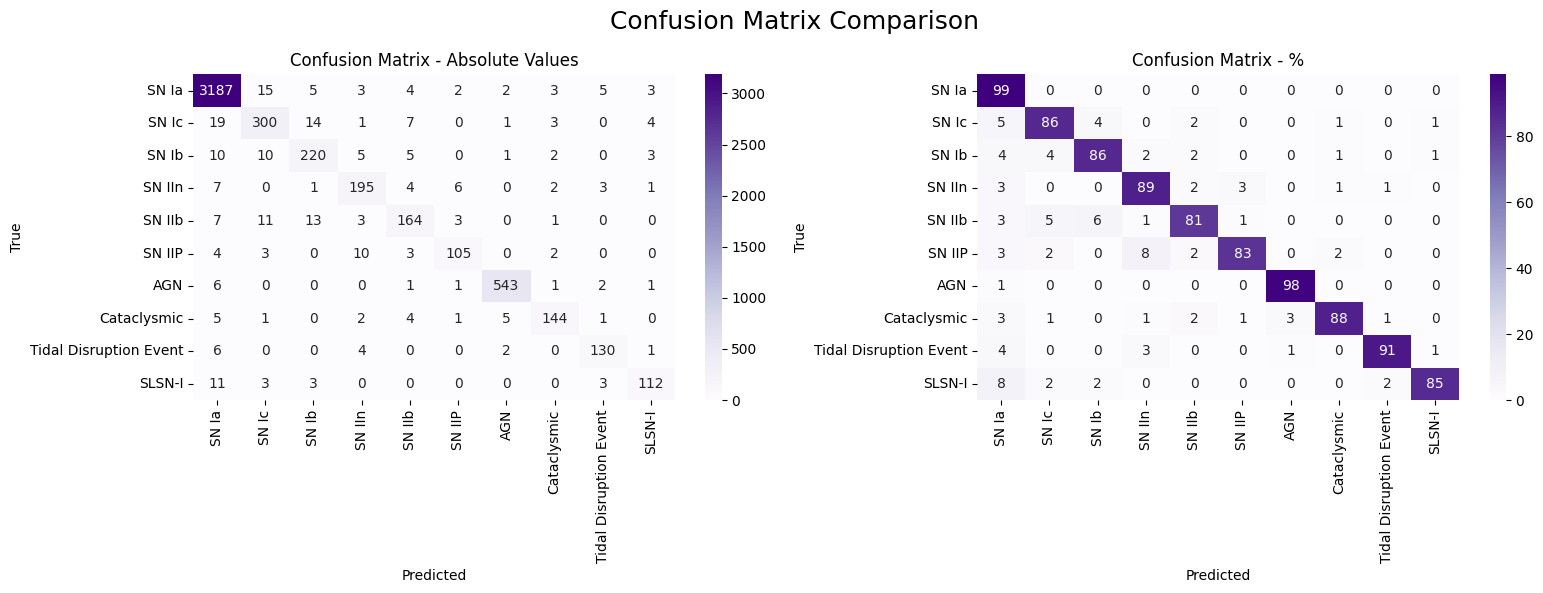

📊 [Val @ Epoch 17] Top-1 Acc: 94.88%, Top-3 Acc: 98.79%, F1: 0.8934
>>> No F1 improvement for 1 epoch(s)

[Epoch 18/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.28it/s, acc=95.1, loss=0.013]  


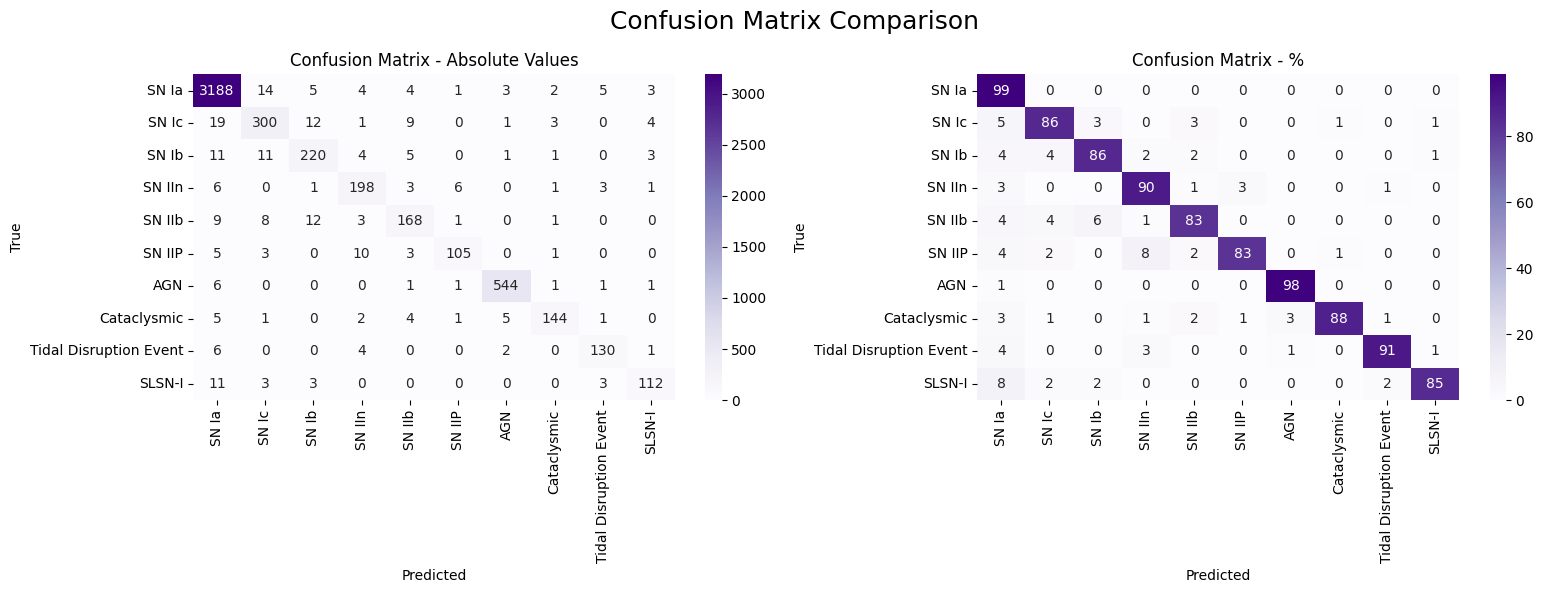

📊 [Val @ Epoch 18] Top-1 Acc: 95.05%, Top-3 Acc: 98.79%, F1: 0.8985
>>> 🚀🚀🚀 New Best Accuracy: 0.8985

[Epoch 19/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.54it/s, acc=95.1, loss=0.0122] 


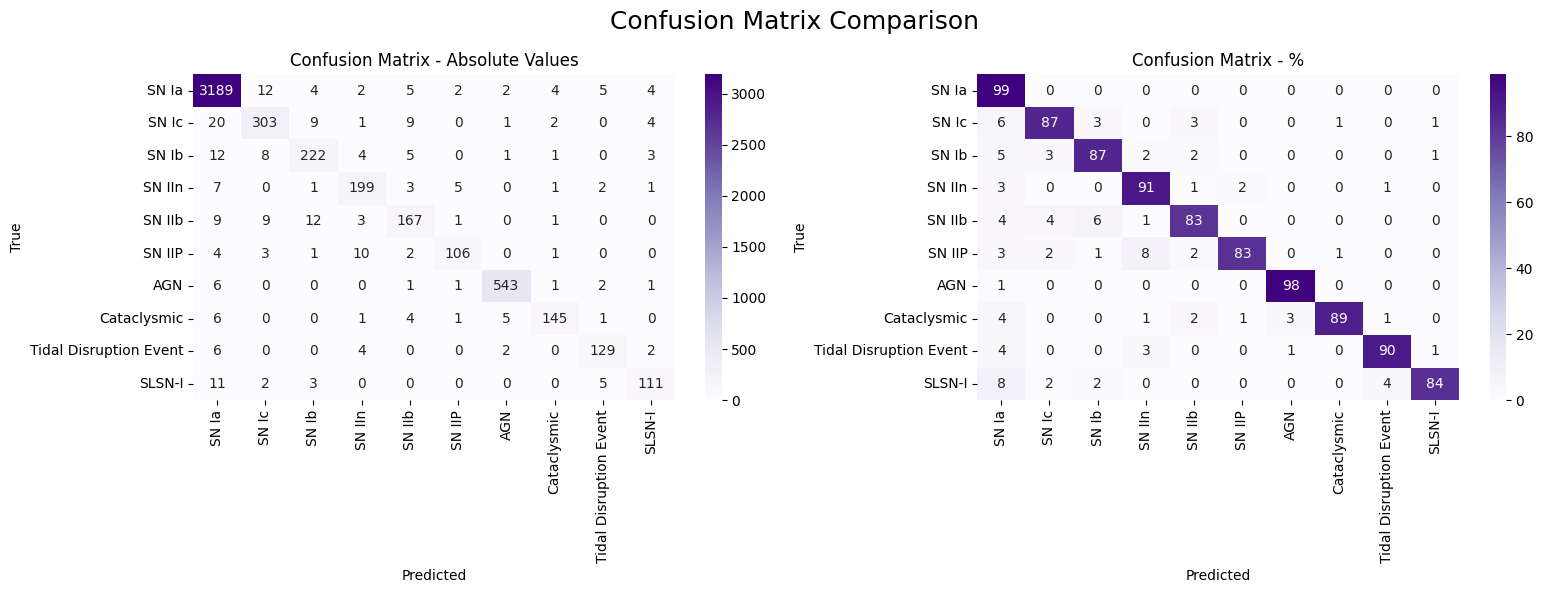

📊 [Val @ Epoch 19] Top-1 Acc: 95.14%, Top-3 Acc: 98.70%, F1: 0.8997
>>> 🚀🚀🚀 New Best Accuracy: 0.8997

[Epoch 20/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.39it/s, acc=95.1, loss=0.0116] 


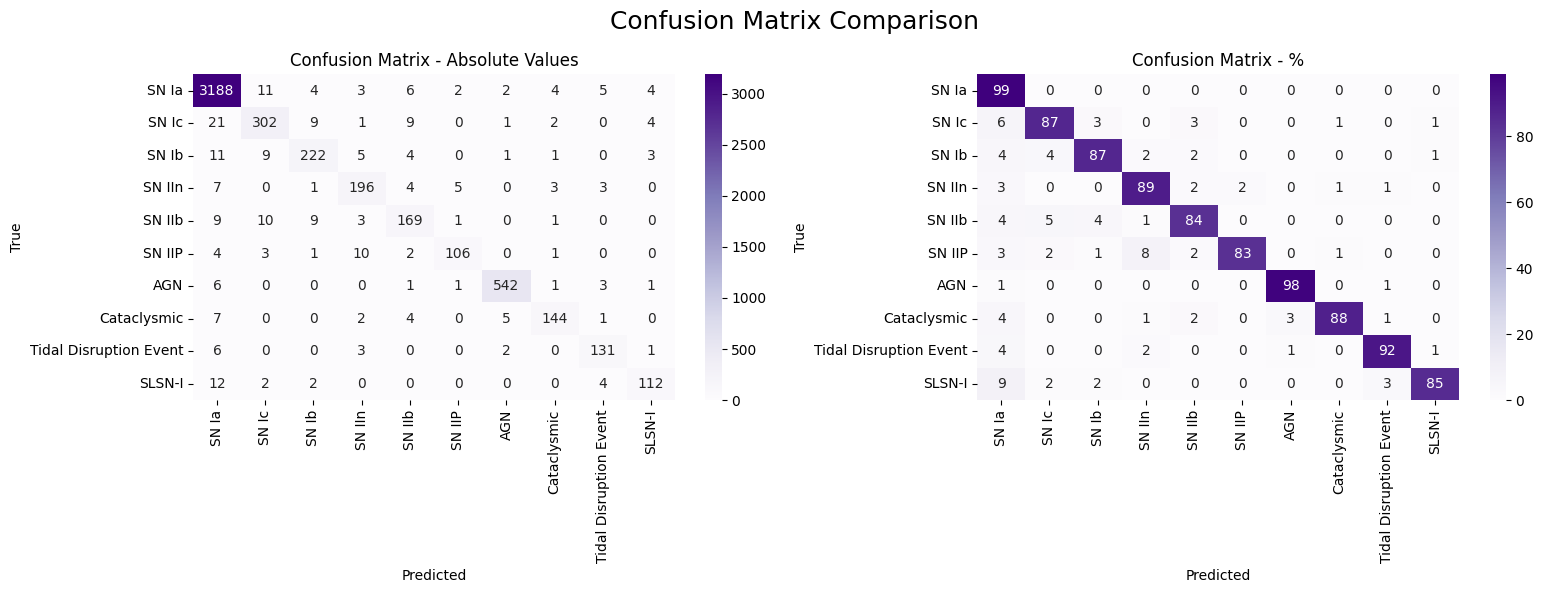

📊 [Val @ Epoch 20] Top-1 Acc: 95.11%, Top-3 Acc: 98.73%, F1: 0.9002
>>> 🚀🚀🚀 New Best Accuracy: 0.9002

[Epoch 21/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 19.06it/s, acc=95.1, loss=0.0117] 


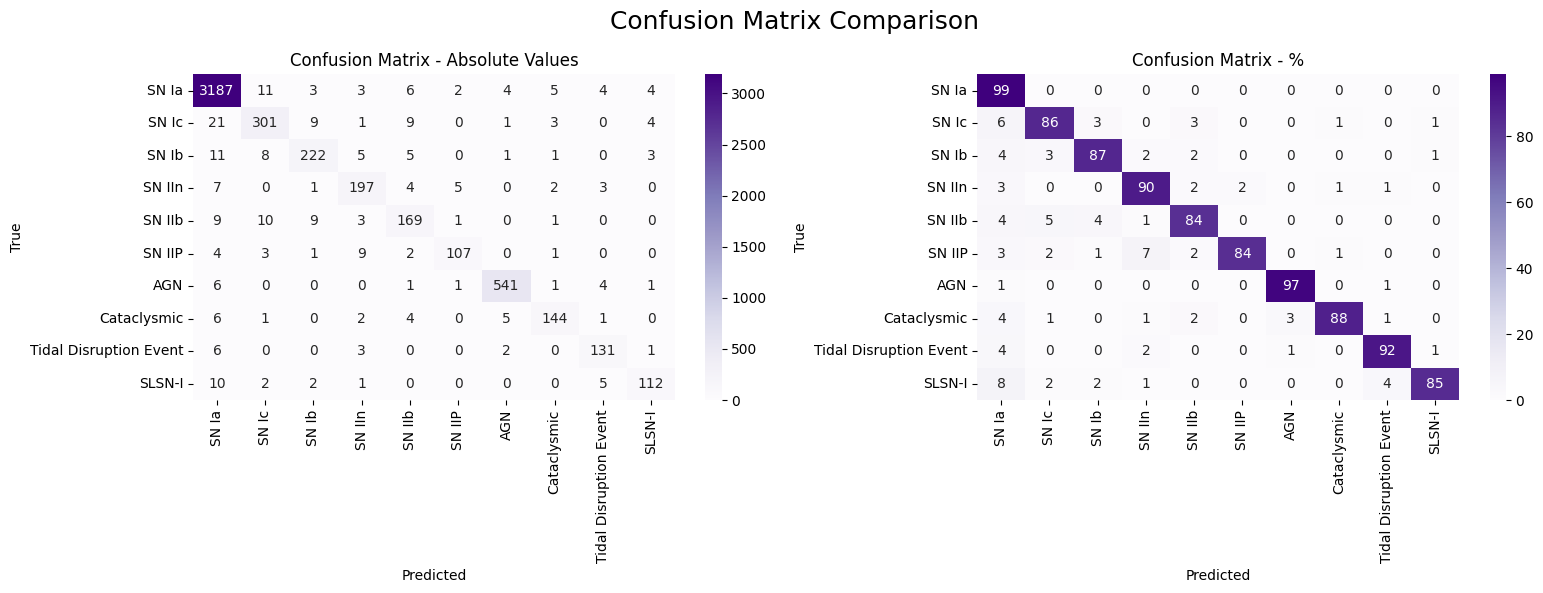

📊 [Val @ Epoch 21] Top-1 Acc: 95.09%, Top-3 Acc: 98.79%, F1: 0.8998
>>> No F1 improvement for 1 epoch(s)

[Epoch 22/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 19.03it/s, acc=95.2, loss=0.0116] 


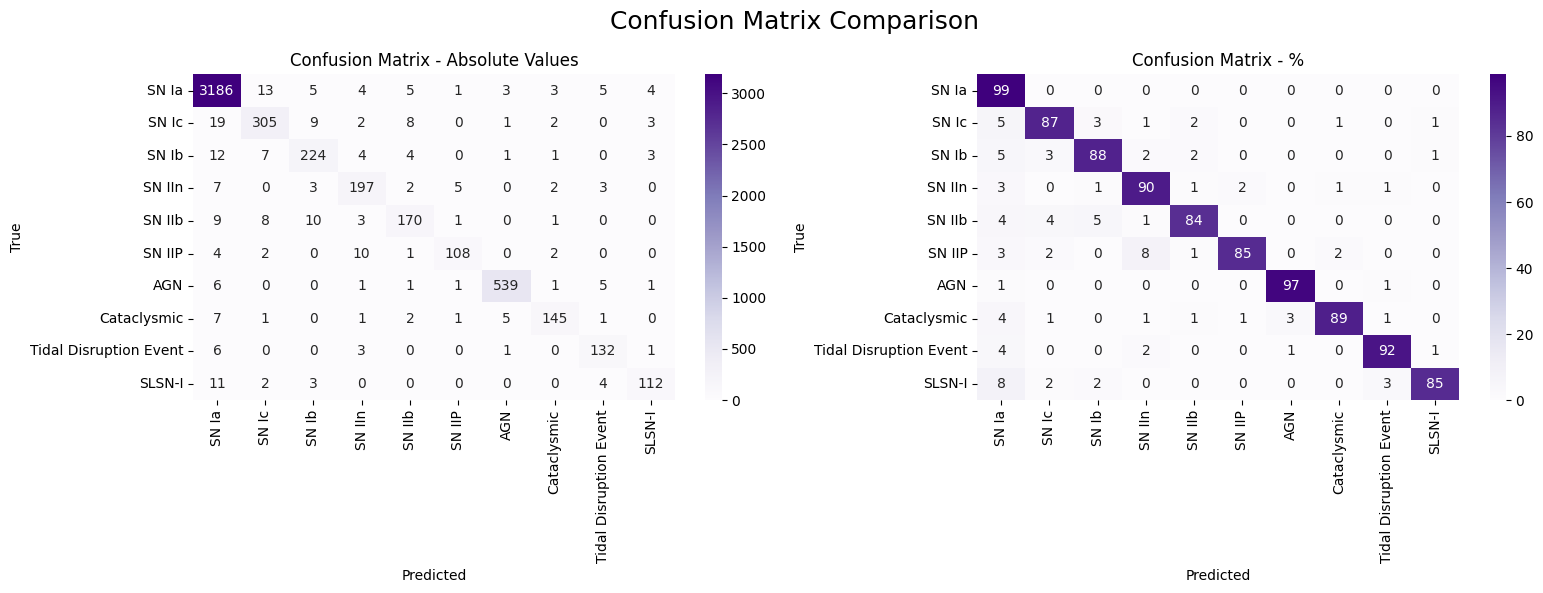

📊 [Val @ Epoch 22] Top-1 Acc: 95.22%, Top-3 Acc: 98.83%, F1: 0.9038
>>> 🚀🚀🚀 New Best Accuracy: 0.9038

[Epoch 23/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.04it/s, acc=95.2, loss=0.0118] 


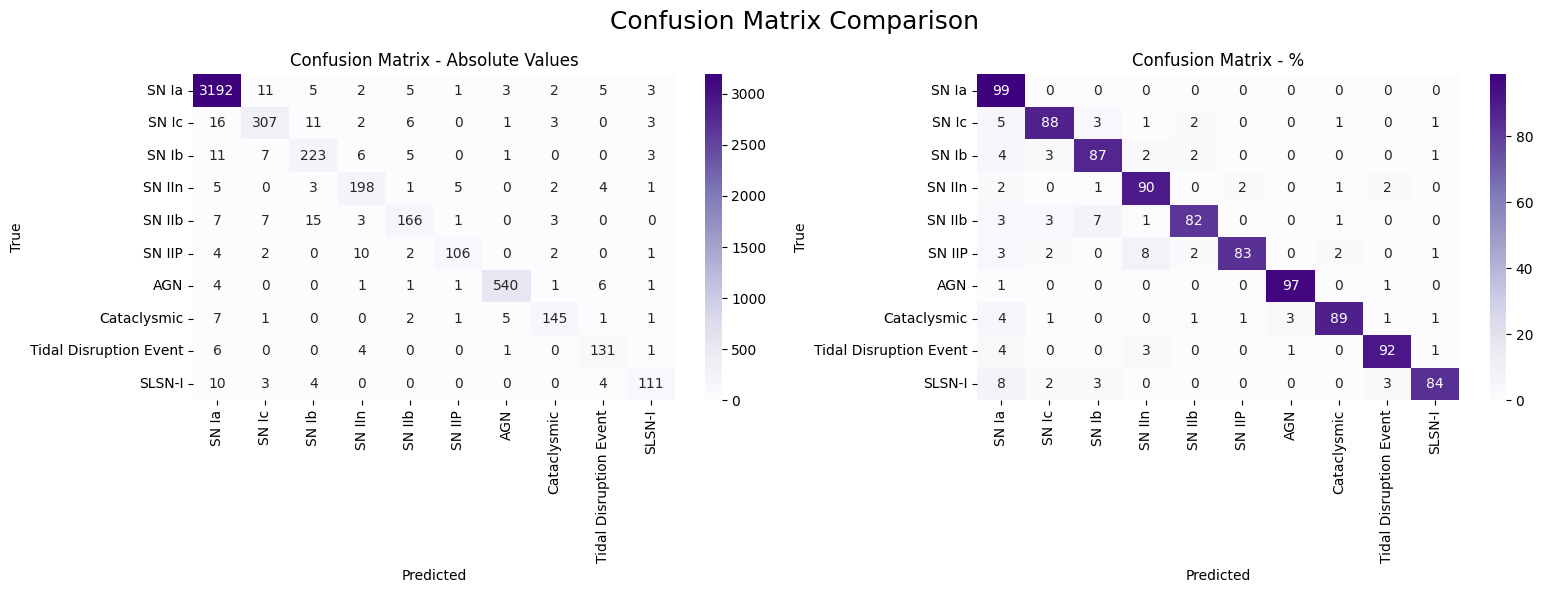

📊 [Val @ Epoch 23] Top-1 Acc: 95.24%, Top-3 Acc: 98.83%, F1: 0.8992
>>> No F1 improvement for 1 epoch(s)

[Epoch 24/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.67it/s, acc=95.3, loss=0.0115] 


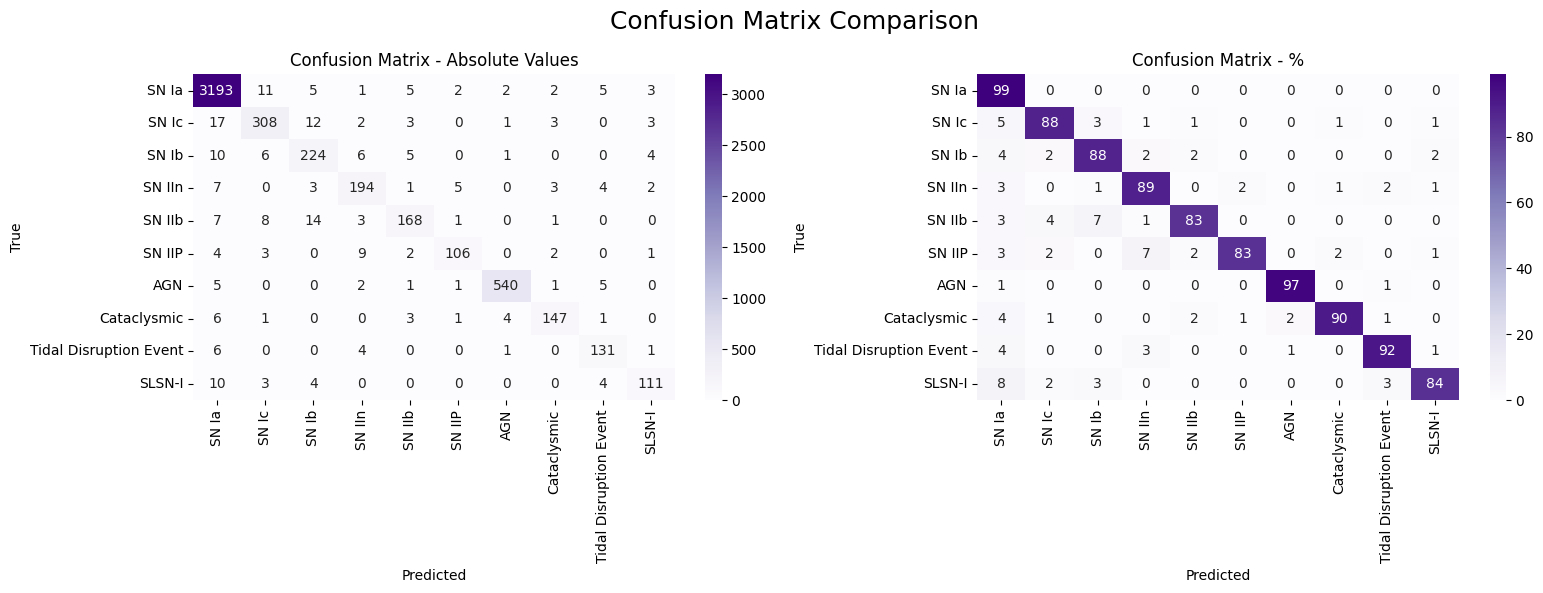

📊 [Val @ Epoch 24] Top-1 Acc: 95.29%, Top-3 Acc: 98.77%, F1: 0.9007
>>> No F1 improvement for 2 epoch(s)

[Epoch 25/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.85it/s, acc=95.1, loss=0.0116] 


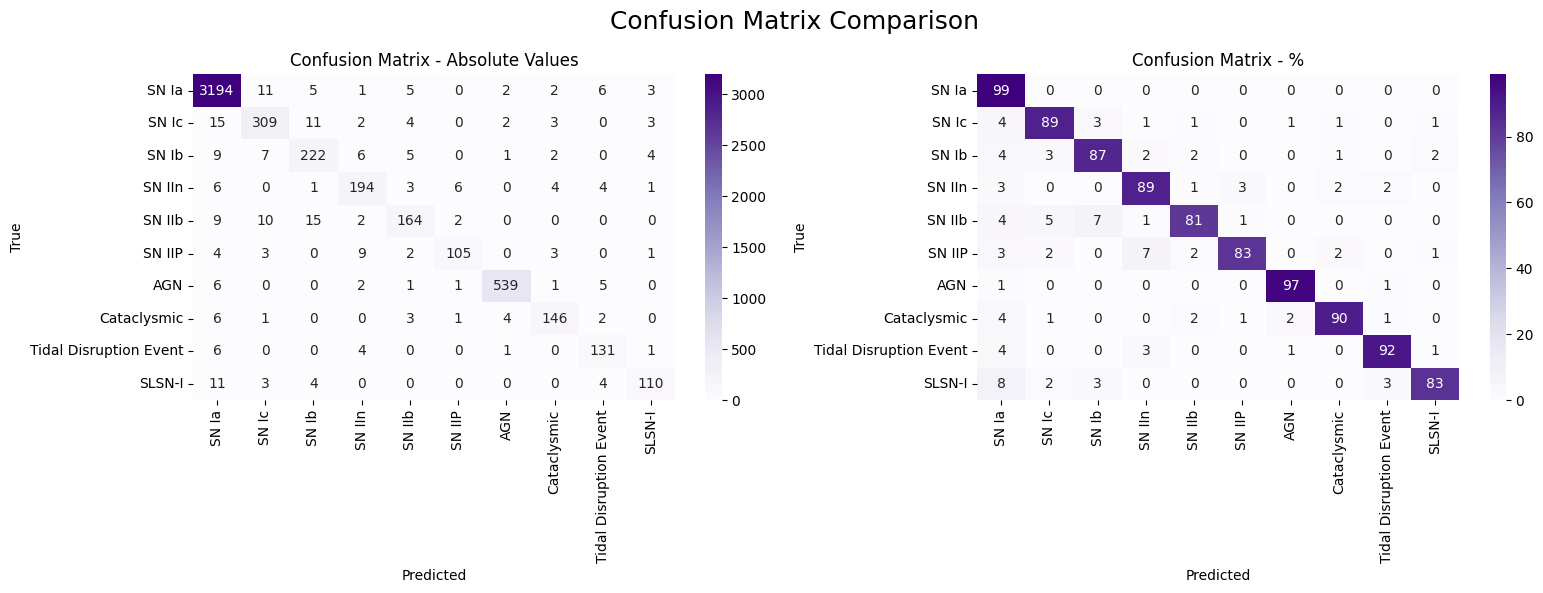

📊 [Val @ Epoch 25] Top-1 Acc: 95.14%, Top-3 Acc: 98.77%, F1: 0.8962
>>> No F1 improvement for 3 epoch(s)

[Epoch 26/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.88it/s, acc=95.2, loss=0.0121] 


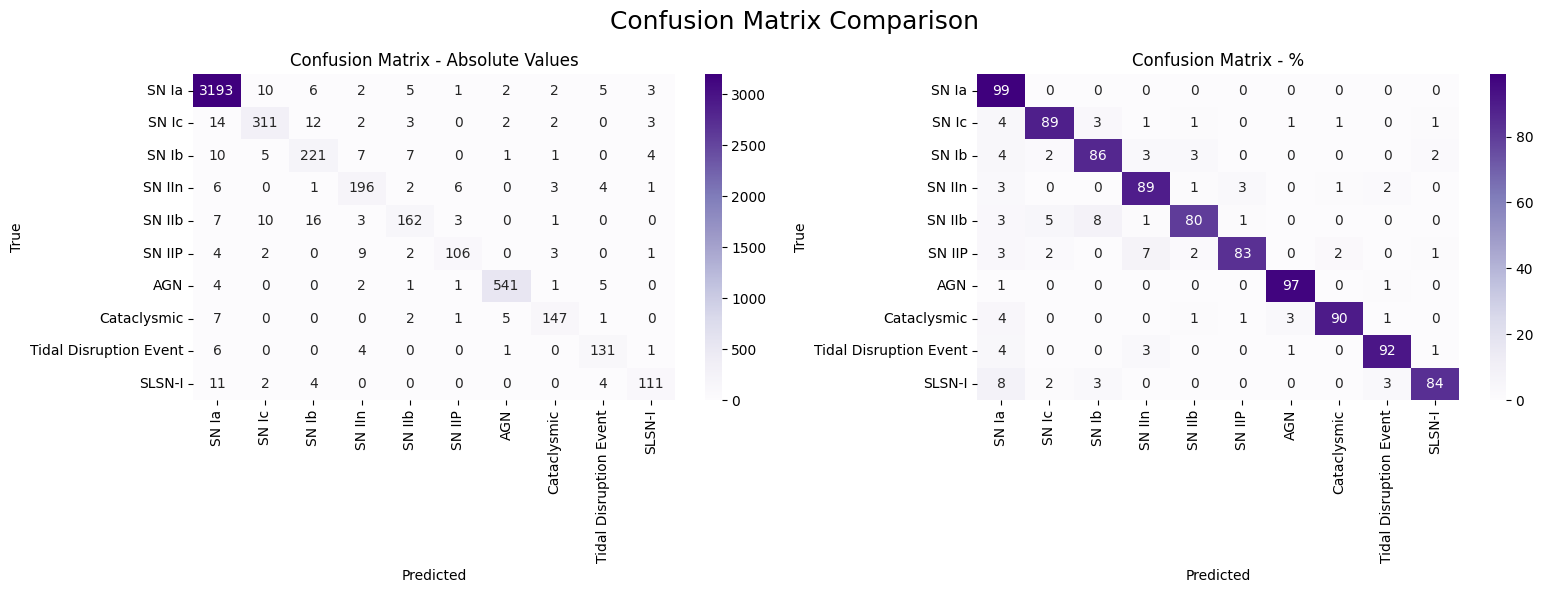

📊 [Val @ Epoch 26] Top-1 Acc: 95.24%, Top-3 Acc: 98.75%, F1: 0.8980
>>> No F1 improvement for 4 epoch(s)

[Epoch 27/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.86it/s, acc=95.2, loss=0.0131] 


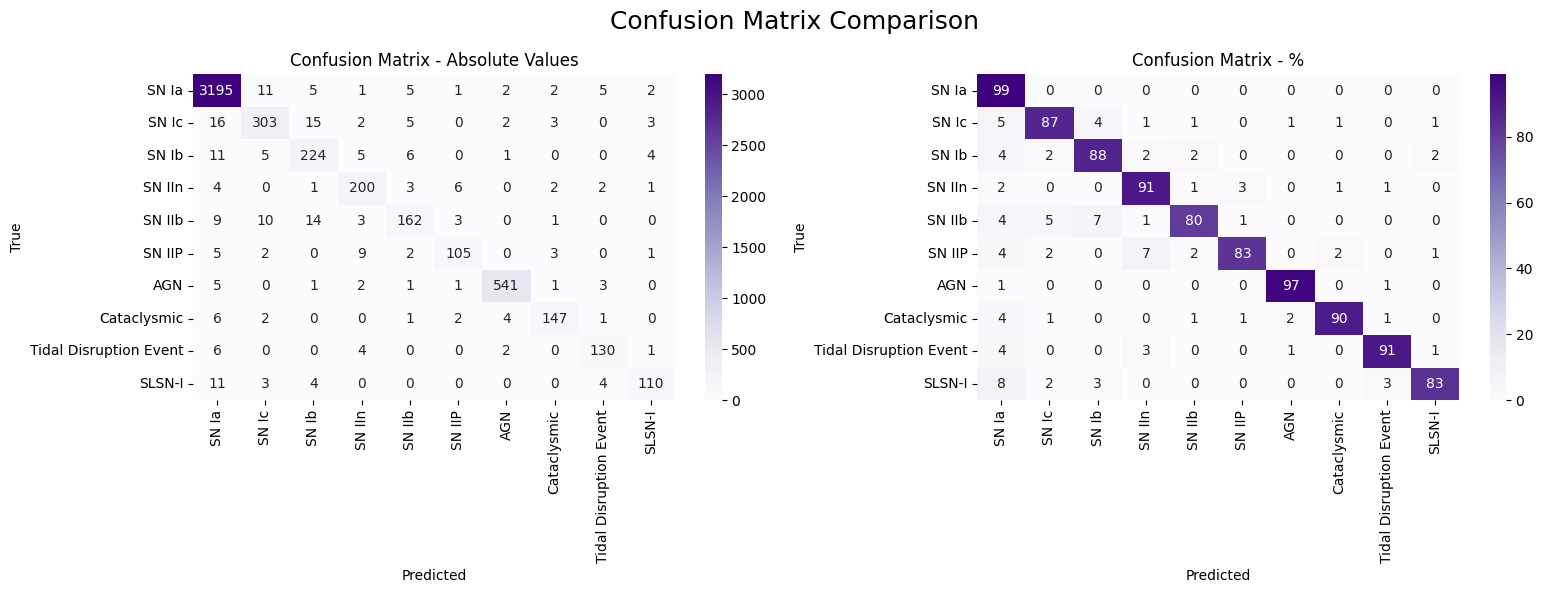

📊 [Val @ Epoch 27] Top-1 Acc: 95.20%, Top-3 Acc: 98.79%, F1: 0.8982
>>> No F1 improvement for 5 epoch(s)
>>> Early stopping triggered based on composite score.
Best F1 on Validate dataset: 0.9038

>>> Final Testing on Test Set...


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.23it/s, acc=95, loss=0.0104]   


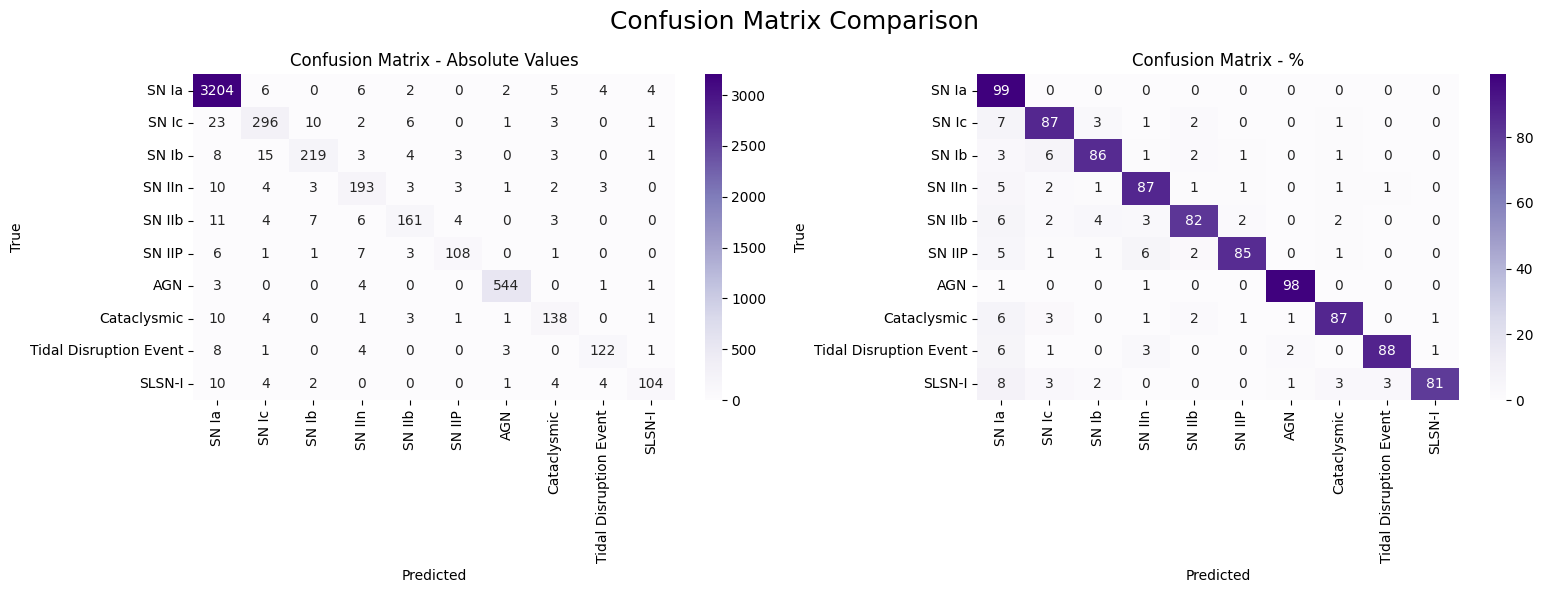


[TEST] Macro ROC-AUC: 0.9953


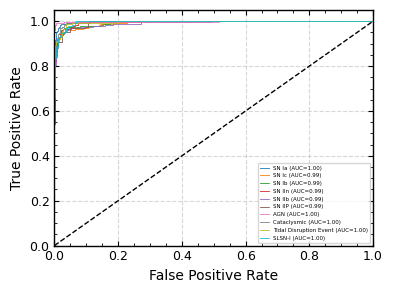

[TEST] ROC curve saved to: c:\Users\Administrator\Desktop\SpectraNet-SN\record
>>> Test Loss: 0.0123, Acc: 95.01%, F1: 0.8932, Top-3 Acc: 98.56%, Composite: 0.9437

=== Running seed 777 (2/3) ===

[Epoch 1/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.38it/s, acc=4.32, loss=0.174]


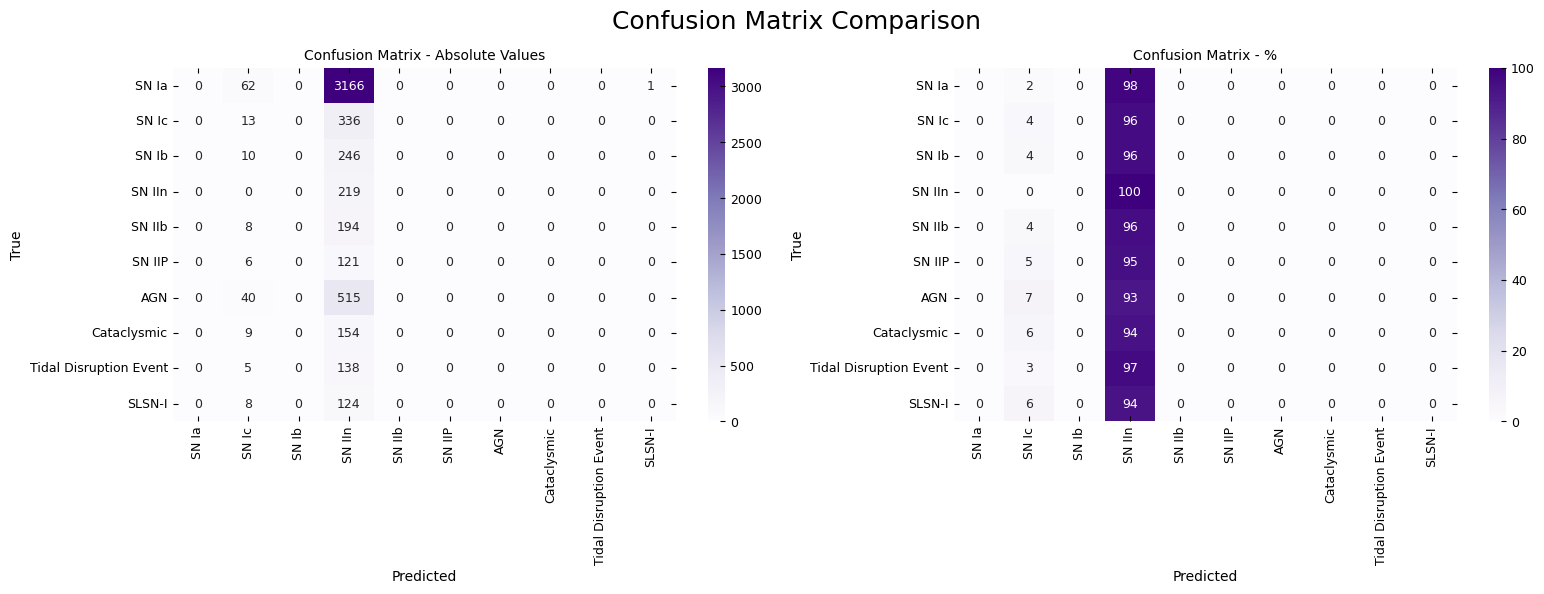

📊 [Val @ Epoch 1] Top-1 Acc: 4.32%, Top-3 Acc: 18.94%, F1: 0.0132
>>> 🚀🚀🚀 New Best Accuracy: 0.0132

[Epoch 2/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.69it/s, acc=65.5, loss=0.0916]


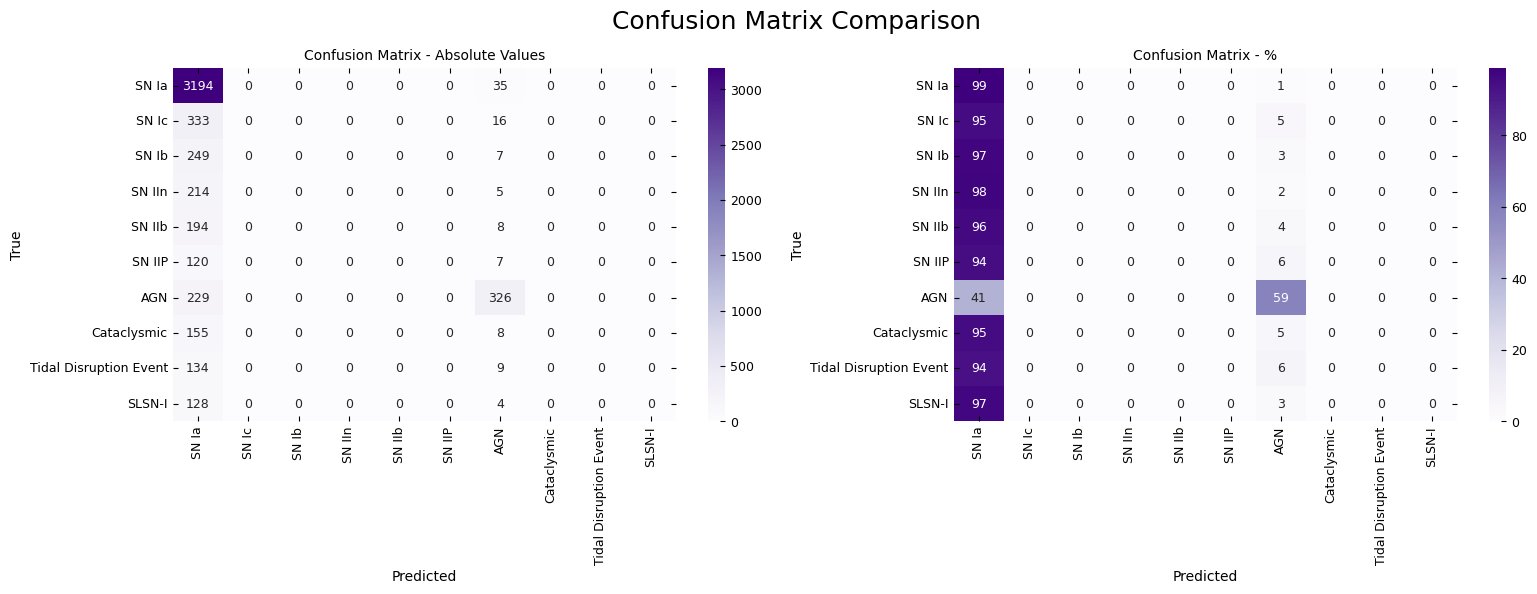

📊 [Val @ Epoch 2] Top-1 Acc: 65.49%, Top-3 Acc: 80.97%, F1: 0.1446
>>> 🚀🚀🚀 New Best Accuracy: 0.1446

[Epoch 3/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.82it/s, acc=69.7, loss=0.0646]


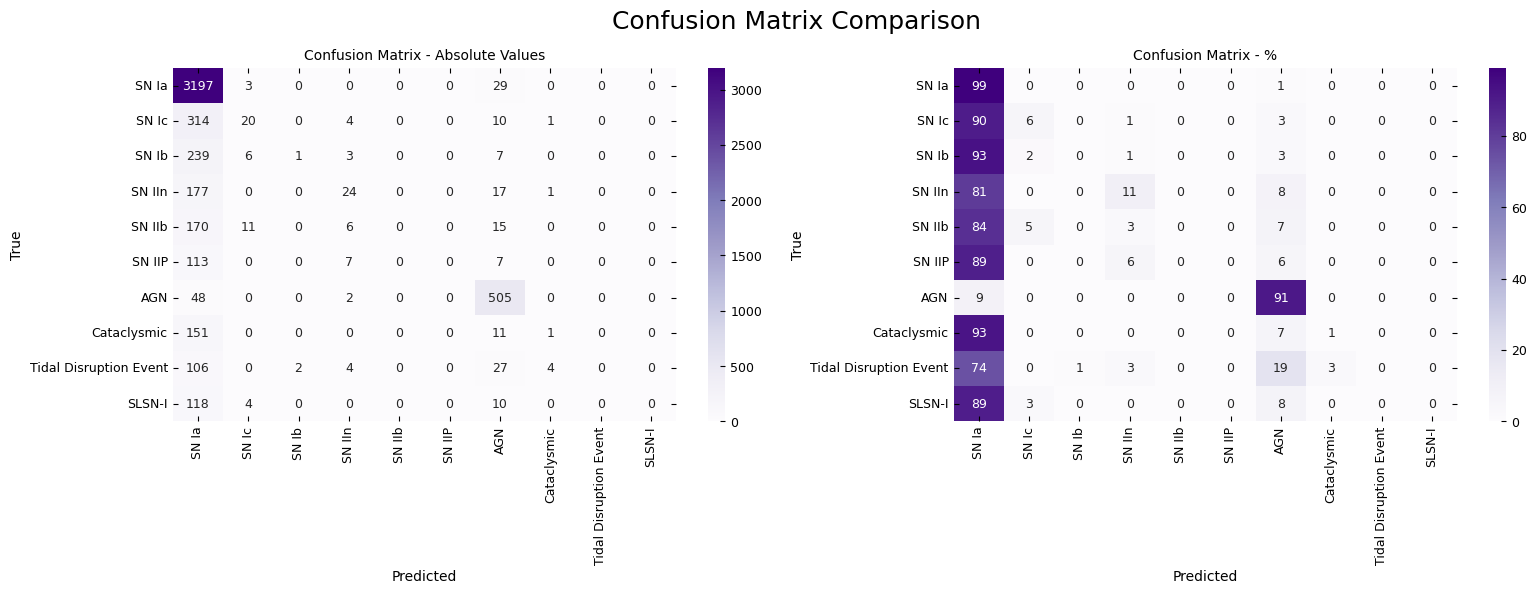

📊 [Val @ Epoch 3] Top-1 Acc: 69.73%, Top-3 Acc: 85.41%, F1: 0.1960
>>> 🚀🚀🚀 New Best Accuracy: 0.1960

[Epoch 4/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.83it/s, acc=78, loss=0.0434]  


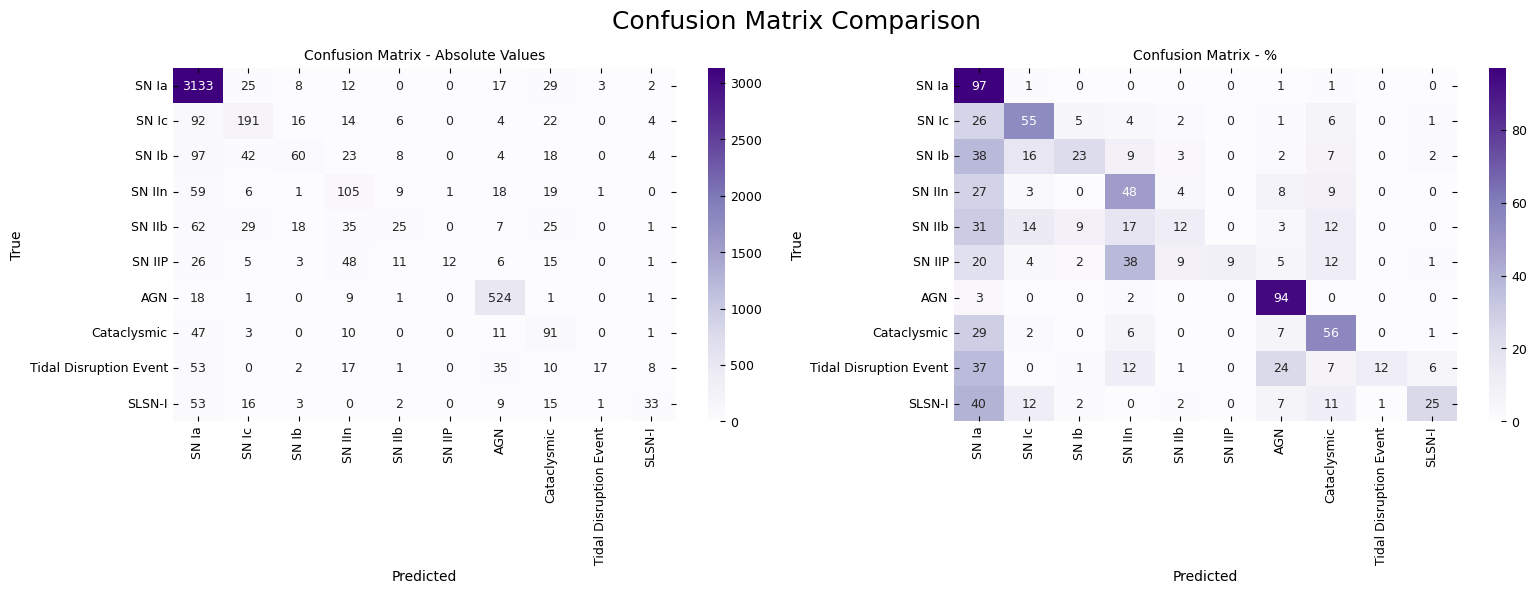

📊 [Val @ Epoch 4] Top-1 Acc: 77.97%, Top-3 Acc: 90.92%, F1: 0.4485
>>> 🚀🚀🚀 New Best Accuracy: 0.4485

[Epoch 5/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.60it/s, acc=83.1, loss=0.0325]


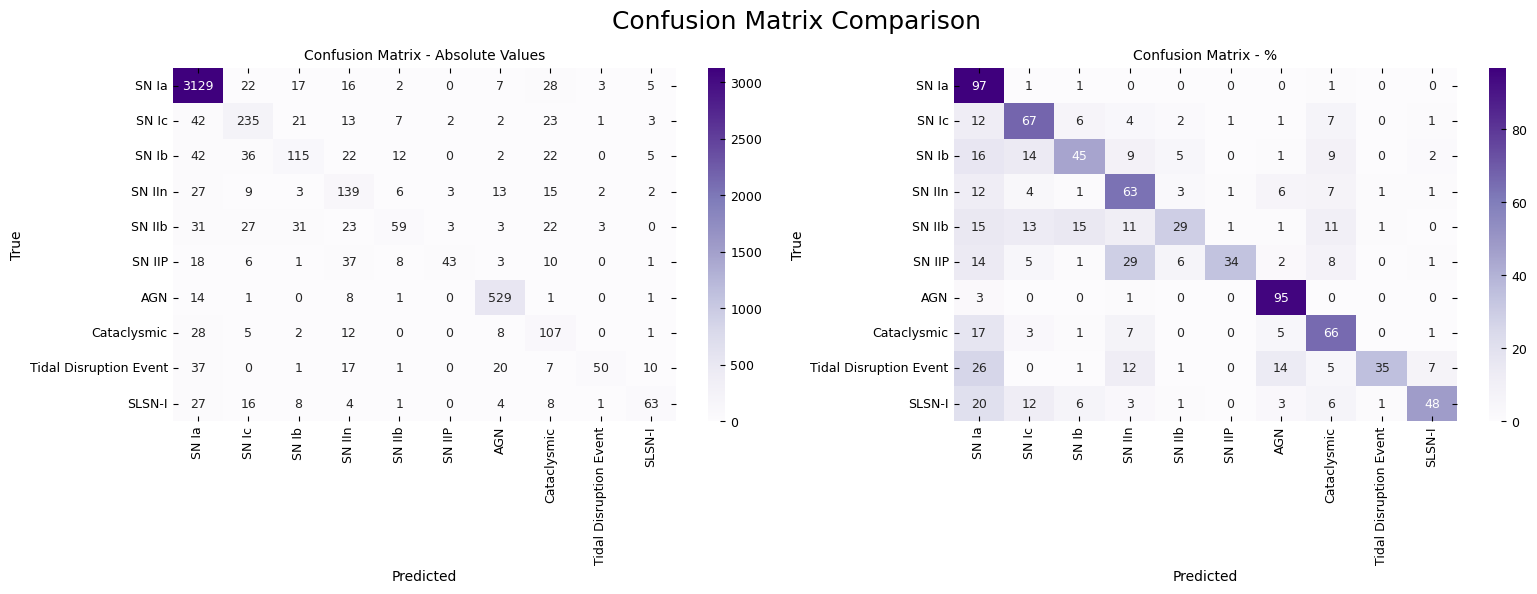

📊 [Val @ Epoch 5] Top-1 Acc: 83.14%, Top-3 Acc: 93.95%, F1: 0.6047
>>> 🚀🚀🚀 New Best Accuracy: 0.6047

[Epoch 6/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.53it/s, acc=86.3, loss=0.0257]


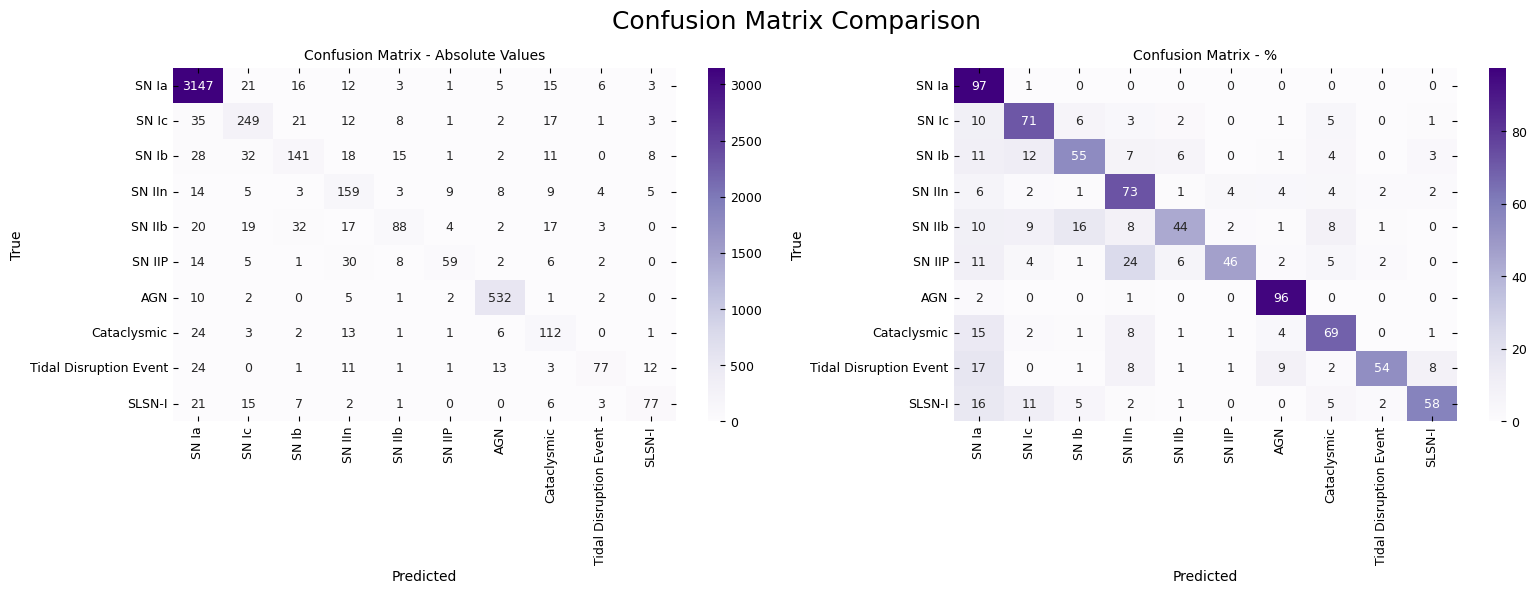

📊 [Val @ Epoch 6] Top-1 Acc: 86.34%, Top-3 Acc: 95.78%, F1: 0.6845
>>> 🚀🚀🚀 New Best Accuracy: 0.6845

[Epoch 7/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.84it/s, acc=88.3, loss=0.0217]


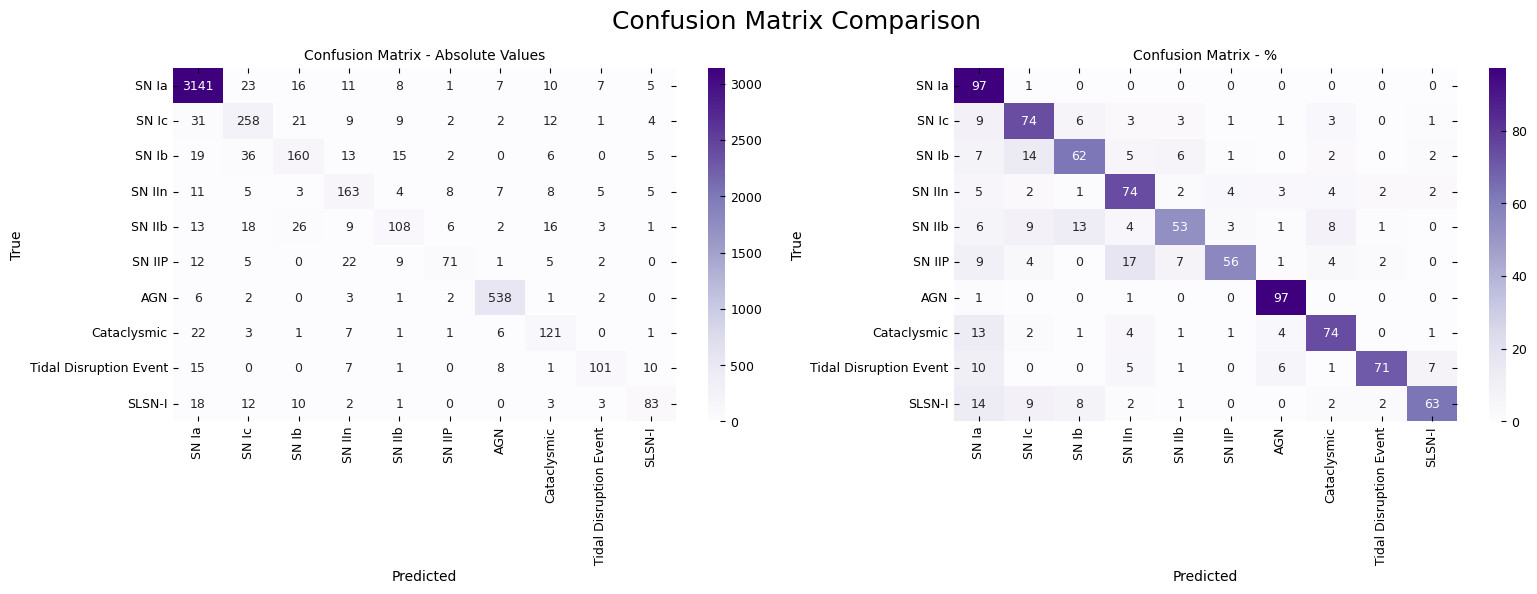

📊 [Val @ Epoch 7] Top-1 Acc: 88.26%, Top-3 Acc: 96.71%, F1: 0.7373
>>> 🚀🚀🚀 New Best Accuracy: 0.7373

[Epoch 8/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.36it/s, acc=89.9, loss=0.0186]


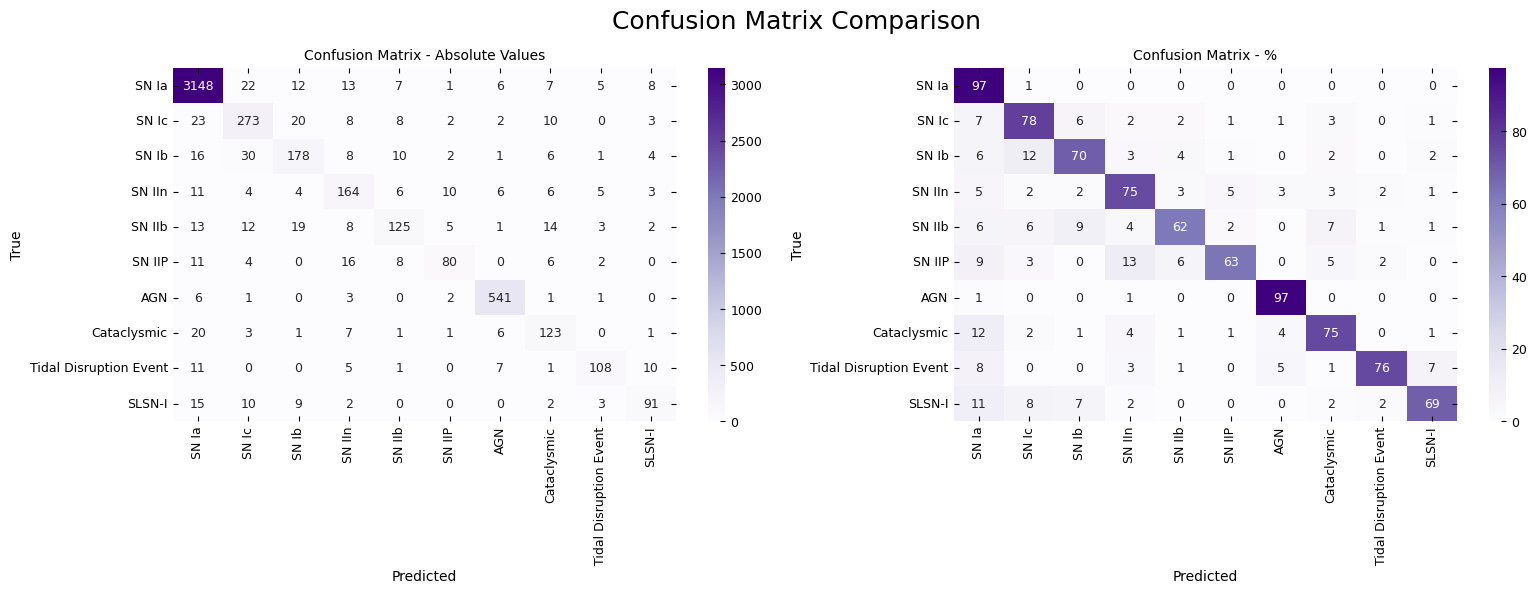

📊 [Val @ Epoch 8] Top-1 Acc: 89.88%, Top-3 Acc: 97.40%, F1: 0.7753
>>> 🚀🚀🚀 New Best Accuracy: 0.7753

[Epoch 9/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.27it/s, acc=91.1, loss=0.016]  


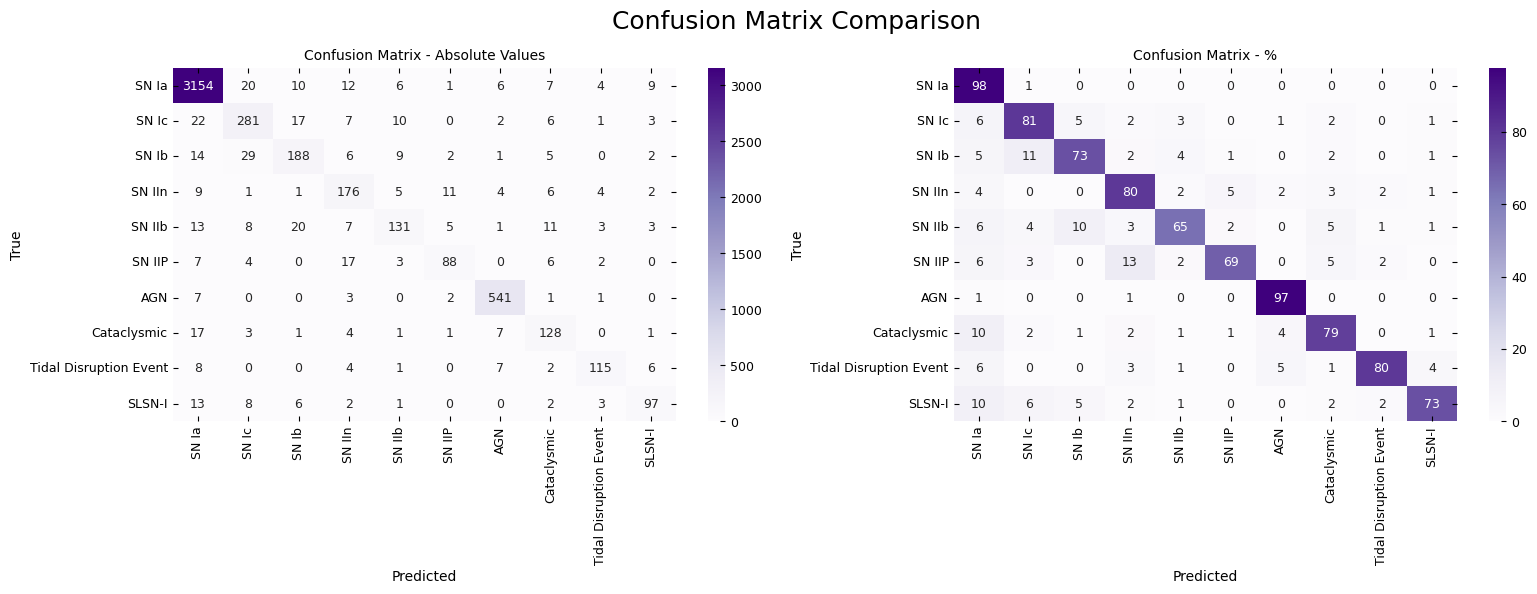

📊 [Val @ Epoch 9] Top-1 Acc: 91.14%, Top-3 Acc: 97.93%, F1: 0.8064
>>> 🚀🚀🚀 New Best Accuracy: 0.8064

[Epoch 10/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.31it/s, acc=92.3, loss=0.0143] 


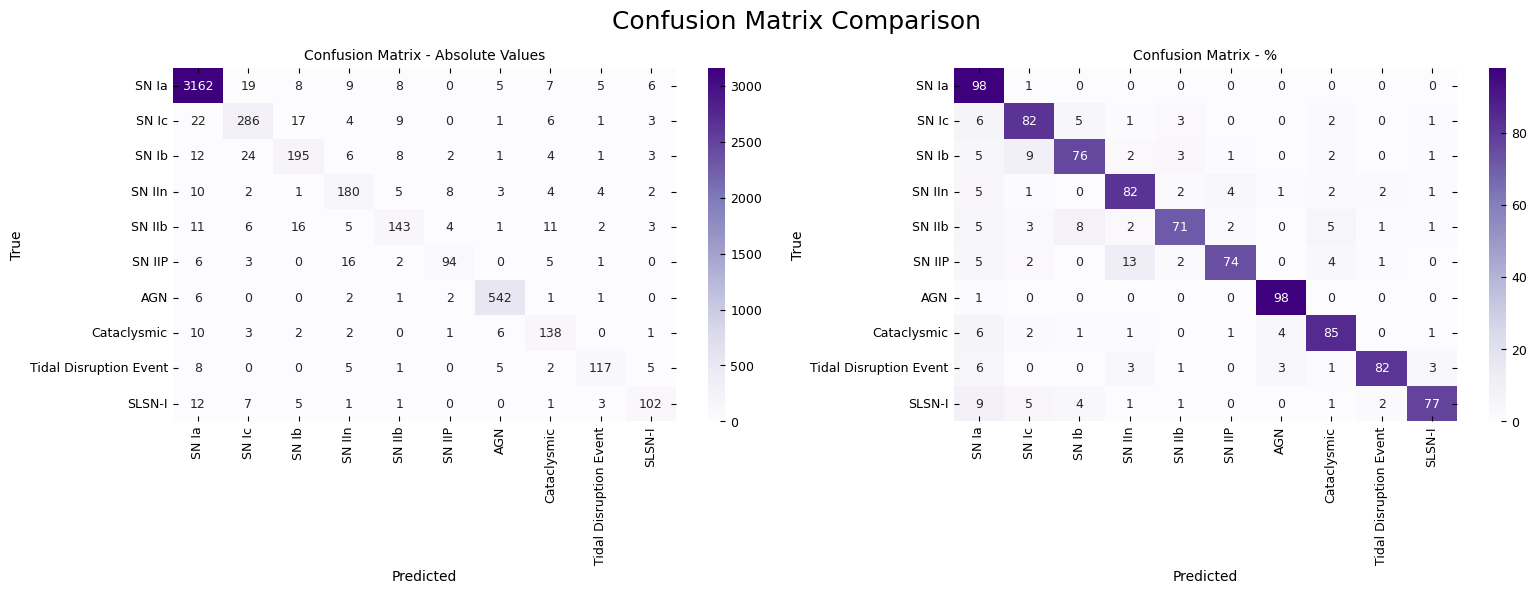

📊 [Val @ Epoch 10] Top-1 Acc: 92.26%, Top-3 Acc: 98.25%, F1: 0.8329
>>> 🚀🚀🚀 New Best Accuracy: 0.8329

[Epoch 11/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.08it/s, acc=93.3, loss=0.0132] 


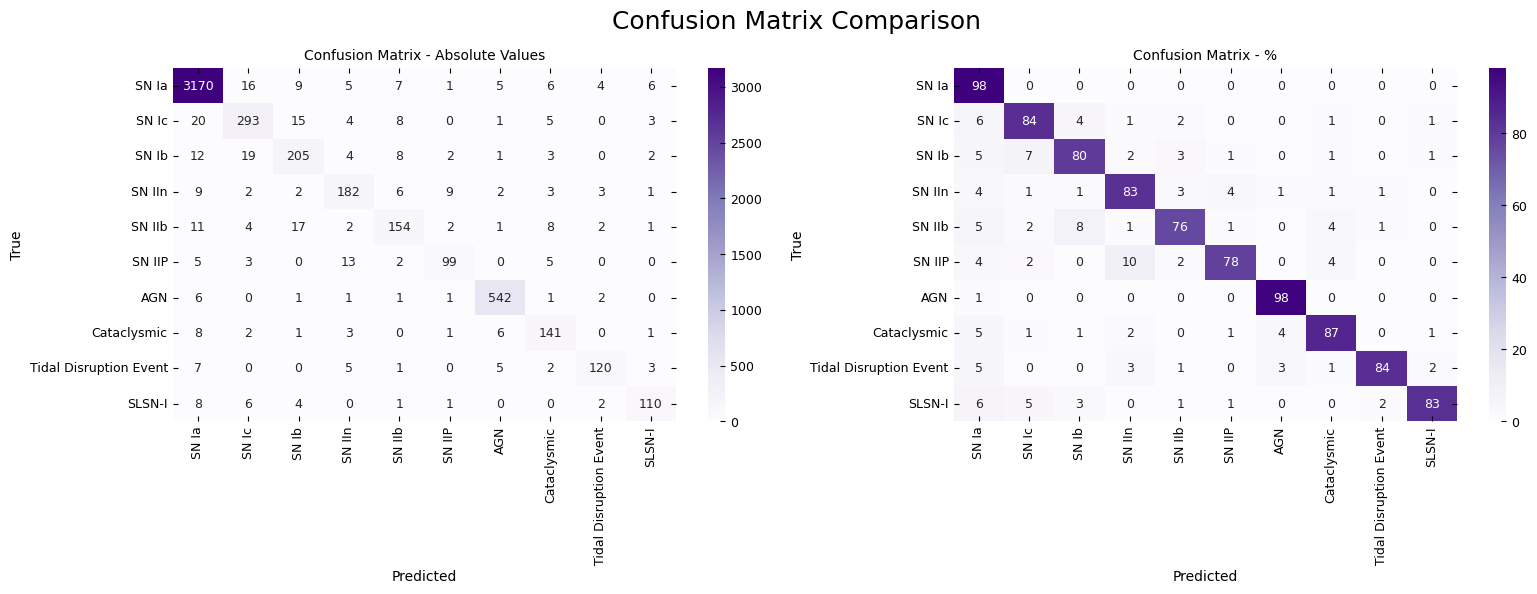

📊 [Val @ Epoch 11] Top-1 Acc: 93.32%, Top-3 Acc: 98.49%, F1: 0.8587
>>> 🚀🚀🚀 New Best Accuracy: 0.8587

[Epoch 12/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.84it/s, acc=94, loss=0.0118]   


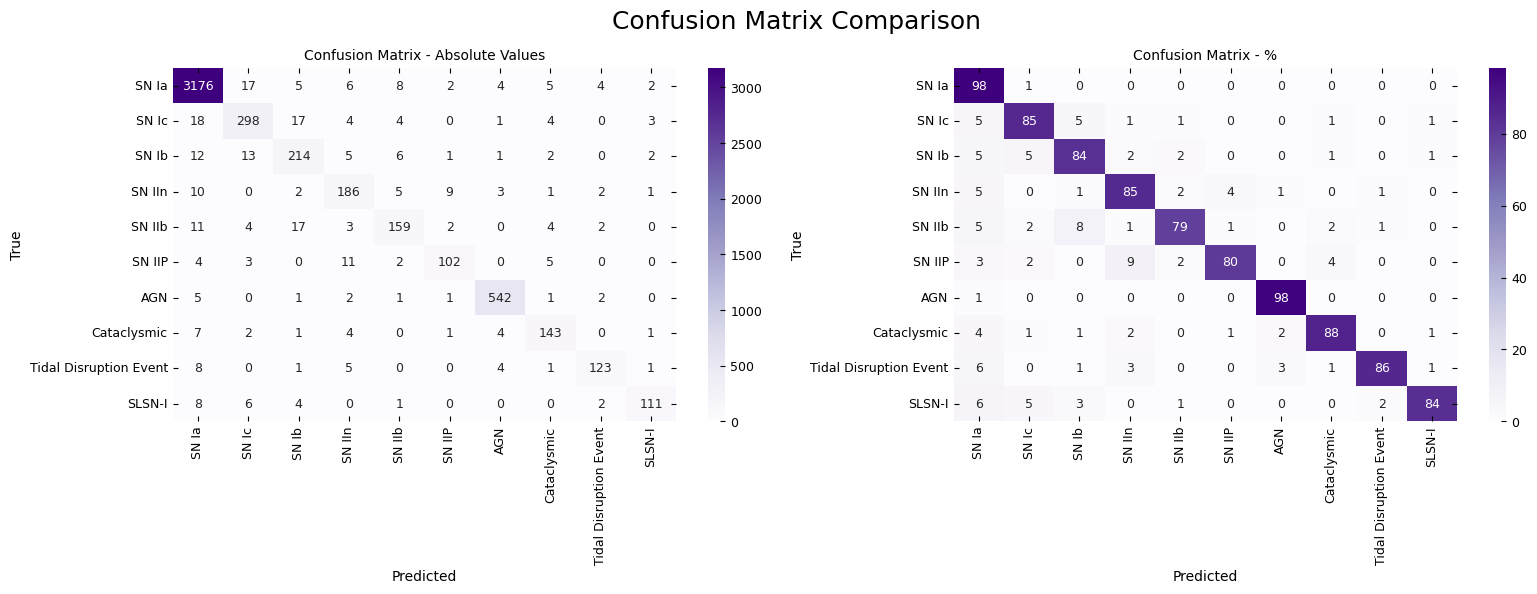

📊 [Val @ Epoch 12] Top-1 Acc: 94.03%, Top-3 Acc: 98.60%, F1: 0.8759
>>> 🚀🚀🚀 New Best Accuracy: 0.8759

[Epoch 13/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 19.01it/s, acc=94.6, loss=0.0109] 


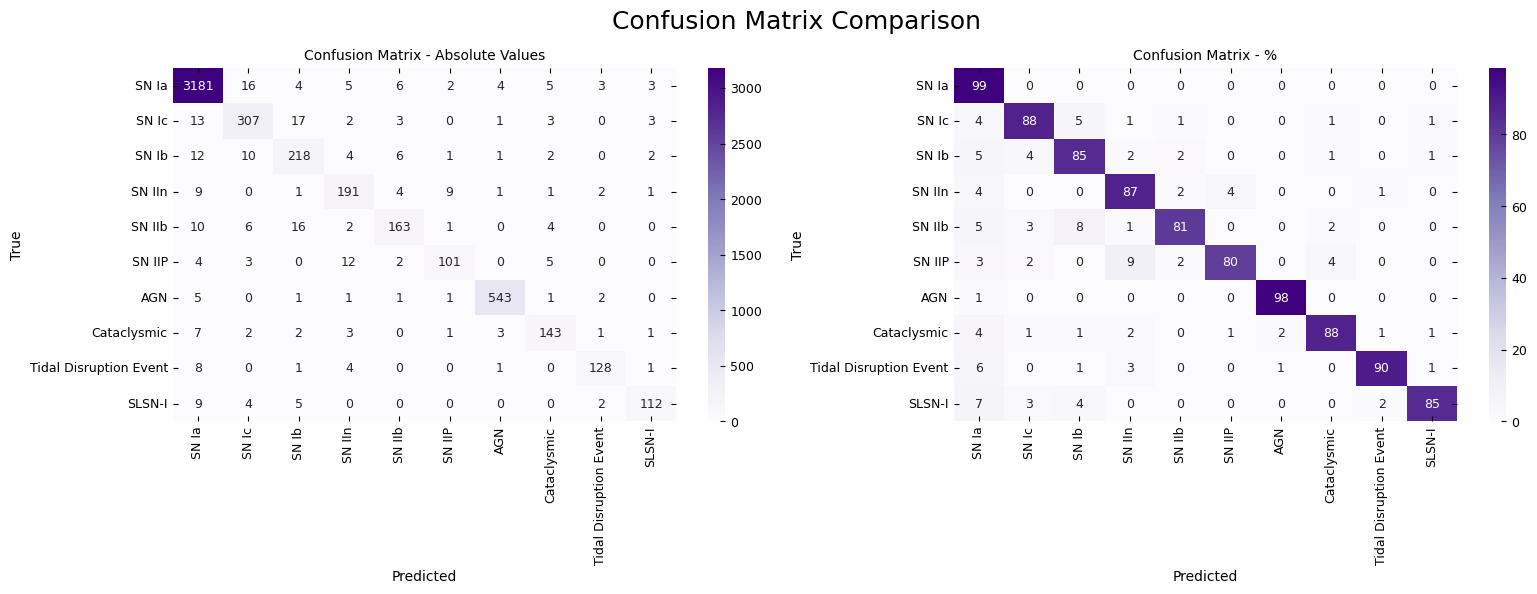

📊 [Val @ Epoch 13] Top-1 Acc: 94.64%, Top-3 Acc: 98.81%, F1: 0.8878
>>> 🚀🚀🚀 New Best Accuracy: 0.8878

[Epoch 14/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.98it/s, acc=94.9, loss=0.0102] 


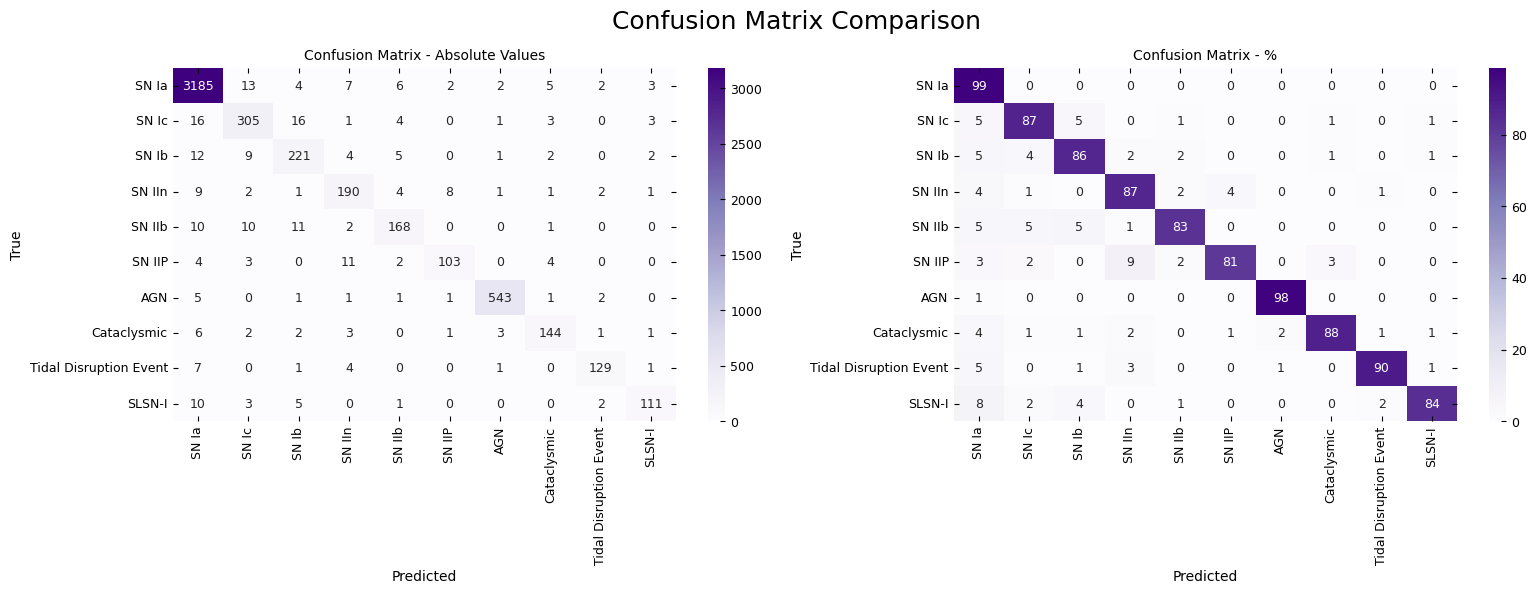

📊 [Val @ Epoch 14] Top-1 Acc: 94.87%, Top-3 Acc: 98.70%, F1: 0.8939
>>> 🚀🚀🚀 New Best Accuracy: 0.8939

[Epoch 15/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 19.04it/s, acc=95.1, loss=0.0101] 


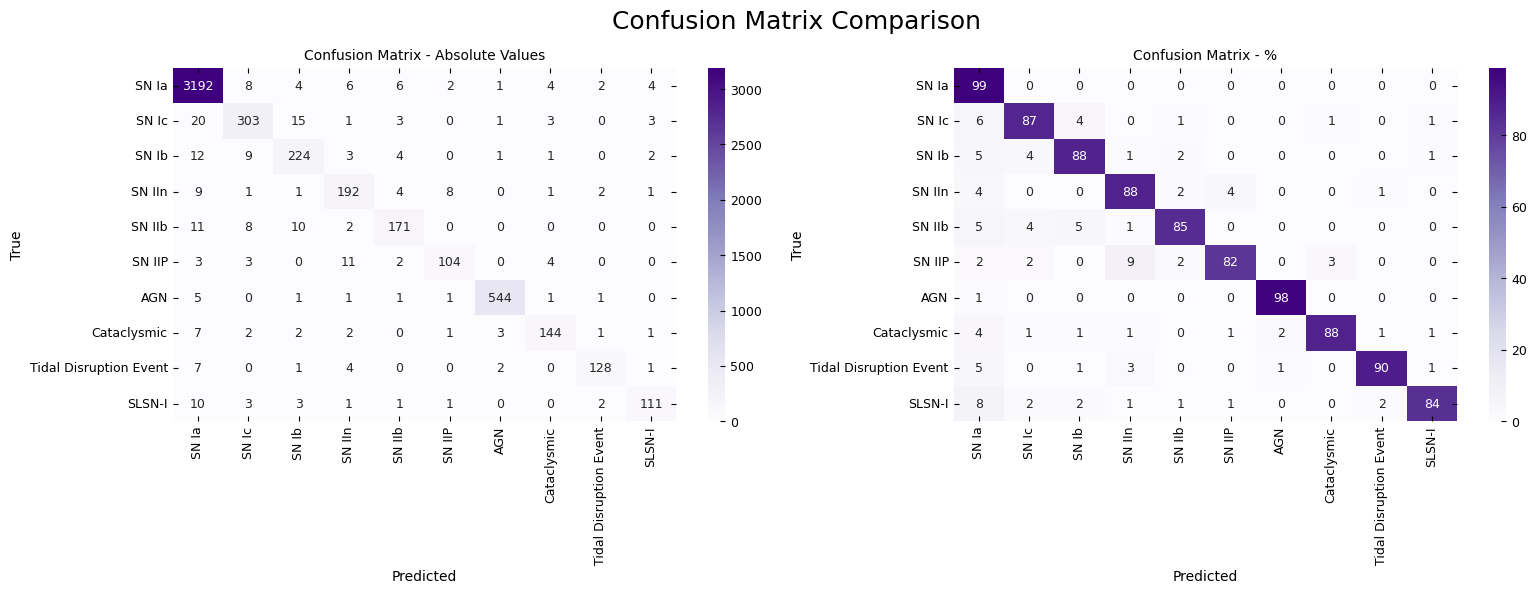

📊 [Val @ Epoch 15] Top-1 Acc: 95.13%, Top-3 Acc: 98.81%, F1: 0.8989
>>> 🚀🚀🚀 New Best Accuracy: 0.8989

[Epoch 16/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.79it/s, acc=95.2, loss=0.0104] 


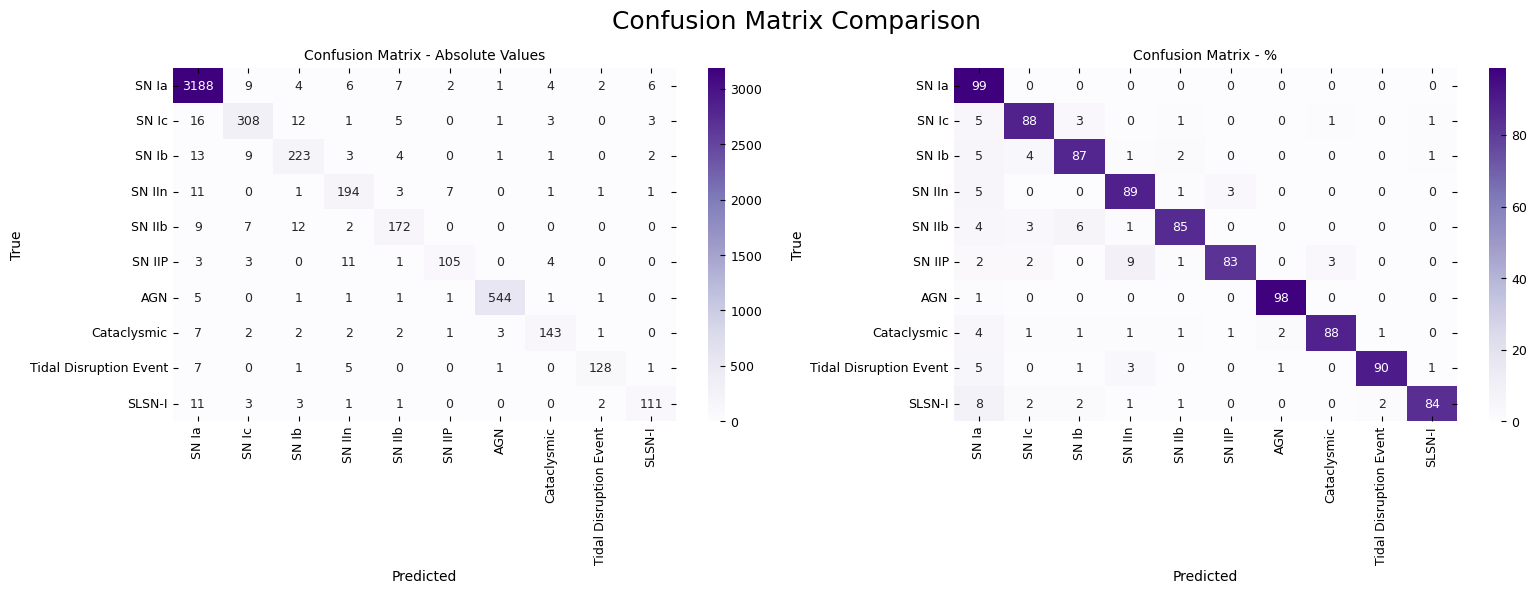

📊 [Val @ Epoch 16] Top-1 Acc: 95.18%, Top-3 Acc: 98.85%, F1: 0.9006
>>> 🚀🚀🚀 New Best Accuracy: 0.9006

[Epoch 17/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.25it/s, acc=95.4, loss=0.0113] 


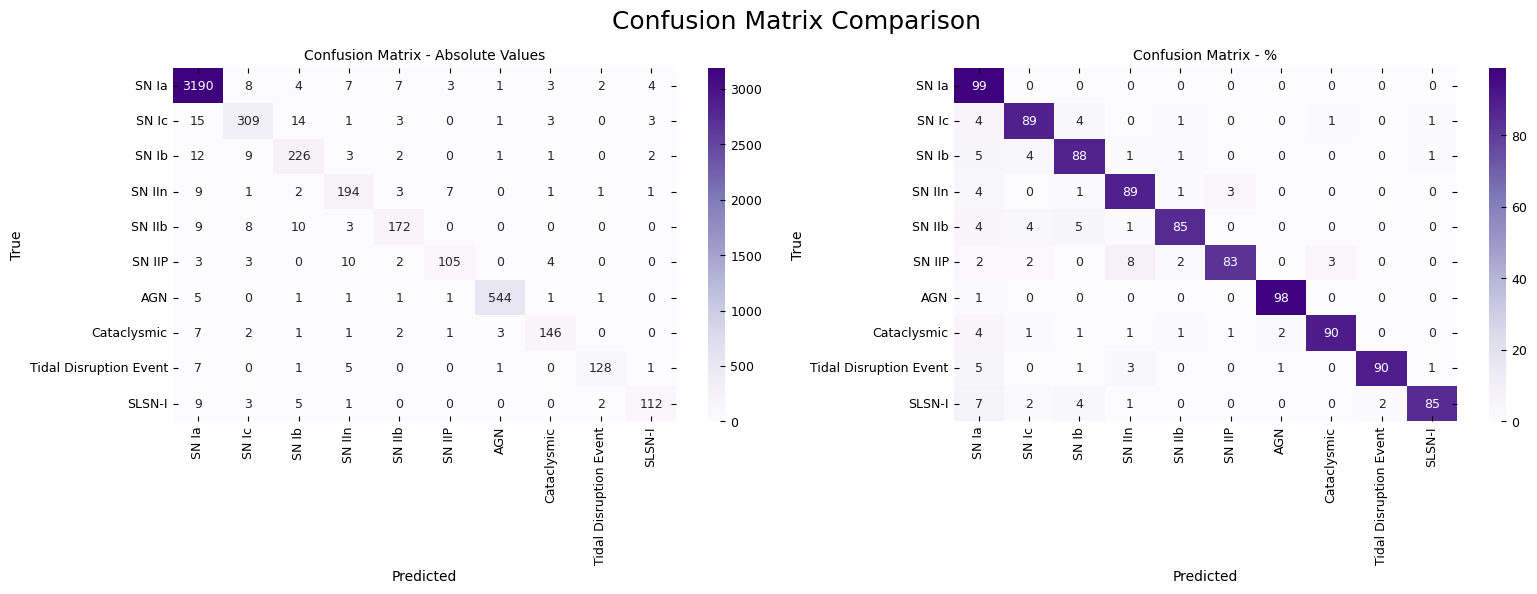

📊 [Val @ Epoch 17] Top-1 Acc: 95.37%, Top-3 Acc: 98.72%, F1: 0.9043
>>> 🚀🚀🚀 New Best Accuracy: 0.9043

[Epoch 18/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.45it/s, acc=95.3, loss=0.0113] 


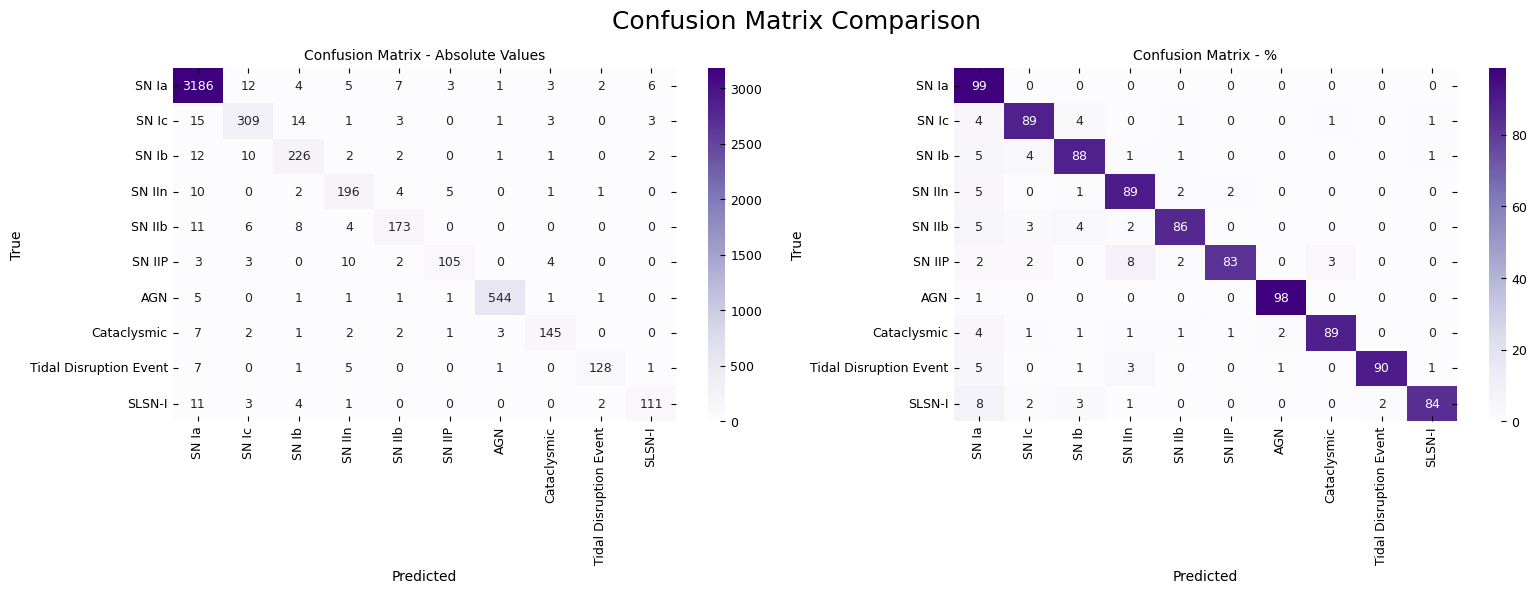

📊 [Val @ Epoch 18] Top-1 Acc: 95.31%, Top-3 Acc: 98.75%, F1: 0.9048
>>> 🚀🚀🚀 New Best Accuracy: 0.9048

[Epoch 19/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.29it/s, acc=95.3, loss=0.0112] 


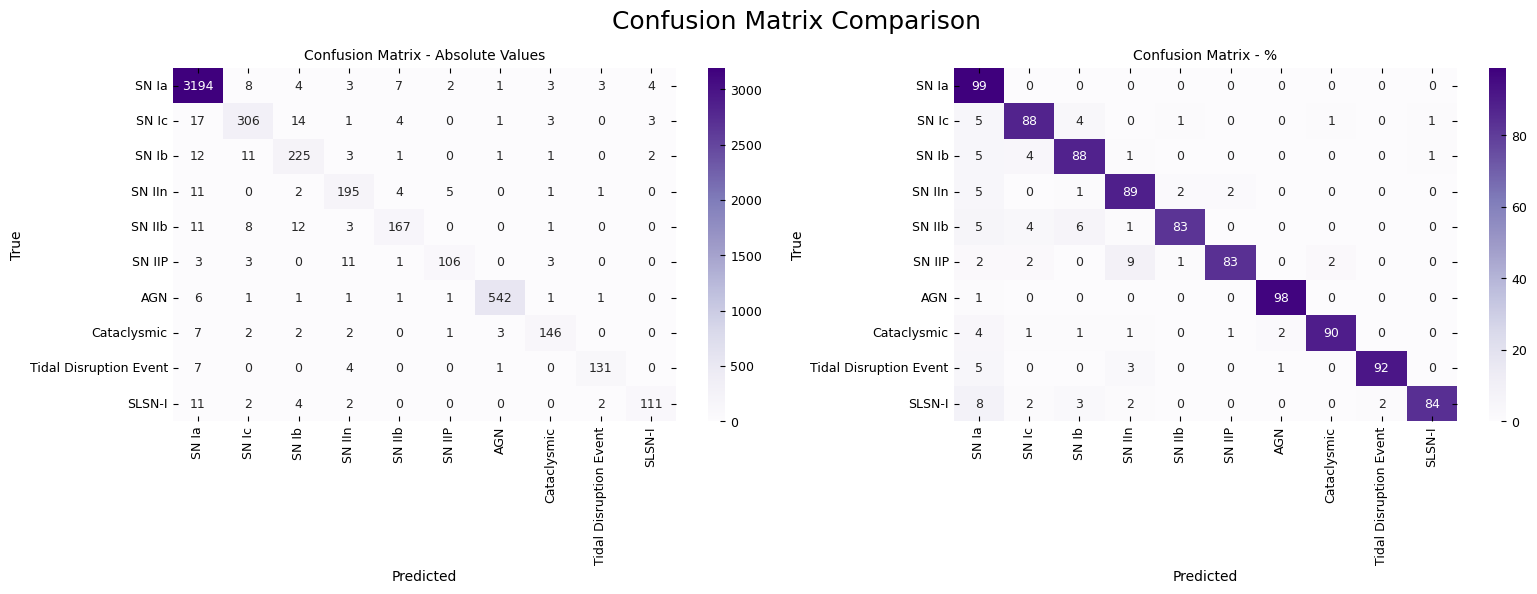

📊 [Val @ Epoch 19] Top-1 Acc: 95.31%, Top-3 Acc: 98.83%, F1: 0.9053
>>> 🚀🚀🚀 New Best Accuracy: 0.9053

[Epoch 20/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.24it/s, acc=95.5, loss=0.011]  


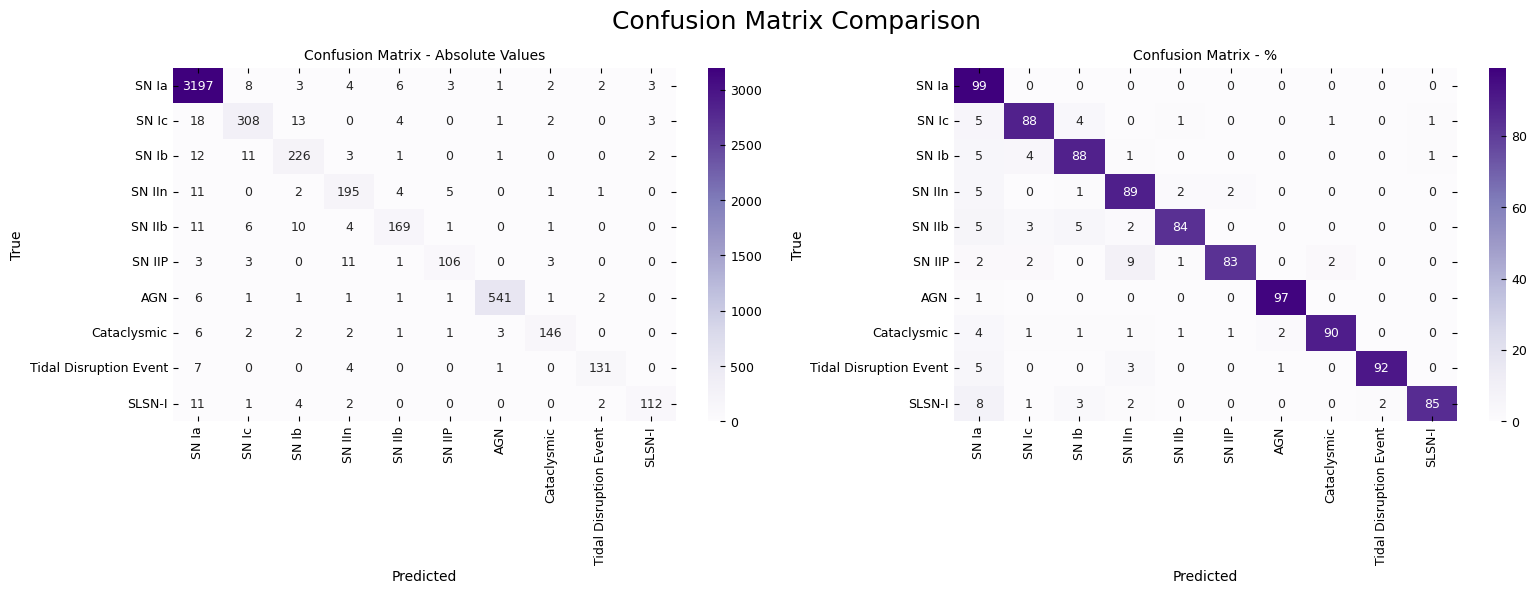

📊 [Val @ Epoch 20] Top-1 Acc: 95.46%, Top-3 Acc: 98.81%, F1: 0.9082
>>> 🚀🚀🚀 New Best Accuracy: 0.9082

[Epoch 21/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.58it/s, acc=95.3, loss=0.0111] 


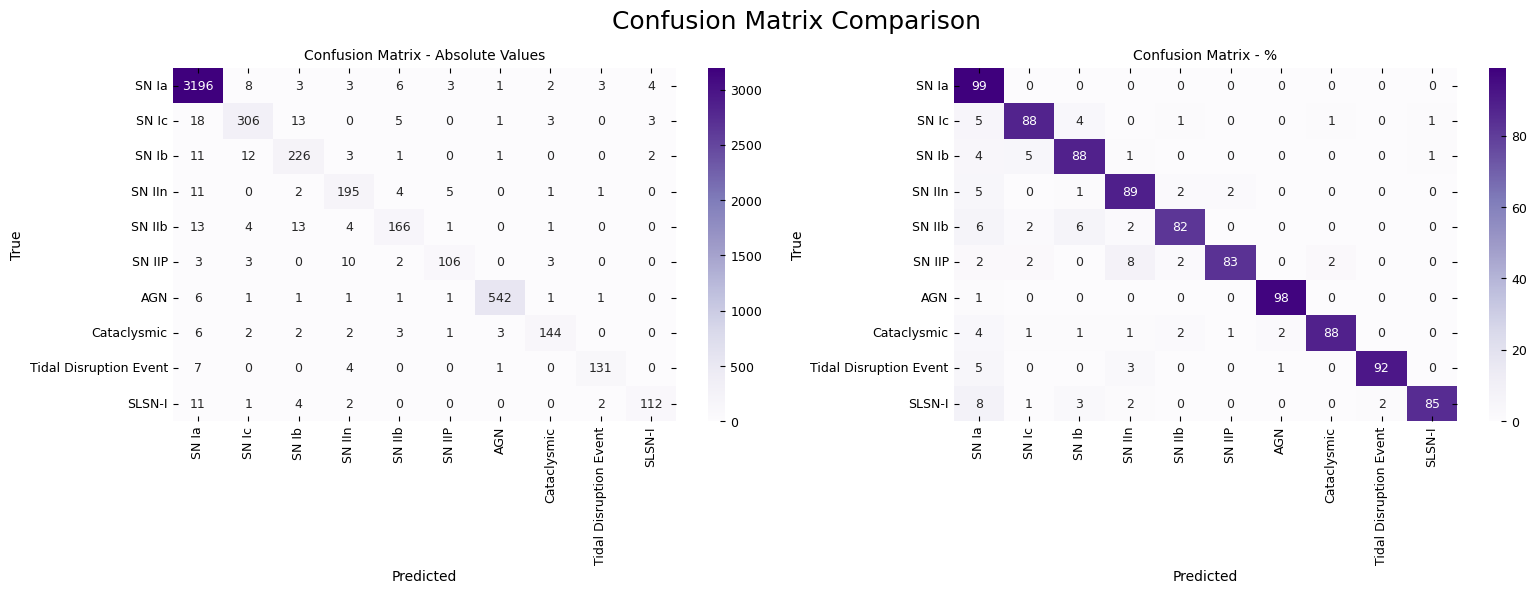

📊 [Val @ Epoch 21] Top-1 Acc: 95.33%, Top-3 Acc: 98.77%, F1: 0.9049
>>> No F1 improvement for 1 epoch(s)

[Epoch 22/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.50it/s, acc=95.3, loss=0.0108] 


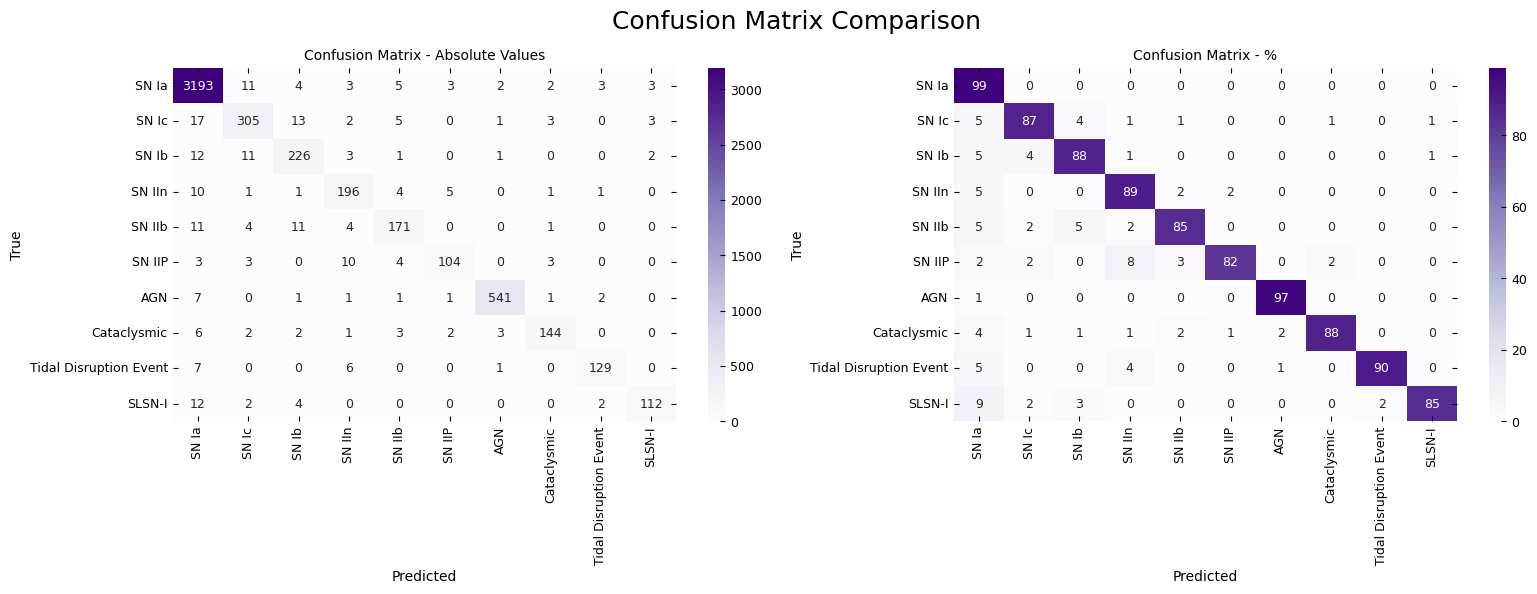

📊 [Val @ Epoch 22] Top-1 Acc: 95.27%, Top-3 Acc: 98.81%, F1: 0.9041
>>> No F1 improvement for 2 epoch(s)

[Epoch 23/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.46it/s, acc=95.2, loss=0.0112] 


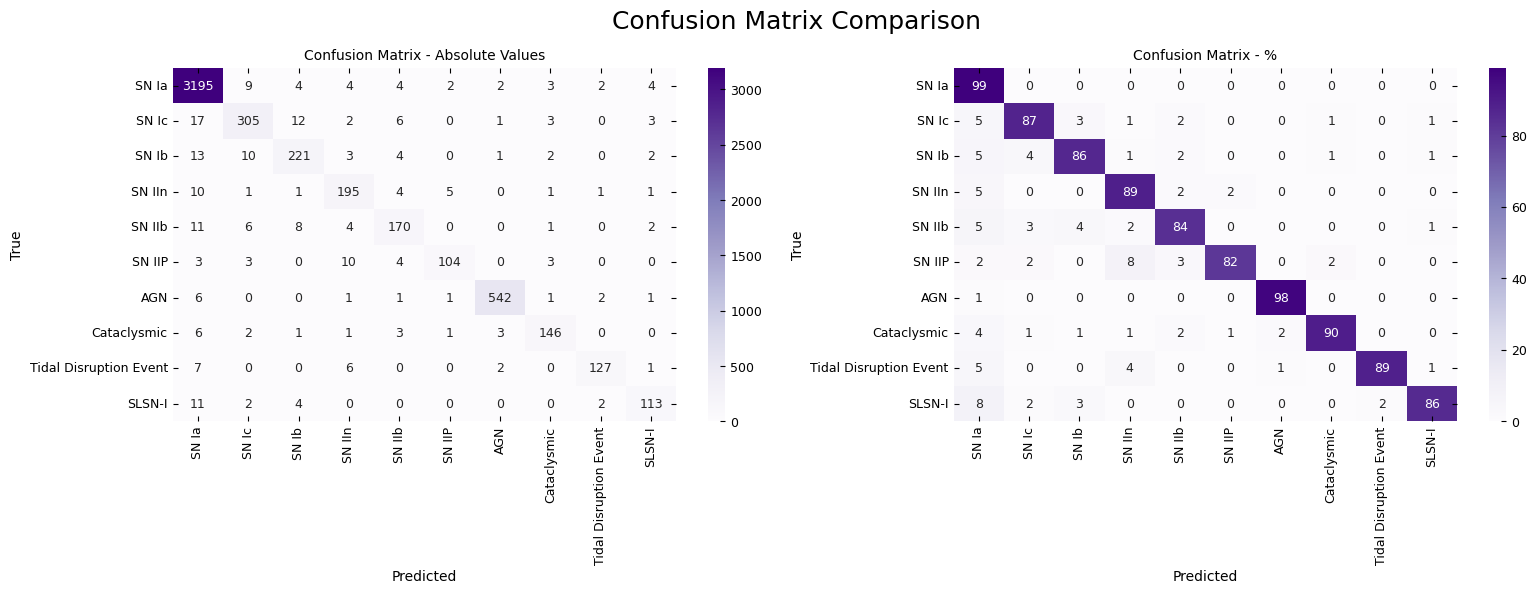

📊 [Val @ Epoch 23] Top-1 Acc: 95.22%, Top-3 Acc: 98.79%, F1: 0.9013
>>> No F1 improvement for 3 epoch(s)

[Epoch 24/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.02it/s, acc=95.2, loss=0.0108] 


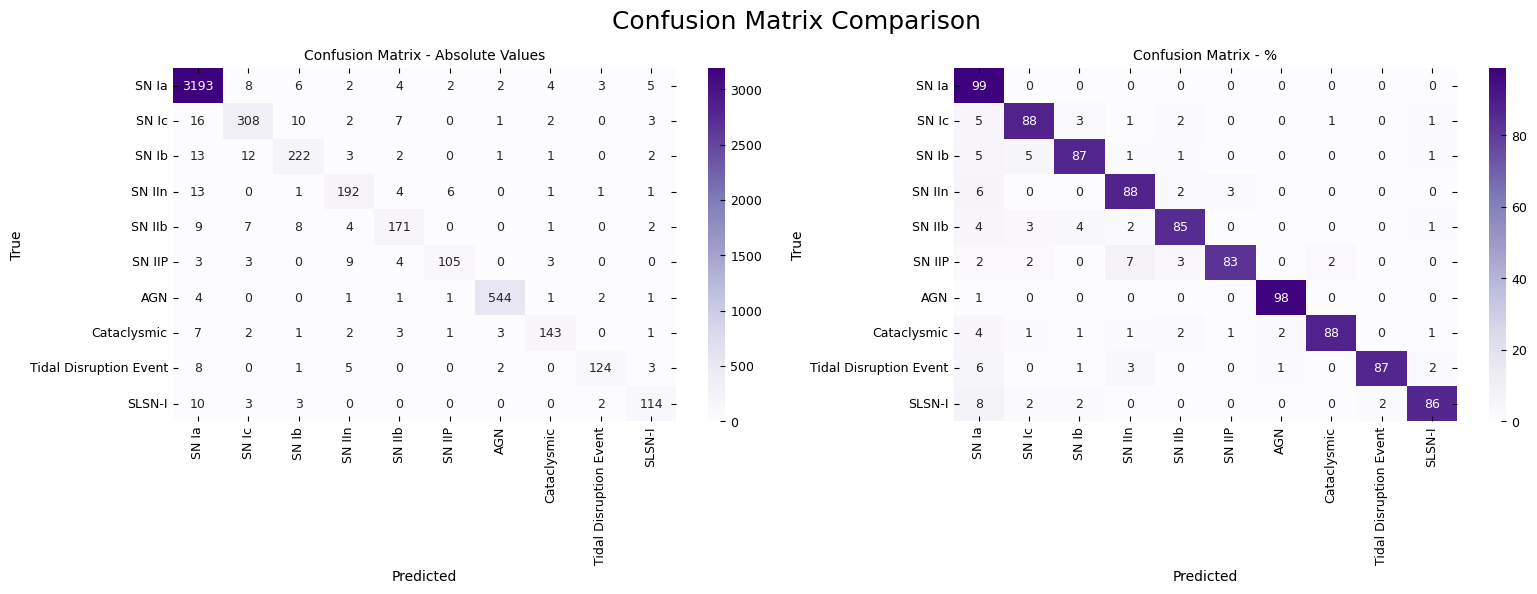

📊 [Val @ Epoch 24] Top-1 Acc: 95.18%, Top-3 Acc: 98.81%, F1: 0.8992
>>> No F1 improvement for 4 epoch(s)

[Epoch 25/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.77it/s, acc=95.2, loss=0.0108] 


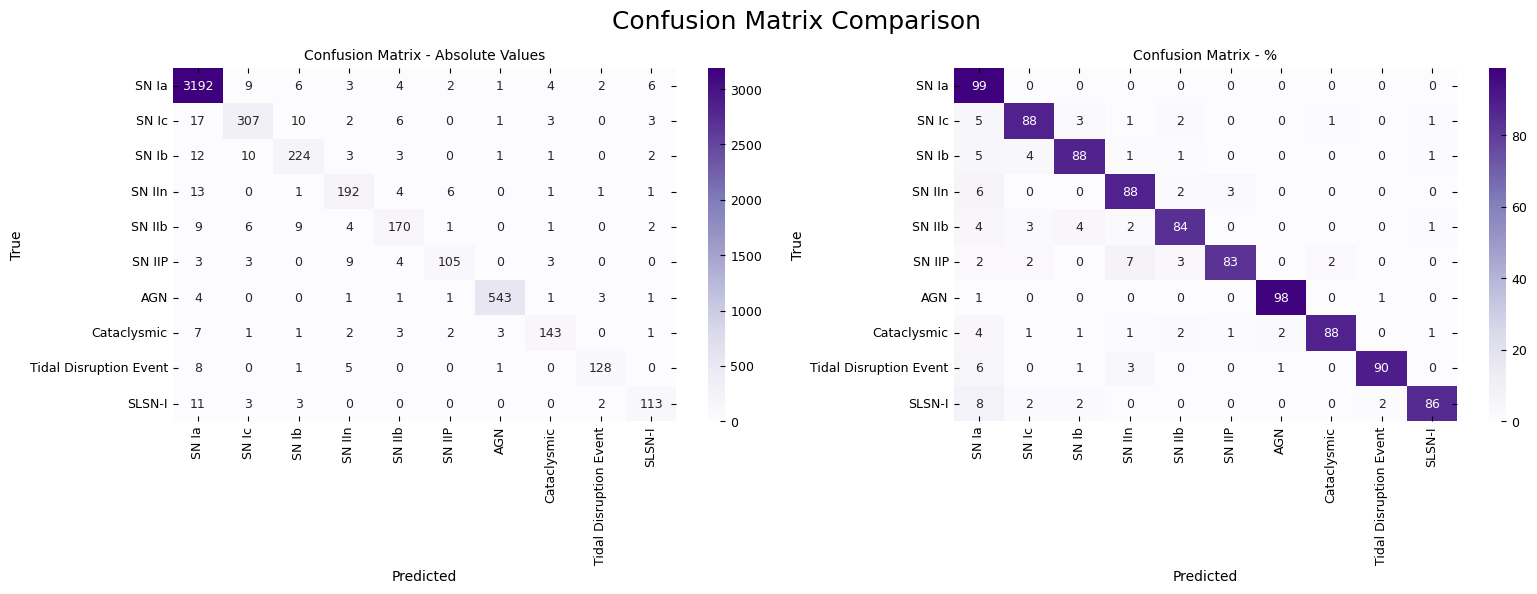

📊 [Val @ Epoch 25] Top-1 Acc: 95.20%, Top-3 Acc: 98.75%, F1: 0.9000
>>> No F1 improvement for 5 epoch(s)
>>> Early stopping triggered based on composite score.
Best F1 on Validate dataset: 0.9082

>>> Final Testing on Test Set...


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.77it/s, acc=95, loss=0.00947]  


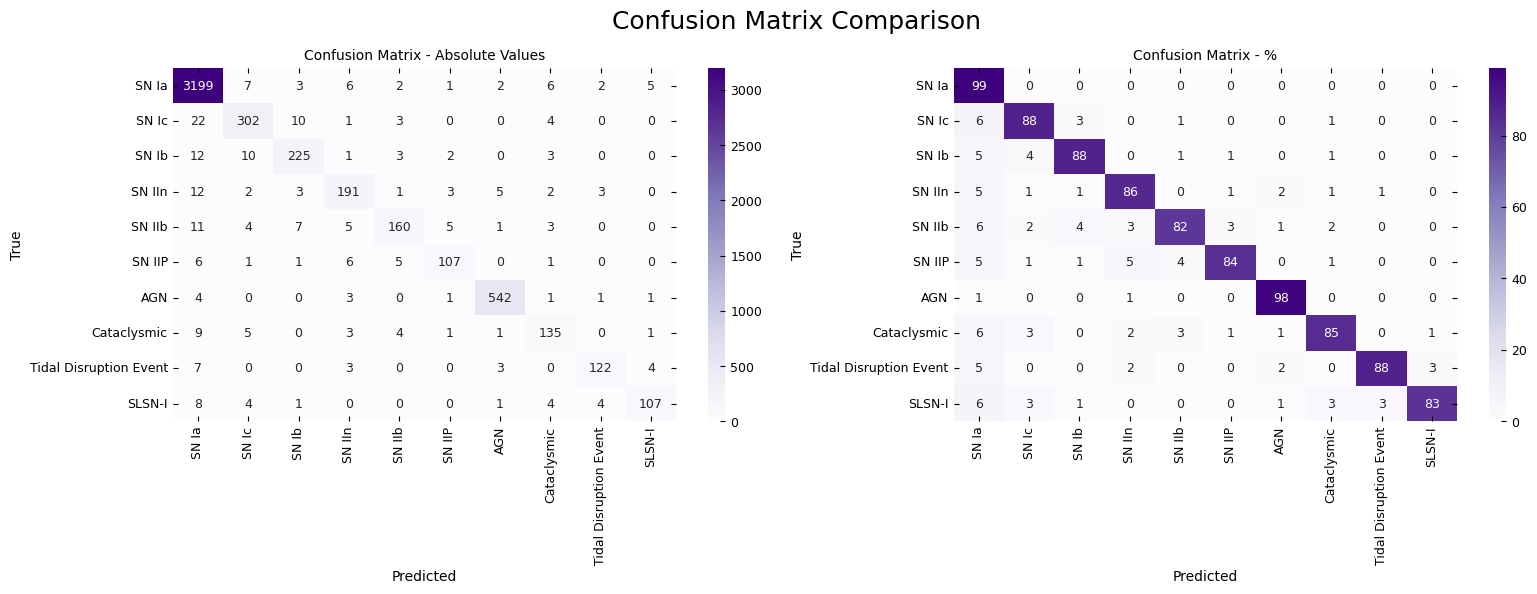


[TEST] Macro ROC-AUC: 0.9946


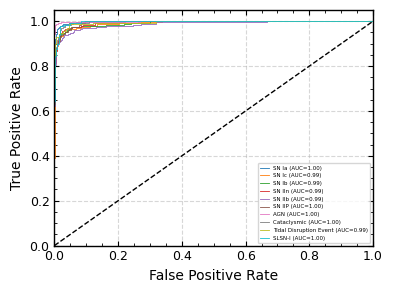

[TEST] ROC curve saved to: c:\Users\Administrator\Desktop\SpectraNet-SN\record
>>> Test Loss: 0.0121, Acc: 95.03%, F1: 0.8945, Top-3 Acc: 98.51%, Composite: 0.9440

=== Running seed 888 (3/3) ===

[Epoch 1/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.35it/s, acc=2.66, loss=0.185]


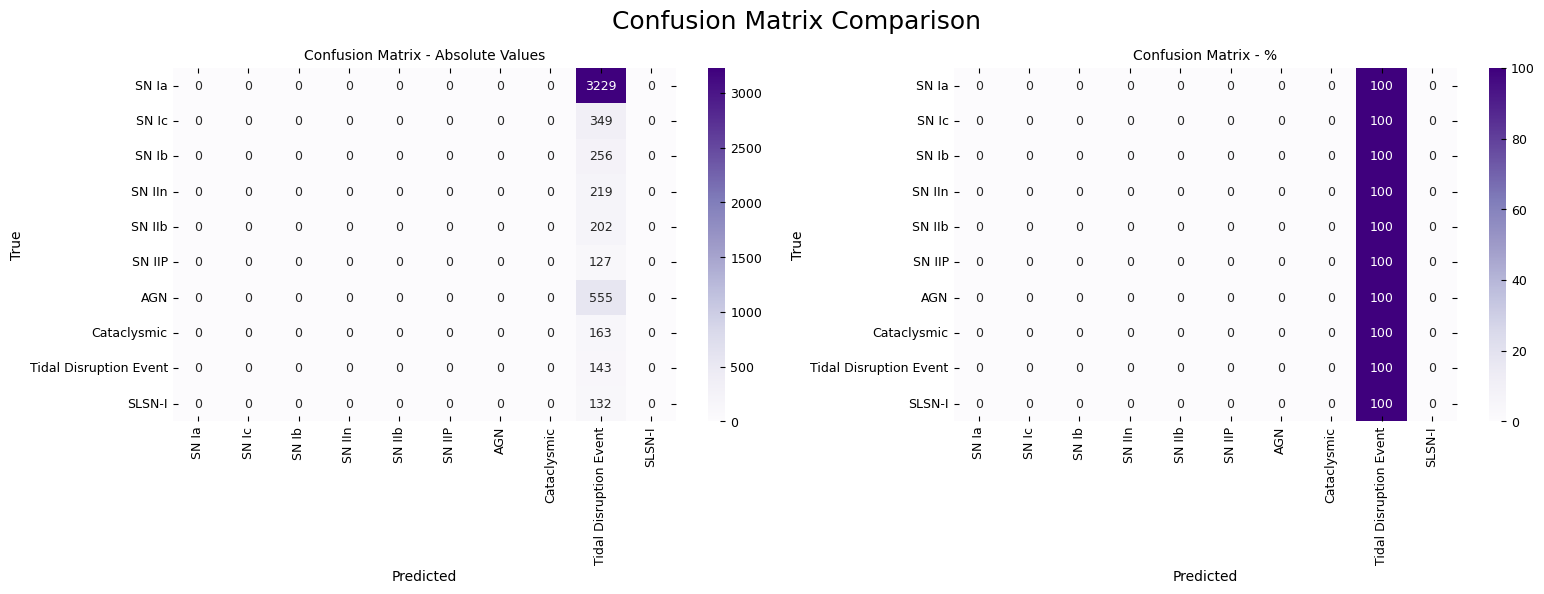

📊 [Val @ Epoch 1] Top-1 Acc: 2.66%, Top-3 Acc: 31.98%, F1: 0.0052
>>> 🚀🚀🚀 New Best Accuracy: 0.0052

[Epoch 2/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.46it/s, acc=65.3, loss=0.0925]


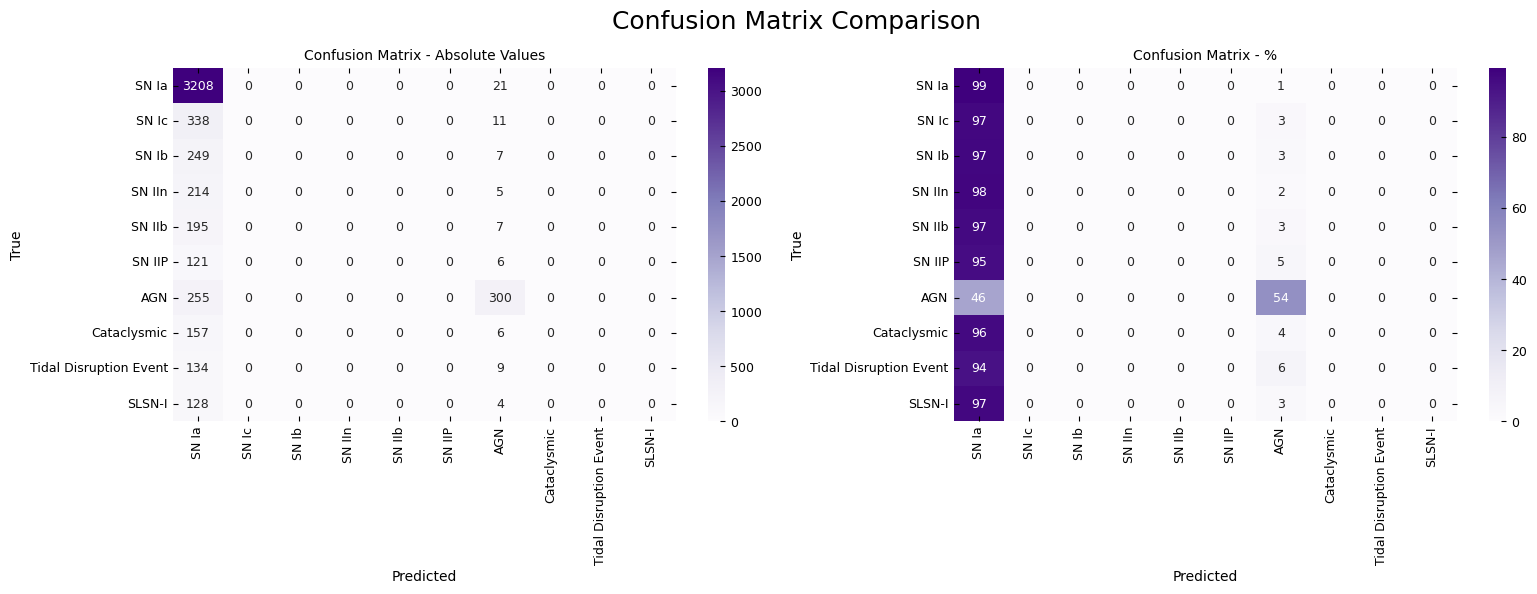

📊 [Val @ Epoch 2] Top-1 Acc: 65.27%, Top-3 Acc: 79.52%, F1: 0.1424
>>> 🚀🚀🚀 New Best Accuracy: 0.1424

[Epoch 3/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.84it/s, acc=68.7, loss=0.0671]


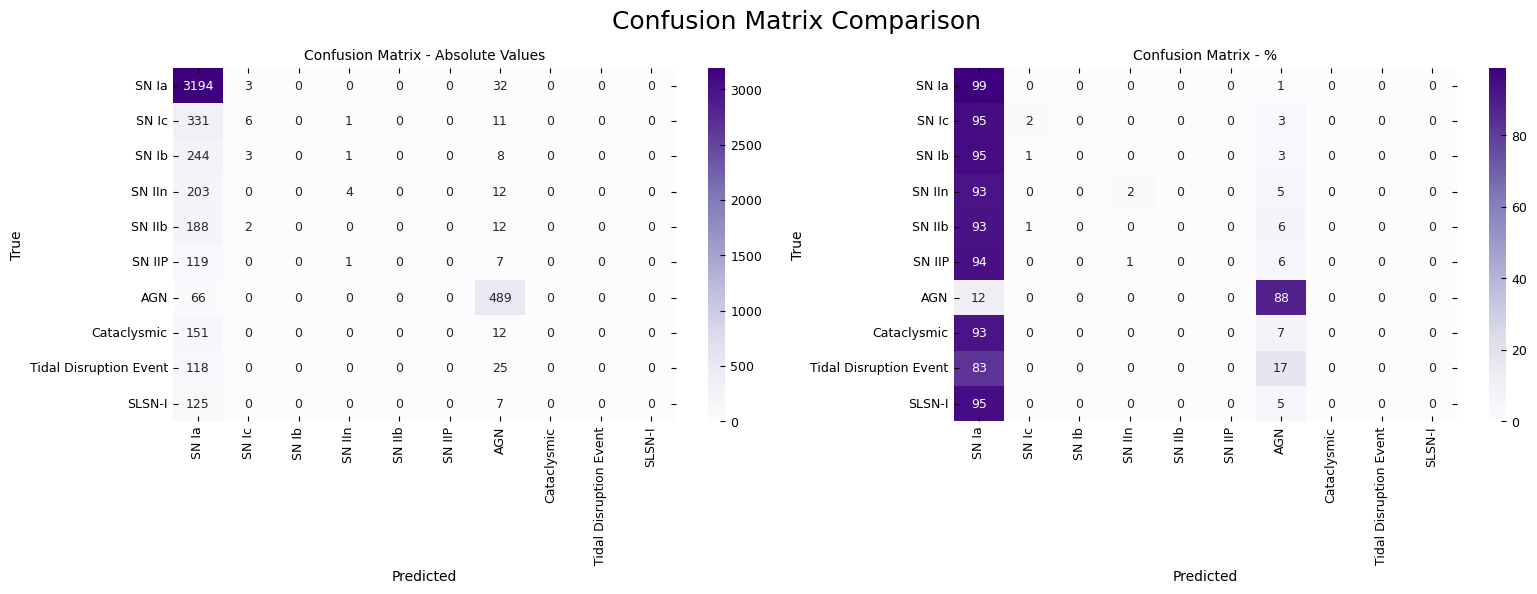

📊 [Val @ Epoch 3] Top-1 Acc: 68.71%, Top-3 Acc: 85.45%, F1: 0.1706
>>> 🚀🚀🚀 New Best Accuracy: 0.1706

[Epoch 4/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.68it/s, acc=77.7, loss=0.045] 


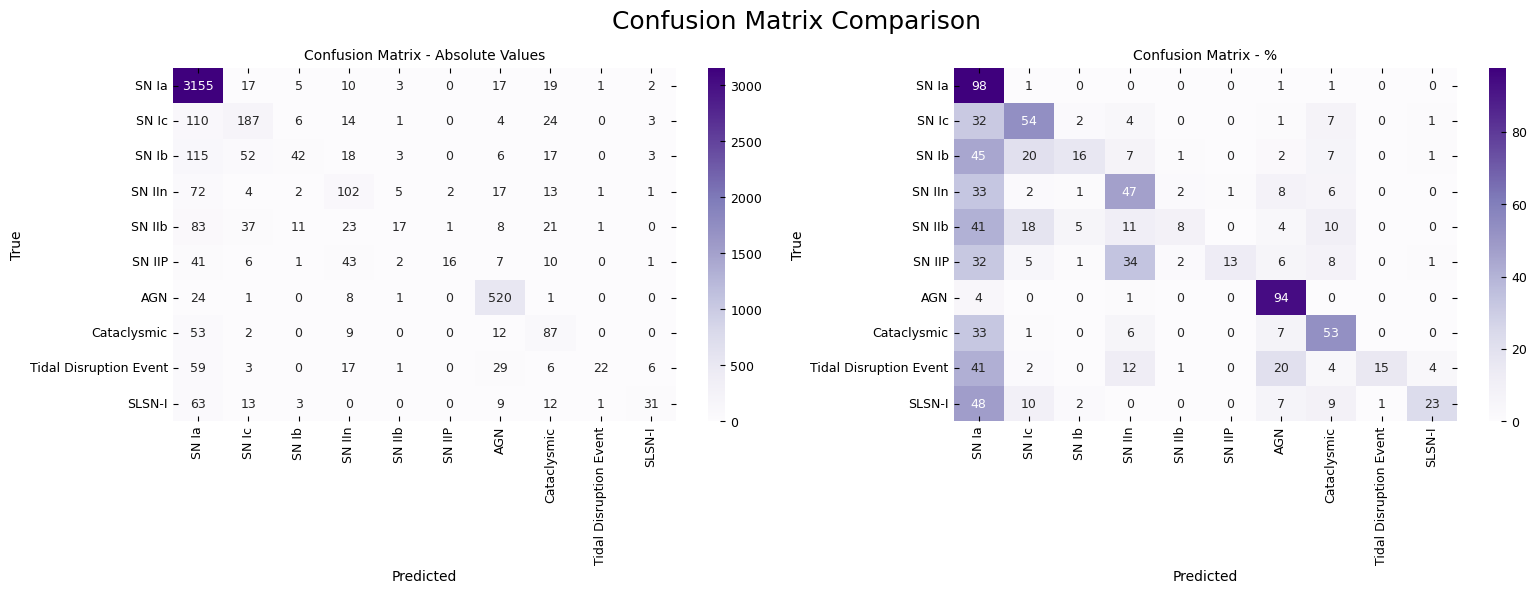

📊 [Val @ Epoch 4] Top-1 Acc: 77.75%, Top-3 Acc: 91.05%, F1: 0.4472
>>> 🚀🚀🚀 New Best Accuracy: 0.4472

[Epoch 5/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.17it/s, acc=83.4, loss=0.0337]


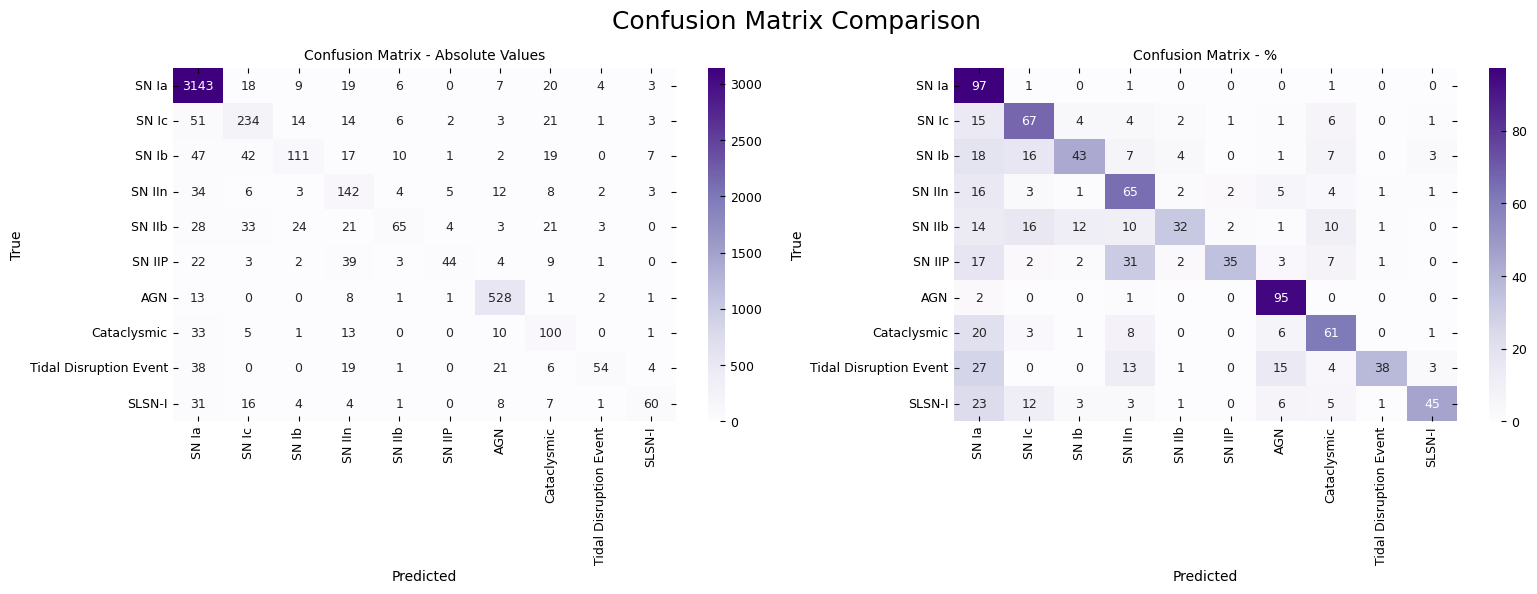

📊 [Val @ Epoch 5] Top-1 Acc: 83.37%, Top-3 Acc: 93.97%, F1: 0.6115
>>> 🚀🚀🚀 New Best Accuracy: 0.6115

[Epoch 6/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.52it/s, acc=86.2, loss=0.027] 


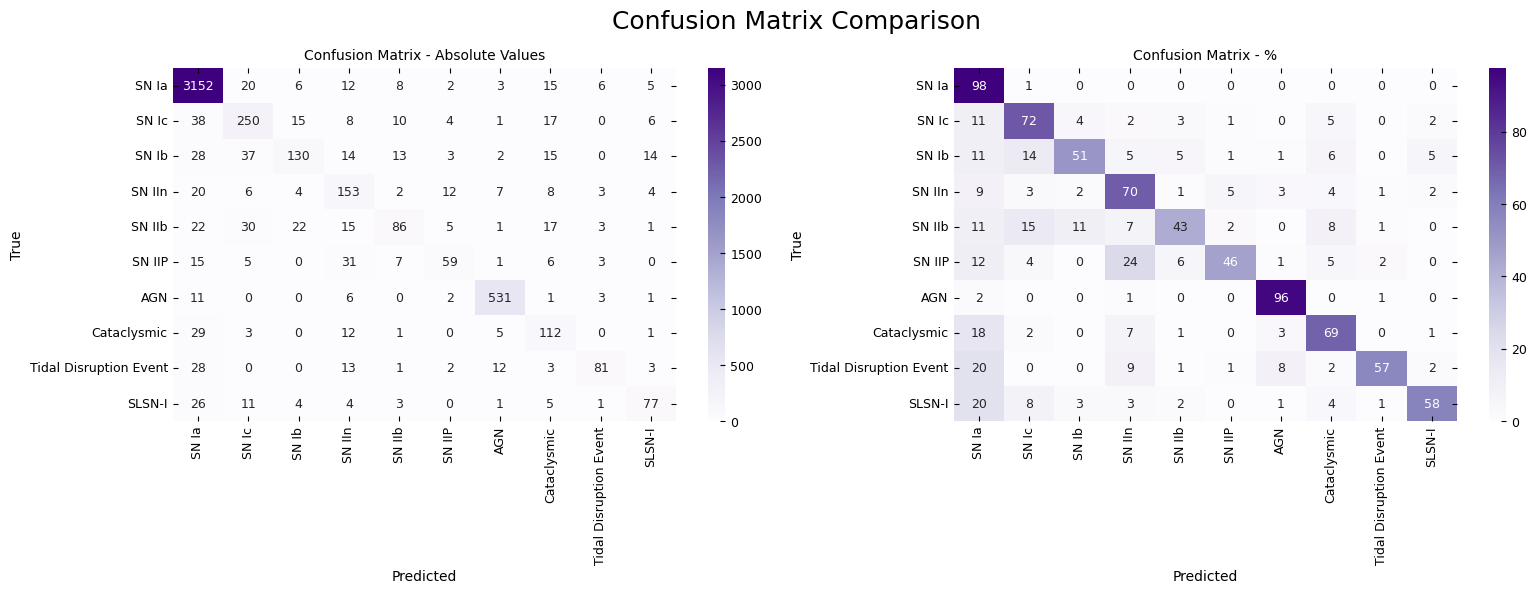

📊 [Val @ Epoch 6] Top-1 Acc: 86.16%, Top-3 Acc: 95.94%, F1: 0.6810
>>> 🚀🚀🚀 New Best Accuracy: 0.6810

[Epoch 7/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.40it/s, acc=88.2, loss=0.0231]


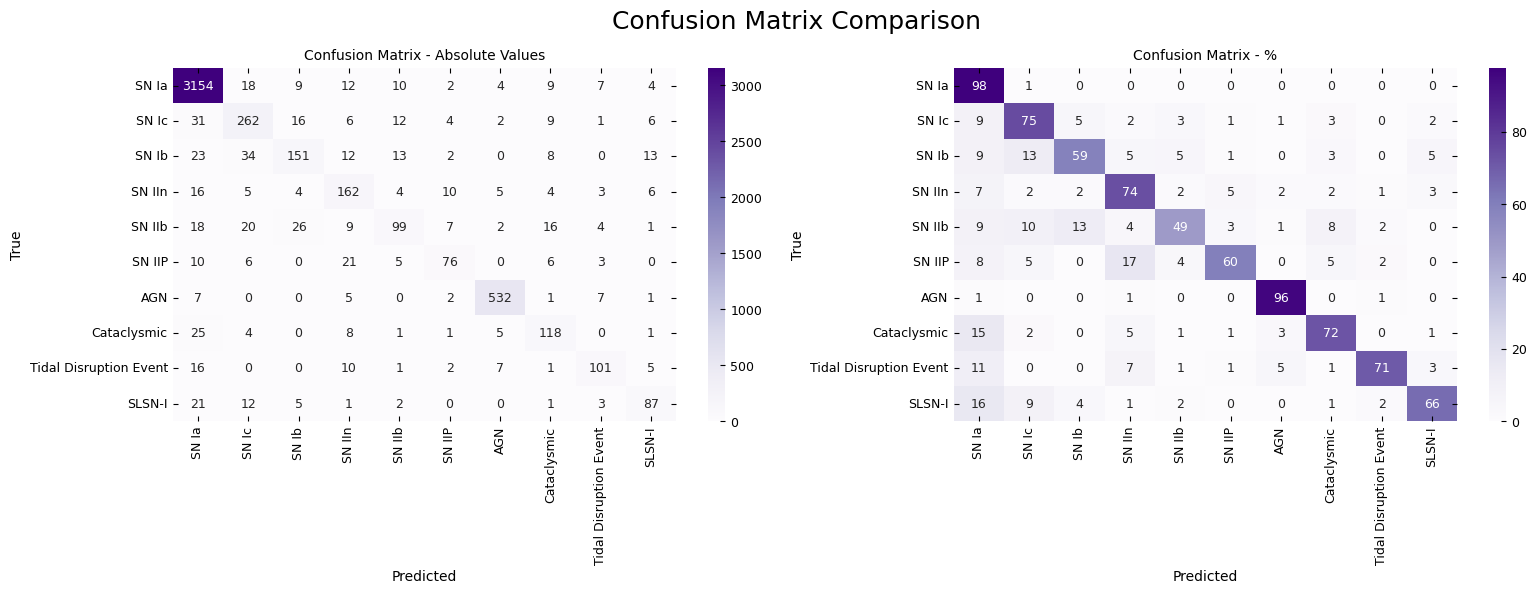

📊 [Val @ Epoch 7] Top-1 Acc: 88.22%, Top-3 Acc: 96.63%, F1: 0.7346
>>> 🚀🚀🚀 New Best Accuracy: 0.7346

[Epoch 8/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.39it/s, acc=89.9, loss=0.0199]


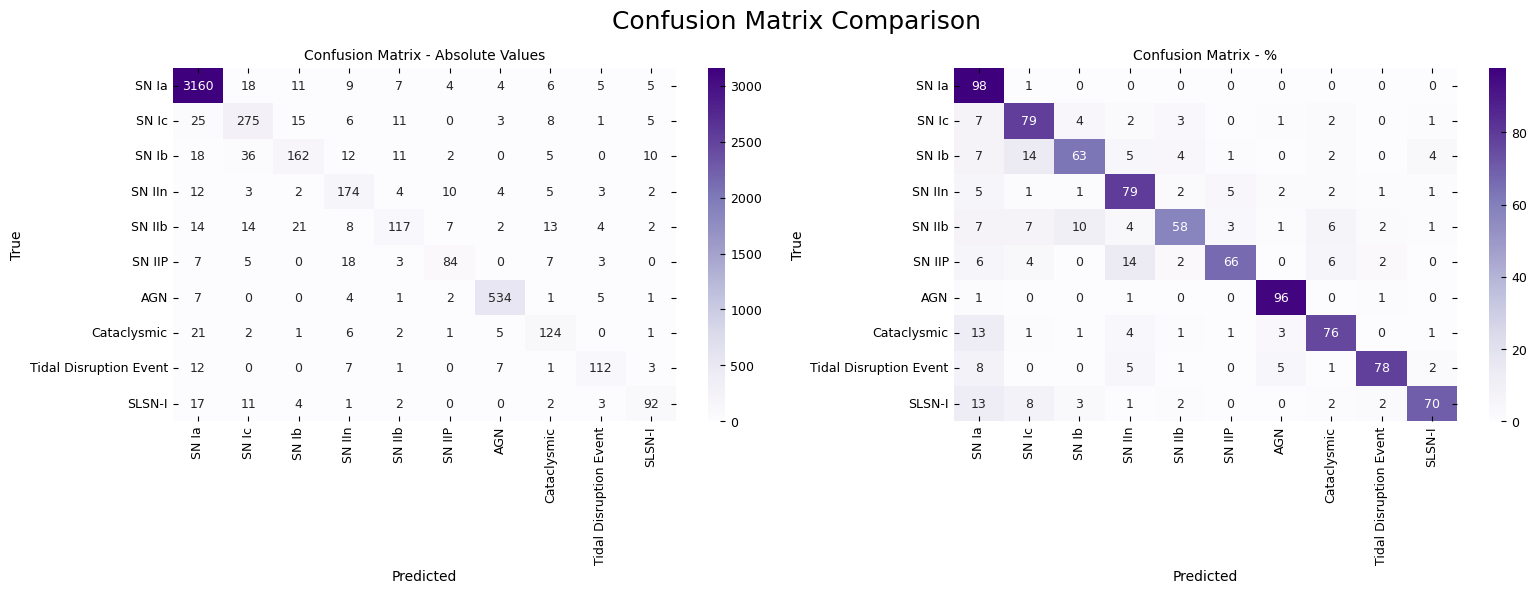

📊 [Val @ Epoch 8] Top-1 Acc: 89.93%, Top-3 Acc: 97.38%, F1: 0.7763
>>> 🚀🚀🚀 New Best Accuracy: 0.7763

[Epoch 9/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.85it/s, acc=91.4, loss=0.0171]


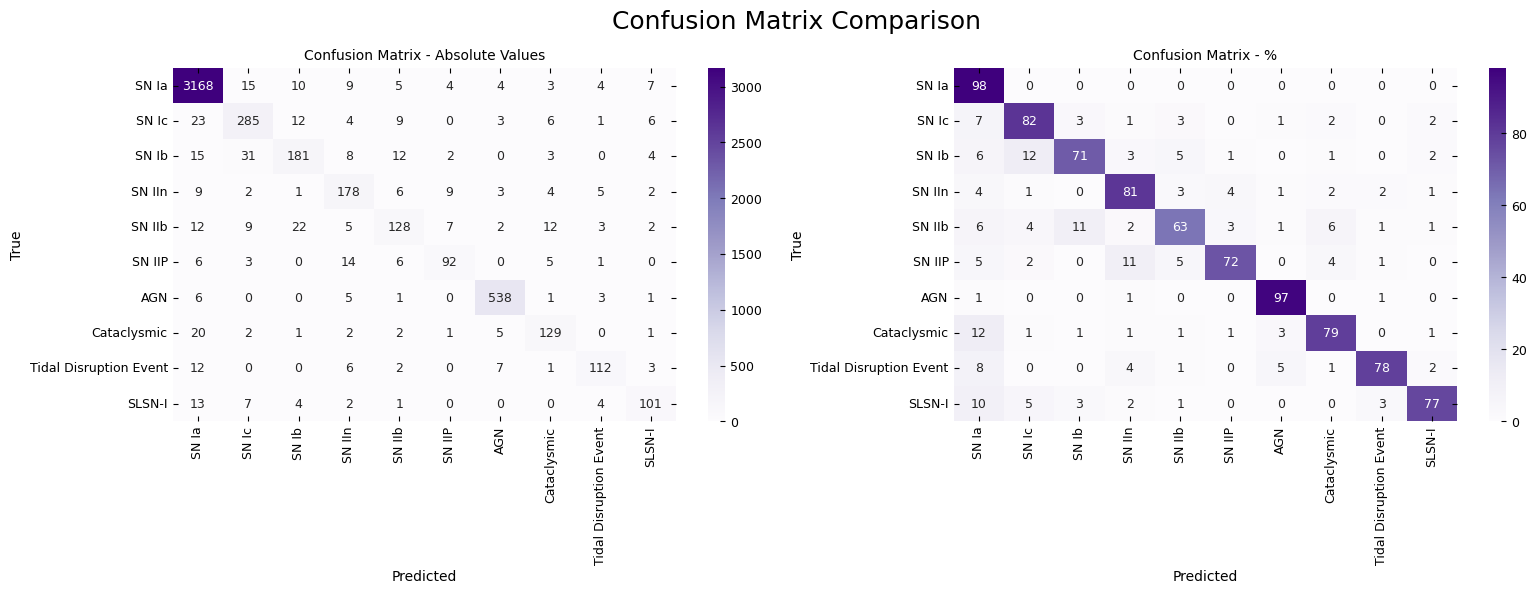

📊 [Val @ Epoch 9] Top-1 Acc: 91.39%, Top-3 Acc: 97.82%, F1: 0.8103
>>> 🚀🚀🚀 New Best Accuracy: 0.8103

[Epoch 10/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.85it/s, acc=92.4, loss=0.0154] 


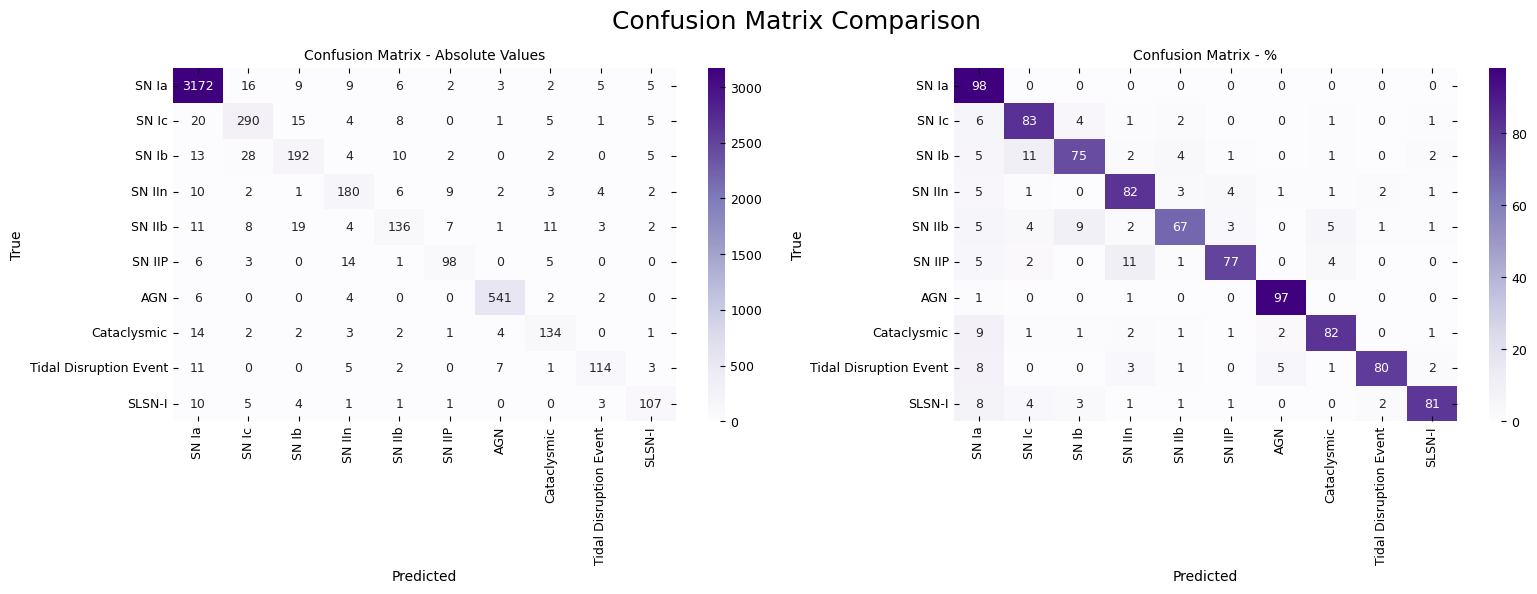

📊 [Val @ Epoch 10] Top-1 Acc: 92.35%, Top-3 Acc: 98.21%, F1: 0.8332
>>> 🚀🚀🚀 New Best Accuracy: 0.8332

[Epoch 11/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.67it/s, acc=93.2, loss=0.0136] 


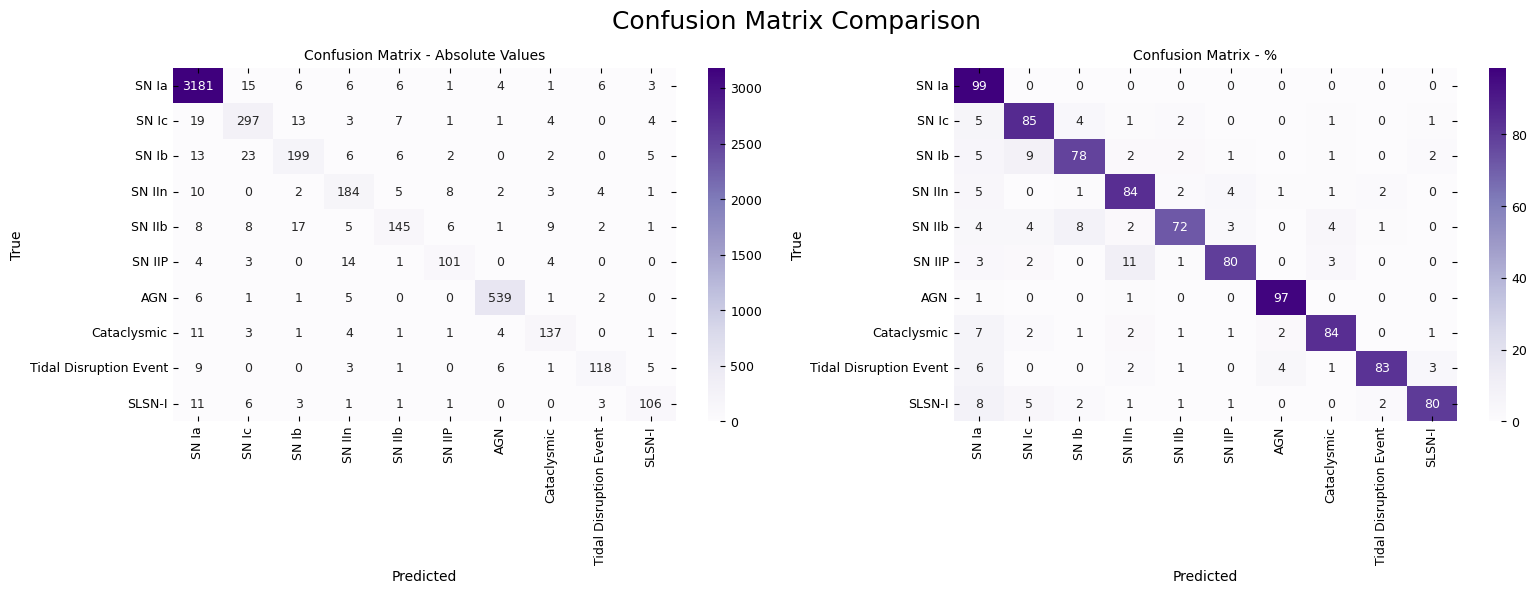

📊 [Val @ Epoch 11] Top-1 Acc: 93.15%, Top-3 Acc: 98.36%, F1: 0.8509
>>> 🚀🚀🚀 New Best Accuracy: 0.8509

[Epoch 12/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.36it/s, acc=93.8, loss=0.0126] 


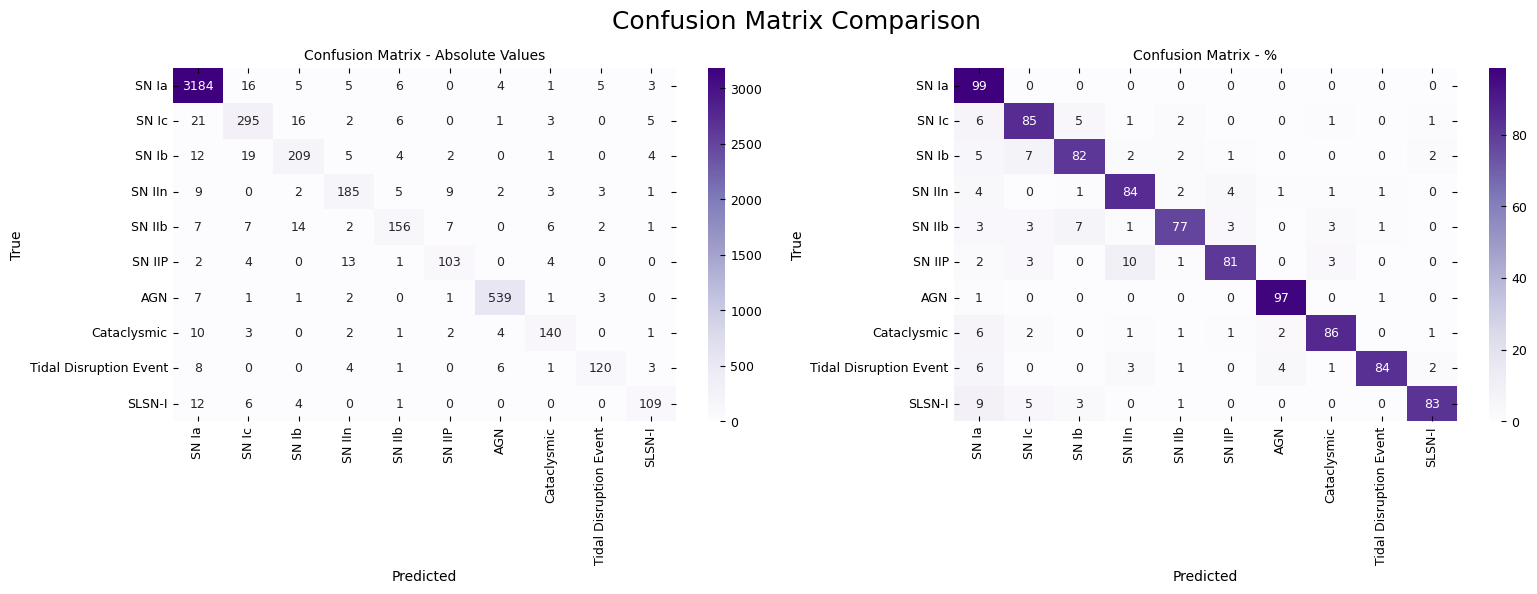

📊 [Val @ Epoch 12] Top-1 Acc: 93.77%, Top-3 Acc: 98.46%, F1: 0.8673
>>> 🚀🚀🚀 New Best Accuracy: 0.8673

[Epoch 13/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.16it/s, acc=94.3, loss=0.0114] 


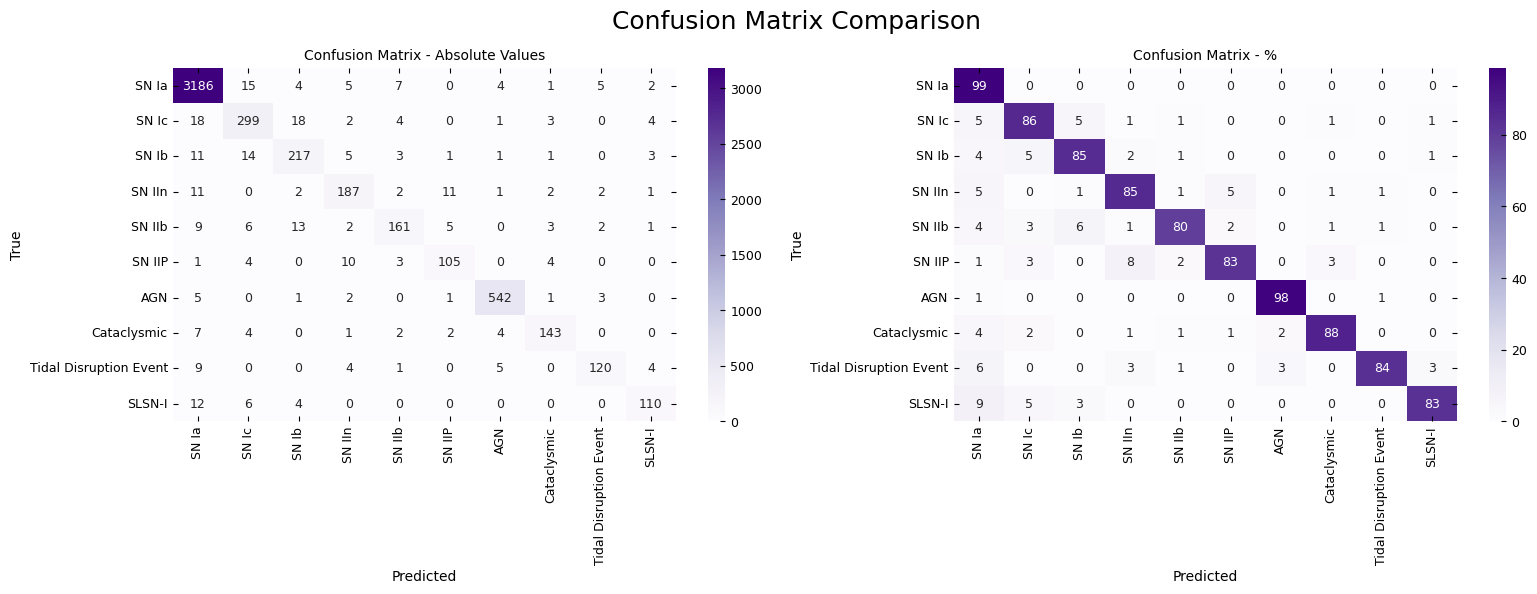

📊 [Val @ Epoch 13] Top-1 Acc: 94.33%, Top-3 Acc: 98.49%, F1: 0.8800
>>> 🚀🚀🚀 New Best Accuracy: 0.8800

[Epoch 14/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.12it/s, acc=94.8, loss=0.0117] 


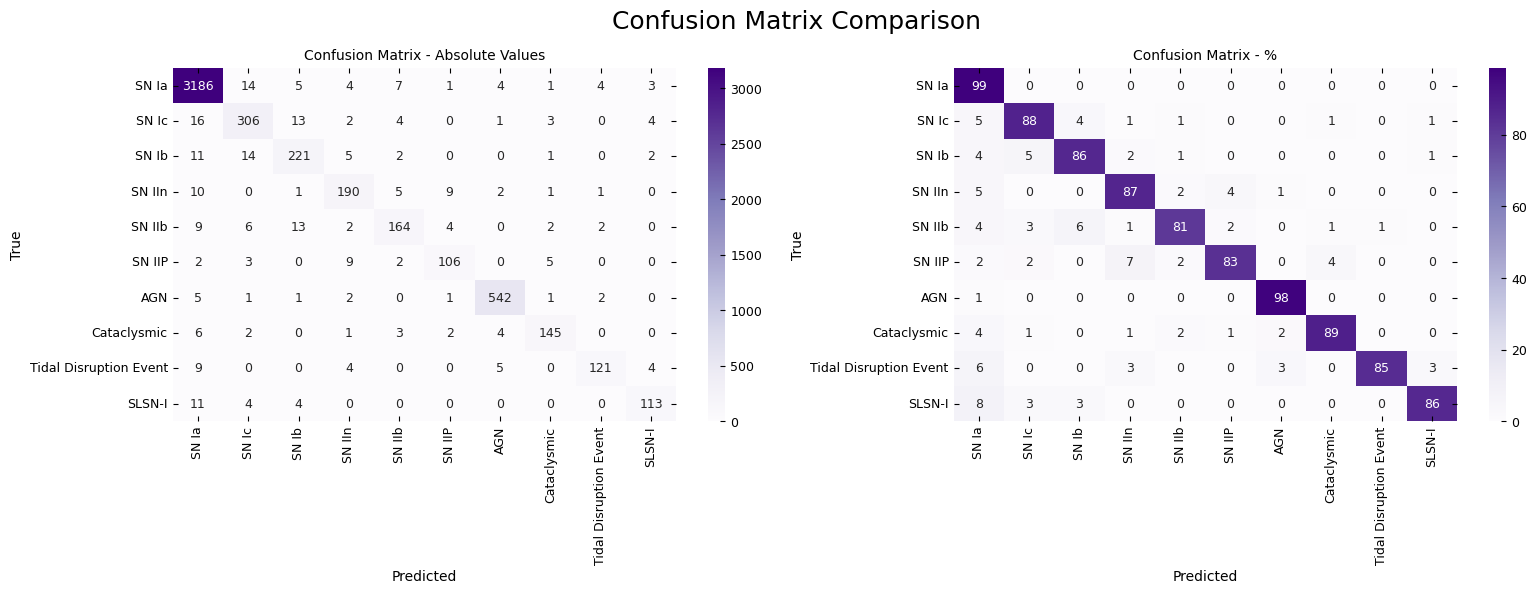

📊 [Val @ Epoch 14] Top-1 Acc: 94.77%, Top-3 Acc: 98.57%, F1: 0.8912
>>> 🚀🚀🚀 New Best Accuracy: 0.8912

[Epoch 15/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.84it/s, acc=94.9, loss=0.0115] 


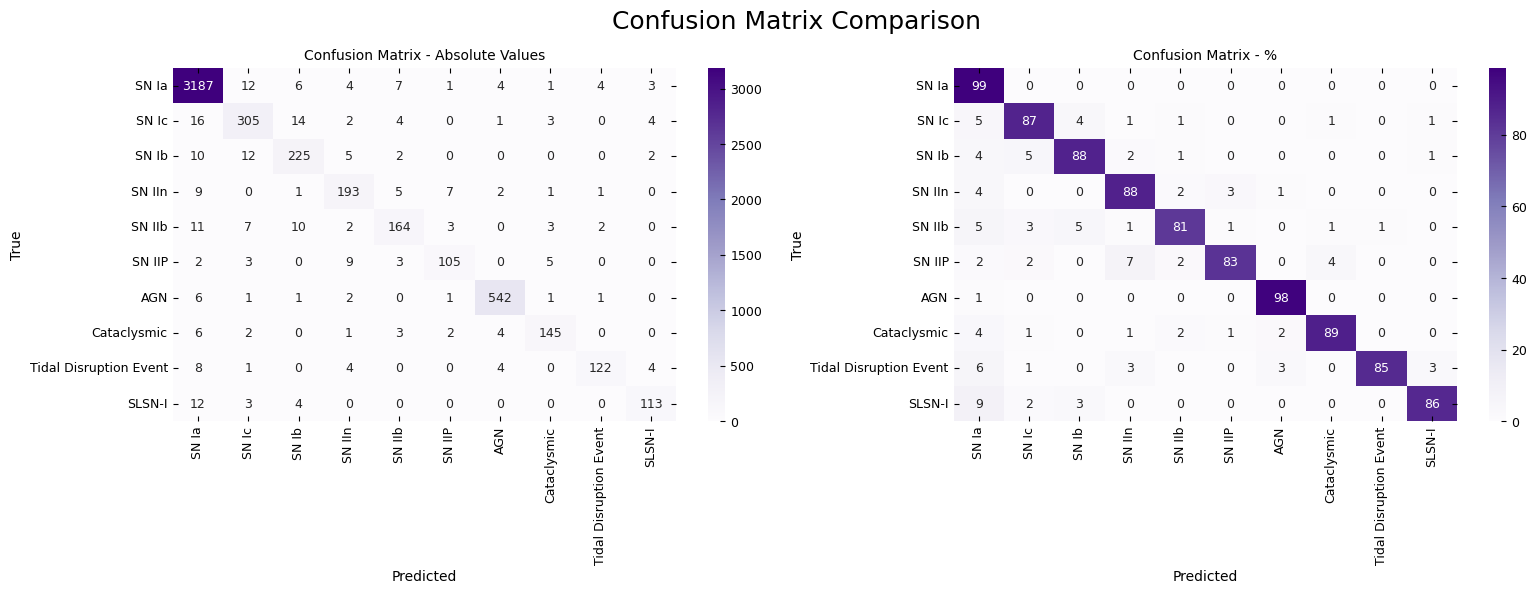

📊 [Val @ Epoch 15] Top-1 Acc: 94.90%, Top-3 Acc: 98.60%, F1: 0.8944
>>> 🚀🚀🚀 New Best Accuracy: 0.8944

[Epoch 16/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.44it/s, acc=95.1, loss=0.0114] 


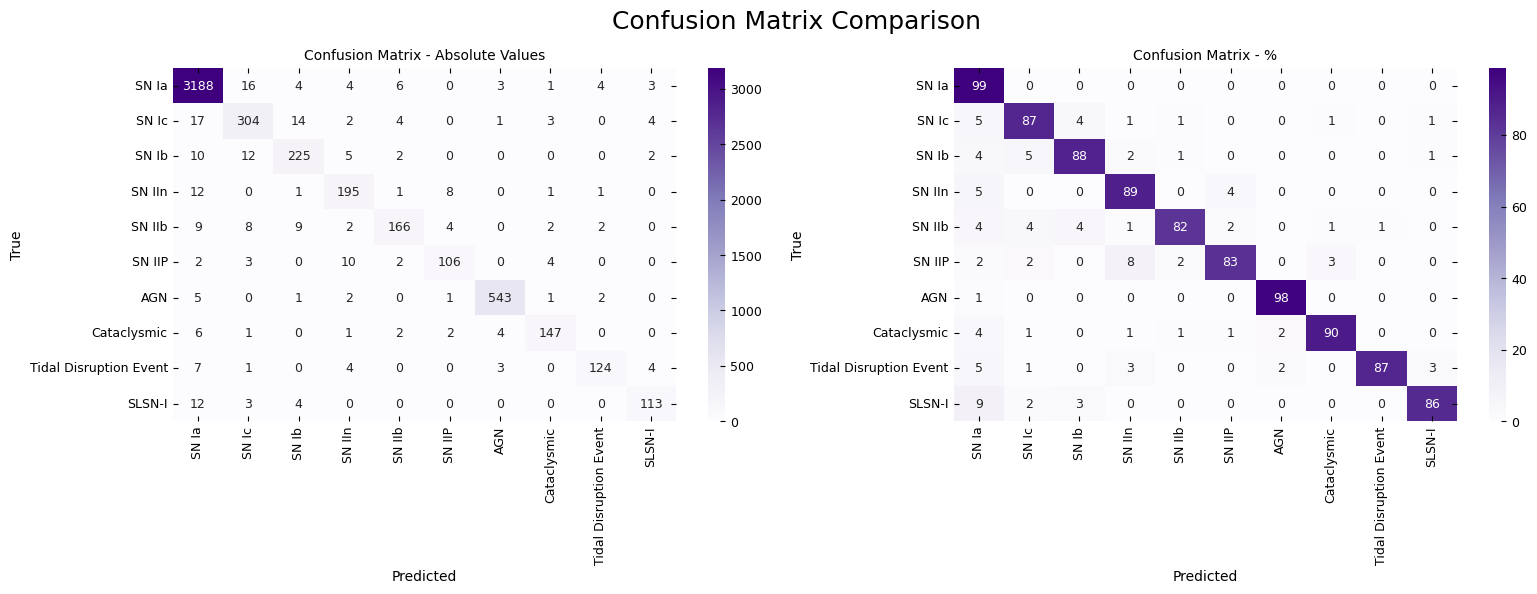

📊 [Val @ Epoch 16] Top-1 Acc: 95.09%, Top-3 Acc: 98.57%, F1: 0.8992
>>> 🚀🚀🚀 New Best Accuracy: 0.8992

[Epoch 17/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.41it/s, acc=95, loss=0.0113]   


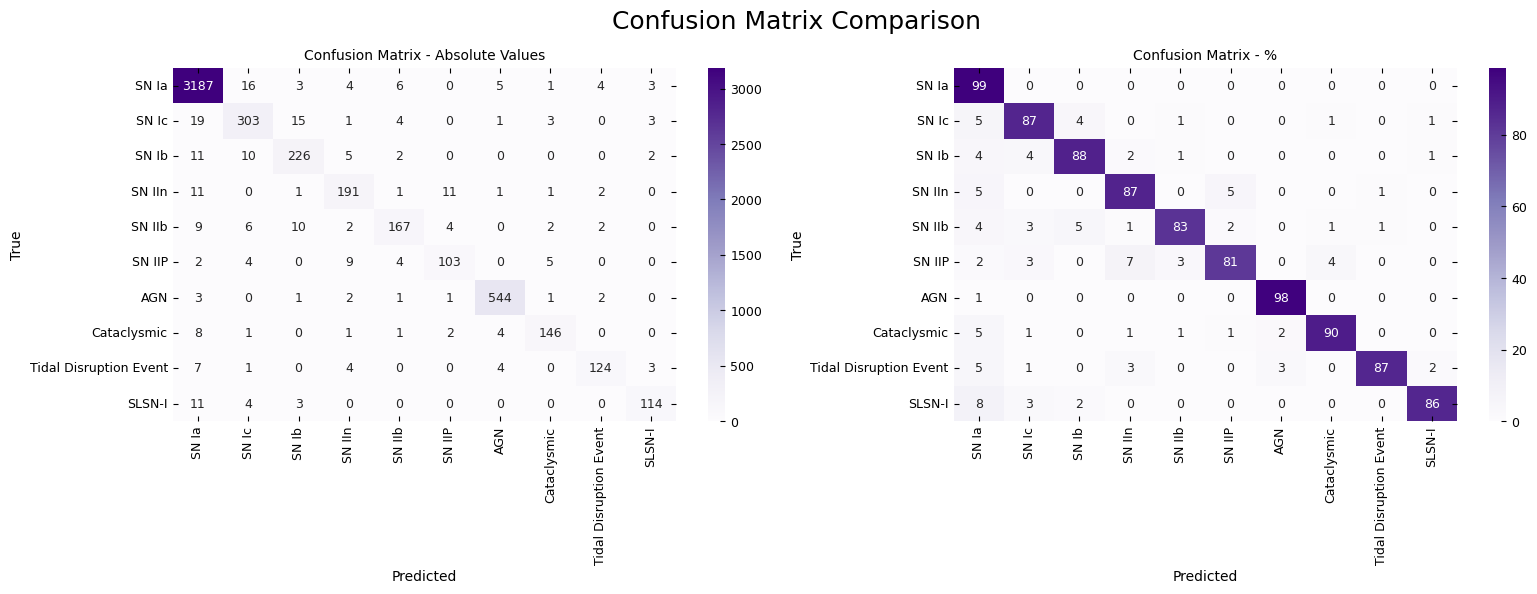

📊 [Val @ Epoch 17] Top-1 Acc: 94.98%, Top-3 Acc: 98.62%, F1: 0.8962
>>> No F1 improvement for 1 epoch(s)

[Epoch 18/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.35it/s, acc=95, loss=0.0118]   


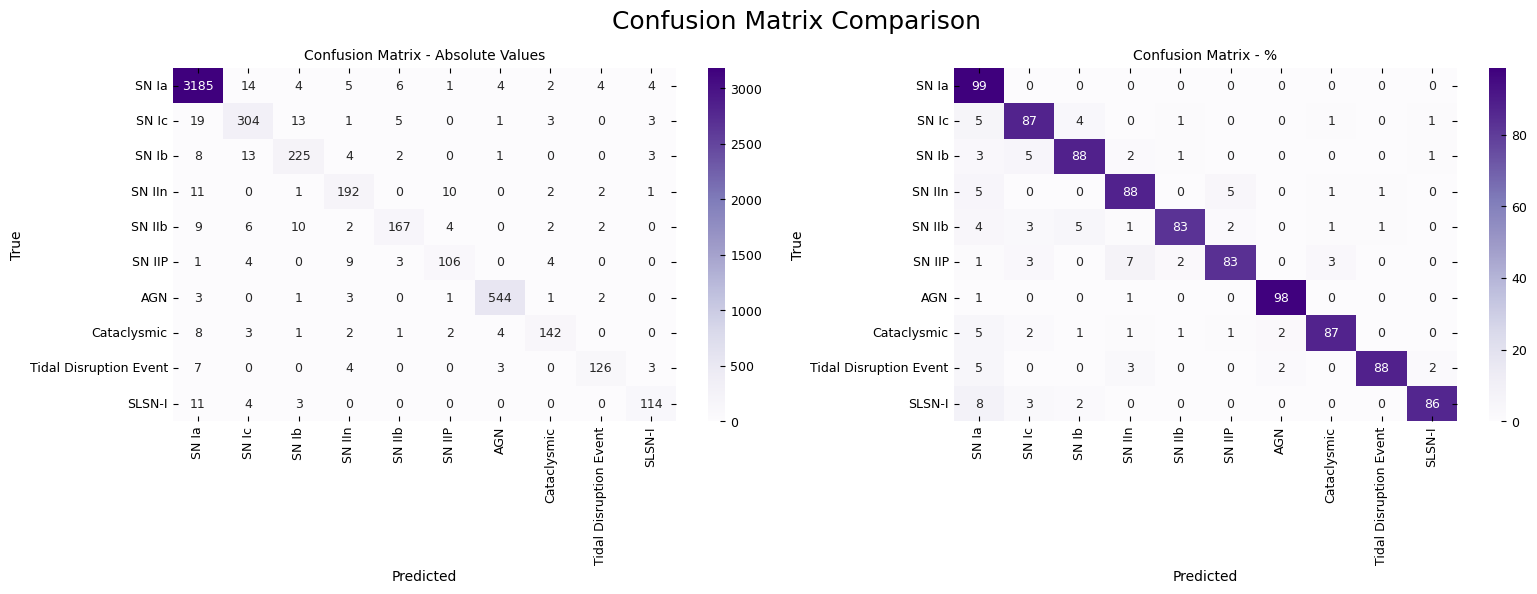

📊 [Val @ Epoch 18] Top-1 Acc: 94.98%, Top-3 Acc: 98.72%, F1: 0.8959
>>> No F1 improvement for 2 epoch(s)

[Epoch 19/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.36it/s, acc=94.9, loss=0.0116] 


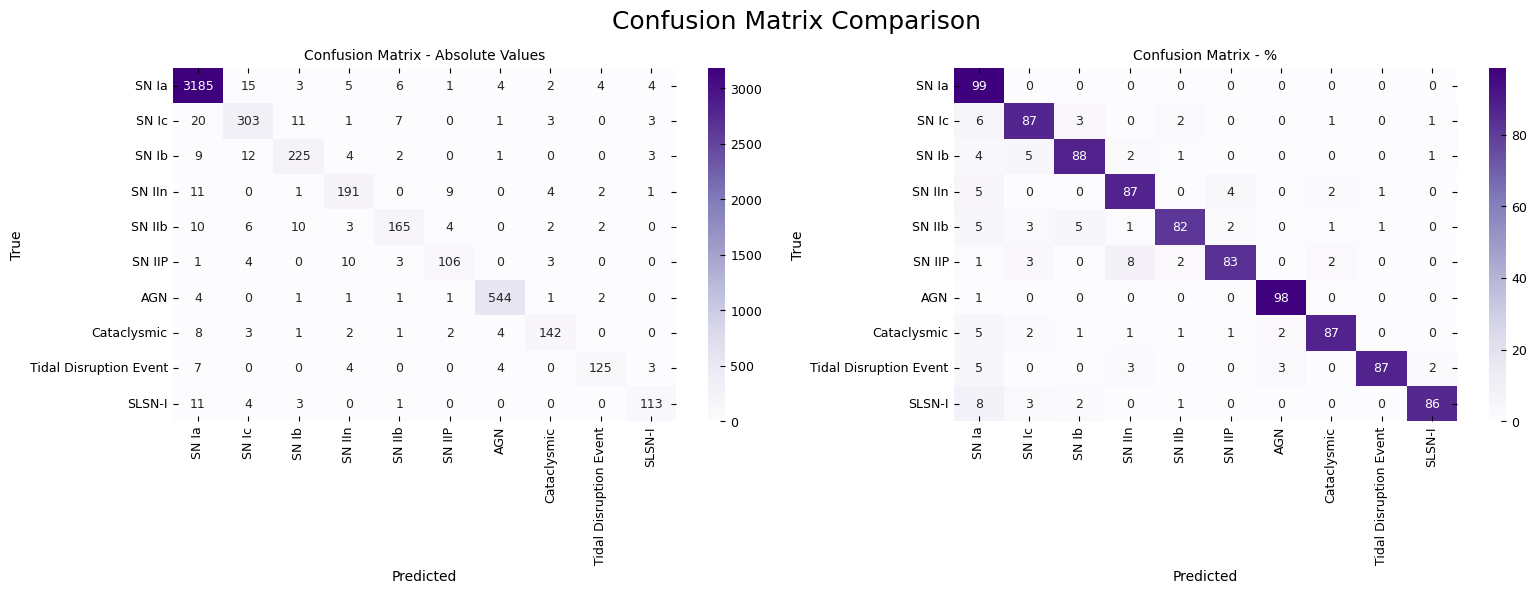

📊 [Val @ Epoch 19] Top-1 Acc: 94.87%, Top-3 Acc: 98.77%, F1: 0.8936
>>> No F1 improvement for 3 epoch(s)

[Epoch 20/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 18.12it/s, acc=95, loss=0.0115]   


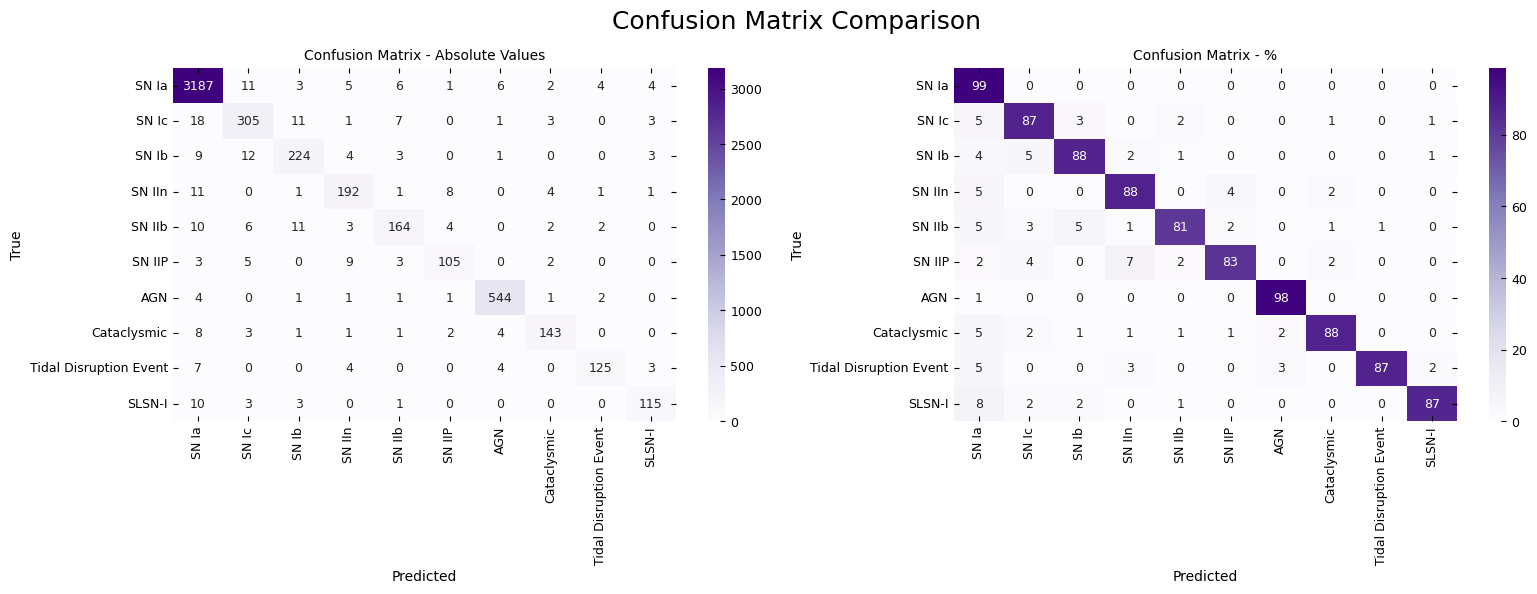

📊 [Val @ Epoch 20] Top-1 Acc: 94.96%, Top-3 Acc: 98.75%, F1: 0.8955
>>> No F1 improvement for 4 epoch(s)

[Epoch 21/100]


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.70it/s, acc=95, loss=0.012]    


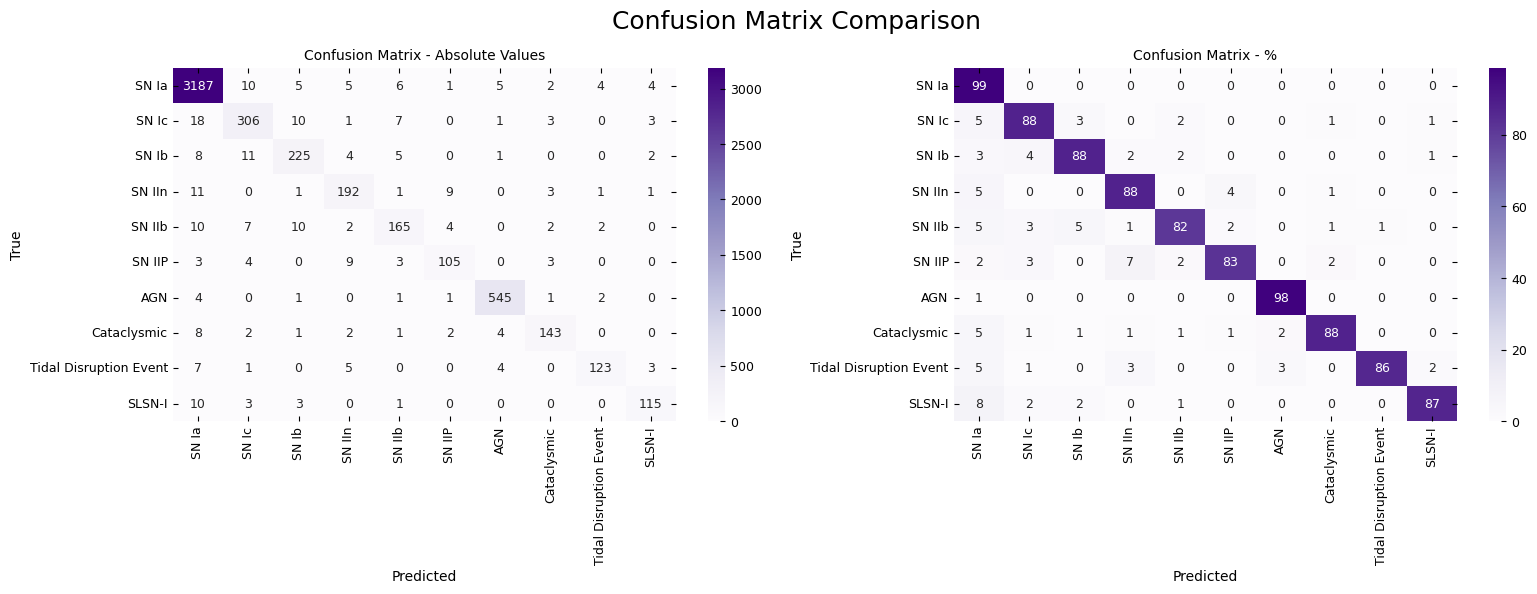

📊 [Val @ Epoch 21] Top-1 Acc: 95.00%, Top-3 Acc: 98.77%, F1: 0.8954
>>> No F1 improvement for 5 epoch(s)
>>> Early stopping triggered based on composite score.
Best F1 on Validate dataset: 0.8992

>>> Final Testing on Test Set...


Validation: 100%|██████████| 21/21 [00:01<00:00, 17.87it/s, acc=94.9, loss=0.0115]


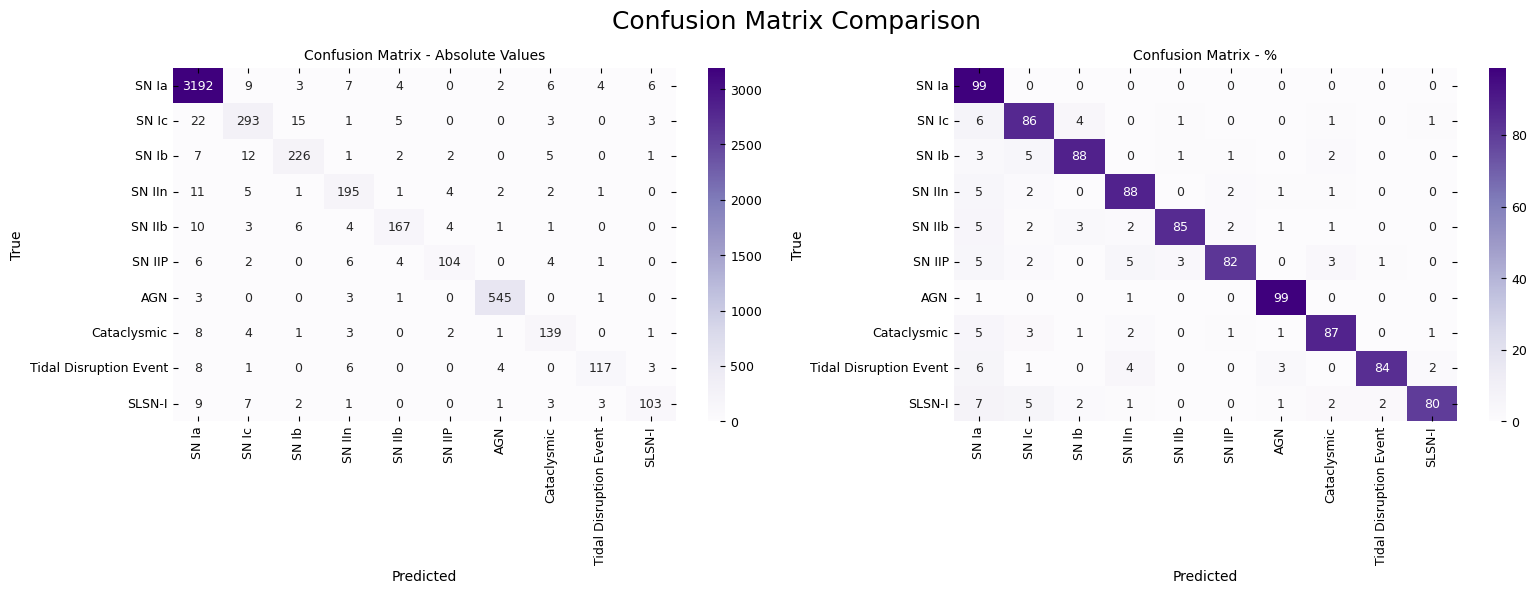


[TEST] Macro ROC-AUC: 0.9943


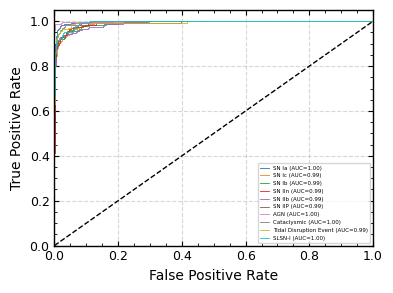

[TEST] ROC curve saved to: c:\Users\Administrator\Desktop\SpectraNet-SN\record
>>> Test Loss: 0.0120, Acc: 94.87%, F1: 0.8898, Top-3 Acc: 98.26%, Composite: 0.9412

=== Multi-Seed Test Results ===
Seed 42: Composite Score = 0.9437, Acc = 95.01%, Top-3 Acc = 98.56%, F1 = 0.8932, Macro AUC = 0.9953
Seed 777: Composite Score = 0.9440, Acc = 95.03%, Top-3 Acc = 98.51%, F1 = 0.8945, Macro AUC = 0.9946
Seed 888: Composite Score = 0.9412, Acc = 94.87%, Top-3 Acc = 98.26%, F1 = 0.8898, Macro AUC = 0.9943

=== Multi-Seed Mean / Std ===
Composite Score: Mean = 0.9430, Std = 0.0013
Accuracy:        Mean = 94.97%, Std = 0.08%
Top-3 Accuracy:  Mean = 98.44%, Std = 0.13%
Macro F1:        Mean = 0.8925, Std = 0.0020
Macro AUC:       Mean = 0.9947, Std = 0.0004

=== Per-Class AUC (Mean ± Std) ===
SN Ia               : Mean = 0.9978, Std = 0.0002
SN Ic               : Mean = 0.9919, Std = 0.0001
SN Ib               : Mean = 0.9927, Std = 0.0011
SN IIn              : Mean = 0.9933, Std = 0.0016
SN IIb  

In [ ]:
data_dir = '../dataset'

pt_dataset_dir = os.path.join(data_dir,"dataset_for_classification_corrected")

model_save_dir = os.path.join(pt_dataset_dir, 'model')
final_config = {
    "num_classes": 11,
    "batch_size": 256,
    "learning_rate": 1.6e-4,
    "weight_decay": 1e-5,
    "ema_decay": 0.995,
    "focal_loss_gamma": 2.0,

    "warmup_epochs": 10,
    "T_0": 5,
    "T_mult": 1,
    "eta_min": 1e-5,
    "start_factor": 1e-6,
    "end_factor": 1.0,
    "num_workers": 0,
    "sampling": False,
    "epochs": 100,
    "optimizer": "AdamW",
    "patience": 5,

    "train_dir": os.path.join(pt_dataset_dir, "processed","train.pt"),

    "val_dir": os.path.join(pt_dataset_dir, "processed","val.pt"),
    "test_dir": os.path.join(pt_dataset_dir, "processed","test.pt"),
    "model_save_dir": os.path.join(pt_dataset_dir, "model"),
    "class_order": [
        # 超新星
        "SN Ia",
        "SN Ic",
        "SN Ib",
        "SN IIn",
        "SN IIb",
        "SN IIP",

        # 活动星系核 & 其它
        "AGN",
        "Cataclysmic",
        "Tidal Disruption Event",

        # 超亮超新星
        "SLSN-I",

    ],
    "seed": 42,
}

seed = [42,777,888]

summary = run_multi_seed(final_config,seed)




In [ ]:
print_multi_seed_summary(summary)


=== Multi-Seed Test Results ===
Seed 42: Composite Score = 0.9437, Acc = 95.01%, Top-3 Acc = 98.56%, F1 = 0.8932, Macro AUC = 0.9953
Seed 777: Composite Score = 0.9440, Acc = 95.03%, Top-3 Acc = 98.51%, F1 = 0.8945, Macro AUC = 0.9946
Seed 888: Composite Score = 0.9412, Acc = 94.87%, Top-3 Acc = 98.26%, F1 = 0.8898, Macro AUC = 0.9943

=== Multi-Seed Mean / Std ===
Composite Score: Mean = 0.9430, Std = 0.0013
Accuracy:        Mean = 94.97%, Std = 0.08%
Top-3 Accuracy:  Mean = 98.44%, Std = 0.13%
Macro F1:        Mean = 0.8925, Std = 0.0020
Macro AUC:       Mean = 0.9947, Std = 0.0004

=== Per-Class AUC (Mean ± Std) ===
SN Ia               : Mean = 0.9978, Std = 0.0002
SN Ic               : Mean = 0.9919, Std = 0.0001
SN Ib               : Mean = 0.9927, Std = 0.0011
SN IIn              : Mean = 0.9933, Std = 0.0016
SN IIb              : Mean = 0.9898, Std = 0.0017
SN IIP              : Mean = 0.9947, Std = 0.0004
AGN                 : Mean = 0.9991, Std = 0.0002
Cataclysmic         : 